Final code for running 800 randomly matched strategies.  Generates 80,000 winners

In [3]:
import random
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from itertools import cycle
from pathlib import Path

In [ ]:
import random
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from itertools import cycle
from pathlib import Path

# Generates dataframe of all possible strategies with score thresholds under 1000
def generate_strategy_df():
    score_thresholds = [50 * i for i in range(1, 21)]
    dice_thresholds = range(0, 5)
    consider_score_options = [True, False]
    consider_dice_options = [True, False]
    smart_options = [True, False]
    all_combinations = list(itertools.product(score_thresholds, dice_thresholds, consider_score_options, consider_dice_options, smart_options))
    random.shuffle(all_combinations)  # Shuffle strategies
    return pd.DataFrame(all_combinations, columns=['score_threshold', 'dice_threshold', 'consider_score', 'consider_dice', 'smart'])

# Considers current score and available dice and processes strategy parameters to determine how a player behaves
class Strategy:
    def __init__(self, score_threshold, dice_threshold, consider_score=True, consider_dice=True, smart=False):
        self.score_threshold = score_threshold
        self.dice_threshold = dice_threshold
        self.consider_score = consider_score
        self.consider_dice = consider_dice
        self.smart = smart

        # Not sure why score_needed is here but I think something else 
        # tries to supply it to the function and I don't want to break that
        # Future me is 80 percent sure this has to do with a player hitting 10,000 
        # and they have to roll or lose
    def decide(self, turn_score, dice_count, has_scored, score_needed):
        if not has_scored and turn_score < 500:
            return True  # Players who haven't scored 500 in a turn must continue

        decision_based_on_score = self.consider_score and turn_score < self.score_threshold
        decision_based_on_dice = self.consider_dice and dice_count > self.dice_threshold

        if self.consider_score and self.consider_dice:
            return decision_based_on_score and decision_based_on_dice
        elif self.consider_score:
            return decision_based_on_score
        elif self.consider_dice:
            return decision_based_on_dice
        return False
    
    def __str__(self):
        return f'Score Threshold: {self.score_threshold}, Dice Threshold: {self.dice_threshold}, \nConsider Score: {self.consider_score}, Consider Dice: {self.consider_dice}, Smart: {self.smart}'

# Logger, mainly for debugging
class Logger:
    def __init__(self, verbose=False):
        self.verbose = verbose

    def log(self, message):
        if self.verbose:
            print(message)

# Generates a Farkle player
class FarklePlayer:
    def __init__(self, name, game, strategy):
        self.name = name
        self.game = game  # Reference to the game instance
        self.score = 0
        self.has_scored = False
        self.strategy = strategy
        self.logger = logger or Logger()

    def roll_dice(self, num_dice): # Dice rolling method
        dice_roll = [random.randint(1, 6) for _ in range(num_dice)]
        self.logger.log(f"{self.name} rolls: {dice_roll}")
        return dice_roll

    def calculate_score(self, dice_roll): # Dice scoring logic method
        counts = Counter(dice_roll)
        score = 0
        used_dice = 0
        reroll_dice = 0
        scoring_dice_exist = any(num == 1 or (count >= 3 and num != 5) for num, count in counts.items())

        # Check for special combinations first
        if len(counts) == 6:  # Straight 1-6
            return 1500, 6, 0
        if len(counts) == 3 and all(count == 2 for count in counts.values()):  # Three pairs
            return 1500, 6, 0
        if len(counts) == 2 and set(counts.values()) == {3, 3}:  # Two triplets
            return 2500, 6, 0
        if len(counts) == 2 and 4 in counts.values() and 2 in counts.values():  # Four of any number with a pair
            return 1500, 6, 0
        
        for num, count in counts.items():
            if count >= 3:  # Scores n-of-a-kind 
                if count == 3:
                    if num == 1:
                        score += 300
                    else:
                        score += num * 100
                elif count == 4:
                    score += 1000
                elif count == 5:
                    score += 2000
                elif count == 6:
                    score += 3000
                used_dice += count
            elif num == 1 and count <= 2:  # Score individual 1's
                score += 100*count
                used_dice += count
            elif num == 5 and count <= 2:
                if self.strategy.smart and score < 300 and not scoring_dice_exist:
                    # Reconsider rerolling strategy: keep one 5 for scoring and consider rerolling the rest
                    if count > 1:
                        score += 50
                        used_dice += 1
                    else:
                        score += 50
                        used_dice += 1
                else:
                    score += count * 50
                    used_dice += count
                    
            reroll_dice = len(dice_roll)-used_dice

        return score, used_dice, reroll_dice

    def take_turn(self): # Player turn logic method.
        dice_count = 6
        turn_score = 0
        rolling = True

        while rolling and dice_count > 0:
            dice_roll = self.roll_dice(dice_count)
            roll_score, used_dice, reroll_dice = self.calculate_score(dice_roll)
            self.logger.log(f"{self.name} rolls: {dice_roll} and scores {roll_score} this roll, used dice: {used_dice}, reroll dice: {reroll_dice}")

            if roll_score == 0:  # No score from the roll, player loses accumulated turn score
                turn_score = 0
                rolling = False
                self.logger.log(f"{self.name} busts and scores nothing this turn.")
            else:
                turn_score += roll_score
                dice_count = reroll_dice  # Set dice_count to reroll_dice directly

                # Check if all dice were used for scoring
                if used_dice == len(dice_roll) and reroll_dice == 0:
                    dice_count = 6  # Reset to 6 dice for a new roll if player chooses to continue
                    self.logger.log(f"{self.name} uses all dice and gets to roll 6 new dice.")

                # Decide whether to continue the turn
                rolling = self.decide_to_continue(turn_score, dice_count)
                self.logger.log(f"{self.name} decides {'to continue' if rolling else 'to stop'} rolling with a turn score of {turn_score} and {dice_count} dice left.")

        if self.score == 0 and turn_score >= 500:
            self.has_scored = True  # Player must score at least 500 in a turn to start scoring
            self.logger.log(f"{self.name} reaches scoring threshold with {turn_score} points.")

        if self.has_scored:
            self.score += turn_score  # Add turn score to total score if the player has already scored previously
            self.logger.log(f"{self.name} ends turn with total score {self.score}")
    

    def decide_to_continue(self, turn_score, dice_count): # Determines if player continues rolling.  This uses strategy objects from the Strategy class
        # Automatically continue if there are 6 dice to roll
        if dice_count == 6:
            self.logger.log(f"{self.name} automatically decides to continue rolling with a fresh set of 6 dice.")
            return True

        # Calculate score needed to consider continuing or stopping (A player has 10,000 points so player has to continue until they can't)
        highest_score = max(p.score for p in self.game.players if p != self)
        game_threshold_exceeded = any(p.score >= 10000 for p in self.game.players)
        if game_threshold_exceeded:
            score_needed = highest_score - (self.score + turn_score)
        else:
            score_needed = 10000 - (self.score + turn_score)

        # Decision based on strategy and game situation
        decision = self.strategy.decide(turn_score, dice_count, self.has_scored, score_needed)
        self.logger.log(f"{self.name} {'decides' if decision else 'does not decide'} to continue with a turn score of {turn_score}, {dice_count} dice left.")
        return decision
    
# This class runs a game of Farkle
class FarkleGame:
    def __init__(self, players):
        self.players = players  # Directly use the list of player objects
        self.scores_over_time = {player.name: [] for player in self.players}
        # Initialize the logger
        self.logger = Logger(verbose=False)

    def play_game(self, max_turns=100):
        final_round = False
        turn_counter = 0
        for turn in range(max_turns):
            for player in self.players:
                player.take_turn()
                self.scores_over_time[player.name].append(player.score)
                # Handles initiating a final round if a player finishes their turn and has >= 10000 points
                if player.score >= 10000 and not final_round:  
                    self.final_round_triggered_by = player  # Record the player who triggers the final round
                    final_round = True
                    self.logger.log(f"Final round triggered by {player.name}")
            turn_counter += 1
            if final_round:
                self.logger.log("Final extra turn for each player except the one who triggered the final round.")
                for player in self.players:
                    if player != self.final_round_triggered_by:  # Skip the player who triggered the final round
                        player.take_turn()
                break
        winner = max(self.players, key=lambda x: x.score)
        if self.logger.verbose == True:  # Used this to check that scores and game outcomes were making sense
            self.calculate_performance_metrics()
        return winner, winner.score, turn_counter

    def calculate_performance_metrics(self): # generating some game stats
        self.logger.log("Calculating performance metrics...")
        # Here, 'player_name' will correctly refer to the string keys of the dictionary, which are player names.
        average_scores = {player_name: scores[-1] / len(scores) if scores else 0 for player_name, scores in self.scores_over_time.items()}
        num_turns = {player_name: len(scores) for player_name, scores in self.scores_over_time.items()}
        highest_score = max((player.score, player.name) for player in self.players)

        # Log the calculated metrics
        for name, average_score in average_scores.items():
            self.logger.log(f"{name} - Average Score: {average_score:.2f}")
        for name, turns in num_turns.items():
            self.logger.log(f"{name} - Number of Turns: {turns}")
        self.logger.log(f"Winner: {highest_score[1]} with a score of {highest_score[0]}")

    def plot_scores(self): # Visualizes scores, mainly used to check that game logic was running correctly
        # Determine the winner and their score
        winner = max(self.players, key=lambda p: p.score)
        winner_info = f"{winner.name} (Strategy: {winner.strategy}) - Score: {winner.score}"

        for player in self.players:
            label = f"{player.name} ({player.strategy})"
            plt.plot(self.scores_over_time[player.name], label=label)
        plt.xlabel('Turn Number')
        plt.ylabel('Score')
        plt.title(f'Score vs Turn Number for Each Player\nWinner: {winner_info}')
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.subplots_adjust(right=0.75)
        plt.show()

# Generates random strategies with smart option. Exists to generate a random strategy if no strategy is given
def random_strategy():
    return Strategy(
        score_threshold=50*random.randint(1,20), # If consider_score is True, then if turn points < score threshold, the player may continue
        dice_threshold=random.randint(0, 4), # If consider_dice is True, then if number of available dice > dice threshold, the player may continue
        consider_score=random.choice([True, False]),
        consider_dice=random.choice([True, False]),
        smart=random.choice([True, False])
    )
logger = Logger(verbose=False)  # Disabled logging when running 80,000 games

# Game simulation function, runs a farkle game for every strategy in the dataframe of strategies provided to it
def simulate_games(df_strategies):
    players = [FarklePlayer(f"Player {i+1}", None, Strategy(**df_strategies.iloc[i])) for i in range(len(df_strategies))]
    game_results = []
    group_size = 5
    for i in range(0, len(players), group_size):
        game = FarkleGame(players[i:i+group_size])
        for player in game.players:  # Update each player's game attribute
            player.game = game
        winner, score, rounds = game.play_game()
        game_results.append({
            'Winner': winner.name,
            'Score': score,
            'Rounds': rounds,
            'Strategy': str(winner.strategy)
        })
    return game_results

# Testing main simulation loop # Commented so I don't try to run this and overwrite vars for generating 80,000 games
'''
results_df = pd.DataFrame()
num_iterations = 5  # Number of times to shuffle and simulate games (500 = 80,000 games)
for _ in range(num_iterations):
    df_strategies = generate_strategy_df()  # Generate a new shuffled DataFrame of strategies
    game_results = simulate_games(df_strategies)
    results_df = results_df.append(game_results, ignore_index=True)
    
print(f"Total games simulated: {len(results_df)}")
print(results_df.head())
'''

# Prepping for writing results
# Set the desired chunk size for writing results periodically
chunk_size = 160
output_csv = 'farkle_game_results.csv'

# Check if the output CSV file already exists
file_exists = Path(output_csv).is_file()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame()


### Main simulation loop, commented out to not start a long process on accident ###
''' 
# Set the total number of game iterations, 500 = 80,000 games | 5000 = 800,000 games
num_iterations = 500
games_counter = 0  # Initialize the games counter
for iteration in range(num_iterations):
    # Generate a new shuffled DataFrame of strategies
    df_strategies = generate_strategy_df()
    
    # Simulate games with the generated strategies
    game_results = simulate_games(df_strategies)

    # Append the game results to the results DataFrame
    results_df = results_df.append(game_results, ignore_index=True)
    games_counter += len(game_results)

    # Save to CSV if the counter reaches the chunk size
    if games_counter >= chunk_size:
        # Append to the existing file if it exists, otherwise write a new file
        results_df.to_csv(output_csv, mode='a', header=not file_exists, index=False)
        file_exists = True  # Update the flag since the file now exists
        games_counter = 0  # Reset the counter
        results_df = pd.DataFrame()  # Clear the DataFrame after writing

# Ensure that any remaining data is written after the loop completes
if games_counter > 0:
    results_df.to_csv(output_csv, mode='a', header=not file_exists, index=False)
'''

This is the unittest code for testing the scoring function

In [ ]:
import unittest
import pandas as pd

# Load the CSV file into a DataFrame
file_path = 'farkle_scores.csv'
game_data = pd.read_csv(file_path)

class TestFarklePlayer(unittest.TestCase):
    def setUp(self):
        # Setup a game and player with a strategy
        strategy = Strategy(300, 2, consider_score=True, consider_dice=True, smart=False)
        self.game = FarkleGame([])
        self.player = FarklePlayer("TestPlayer", self.game, strategy)

    def get_expected_results(self, dice_roll):
        # This method needs to be updated to work with the string format of dice rolls in the CSV
        dice_roll_str = str(dice_roll)
        row = game_data[game_data['Dice Roll'] == dice_roll_str].iloc[0]
        return row['Score'], row['Used Dice'], row['Reroll Dice']

def generate_test(dice_roll, expected_score, expected_used_dice, expected_reroll_dice):
    def test(self):
        score, used_dice, reroll_dice = self.player.calculate_score(eval(dice_roll))
        self.assertEqual(score, expected_score)
        self.assertEqual(used_dice, expected_used_dice)
        self.assertEqual(reroll_dice, expected_reroll_dice)
    return test

# Generate test methods dynamically
for idx, row in game_data.iterrows():
    dice_roll = row['Dice Roll']
    expected_score = row['Score']
    expected_used_dice = row['Used Dice']
    expected_reroll_dice = row['Reroll Dice']
    test_name = f'test_dice_roll_{idx}'
    test_method = generate_test(dice_roll, expected_score, expected_used_dice, expected_reroll_dice)
    setattr(TestFarklePlayer, test_name, test_method)

def run_tests():
    suite = unittest.TestLoader().loadTestsFromTestCase(TestFarklePlayer)
    unittest.TextTestRunner().run(suite)

run_tests()

Cleaning up the CSV into something more usable:

In [ ]:
input_csv_path = 'farkle_game_results.csv'
output_csv_path = 'farkle_game_results_combined.csv'

# Open the input and output files
with open(input_csv_path, 'r') as infile, open(output_csv_path, 'w') as outfile:
    lines = infile.readlines()
    
    # Write the header directly to the output file
    header = lines[0]
    outfile.write(header)

    # Process the lines two by two
    i = 1  # Start after the header
    while i < len(lines) - 1:
        # Read two lines together
        first_line = lines[i].strip()
        second_line = lines[i + 1].strip()

        # Combine the two lines with the strategy description corrected
        combined_line = first_line + " " + second_line

        # Write the corrected line to the output file
        outfile.write(combined_line + "\n")

        # Move to the next pair of lines
        i += 2

print(f"Combined data saved to {output_csv_path}")

In [ ]:
import pandas as pd
import re

# Load the combined CSV file
combined_csv_path = 'farkle_game_results_combined.csv'
df = pd.read_csv(combined_csv_path)

# Define a pattern to capture the individual strategy parameters
pattern = re.compile(
    r"Score Threshold: (\d+), Dice Threshold: (\d+), Consider Score: (True|False), Consider Dice: (True|False), Smart: (True|False)"
)

# Function to extract strategy parameters from a strategy string
def extract_strategy_params(strategy_string):
    match = pattern.search(strategy_string)
    if match:
        return {
            'Score Threshold': int(match.group(1)),
            'Dice Threshold': int(match.group(2)),
            'Consider Score': match.group(3) == 'True',
            'Consider Dice': match.group(4) == 'True',
            'Smart': match.group(5) == 'True'
        }
    else:
        return {
            'Score Threshold': None,
            'Dice Threshold': None,
            'Consider Score': None,
            'Consider Dice': None,
            'Smart': None
        }

# Apply the function to the 'Strategy' column
strategies = df['Strategy'].apply(extract_strategy_params)
strategies_df = pd.DataFrame(strategies.tolist())

# Combine the extracted strategy columns with the original DataFrame
final_df = pd.concat([df.drop(columns=['Strategy']), strategies_df], axis=1)

# Write the updated DataFrame to a new CSV file
final_csv_path = 'farkle_game_results_expanded.csv'
final_df.to_csv(final_csv_path, index=False)

print(f"Expanded data saved to {final_csv_path}")

Generating EDA: 

In [ ]:
import sweetviz as sv
df = pd.read_csv('farkle_game_results_expanded.csv')
my_report = sv.analyze(df)
my_report.show_html()

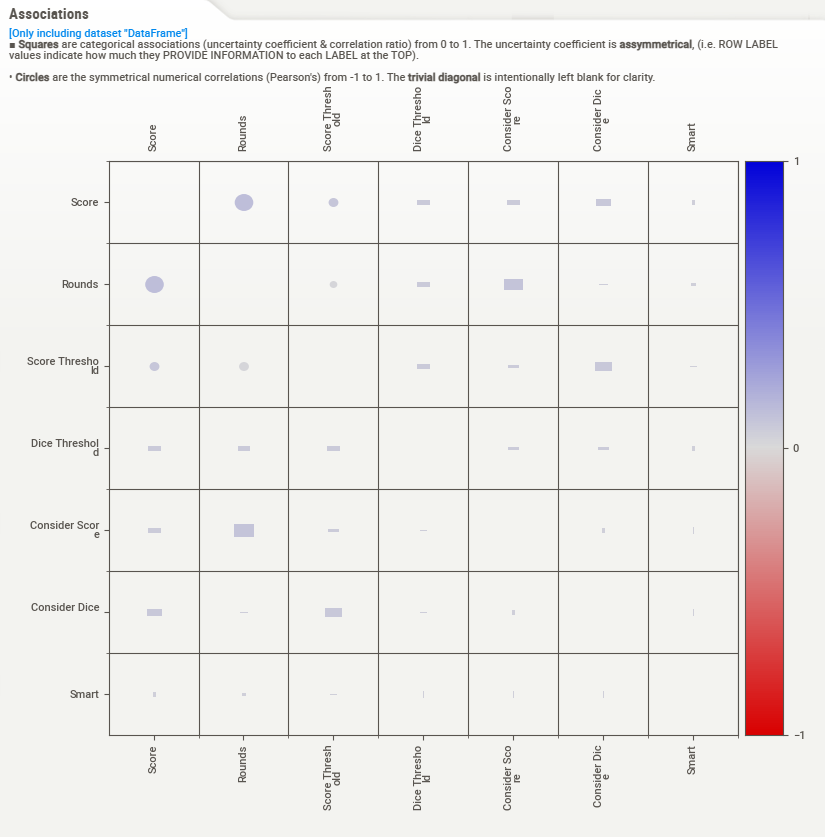

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open("All Wins Associations.png")
display(img)

Very weak associations overall.  Clearly randomness dominates in terms of optimal play to win Farkle.  Top 3 corellations are Rounds and Score, Rounds and Consider Score, and Score Threshold and Consider Dice.  You get slightly higher scores with more rounds on average which makes some sense.  If you end a turn at 9950, you take an extra turn where exceeding 10,000 points becomes relatively easy.  Consider Score and Rounds being correlated also makes sense.  A person considering their score is playing strategically and potentially in a risk averse manner.  Score Threshold and Consider Dice being correlated makes little sense other than the sample is game winners and a person considering dice and score was more likely to win.

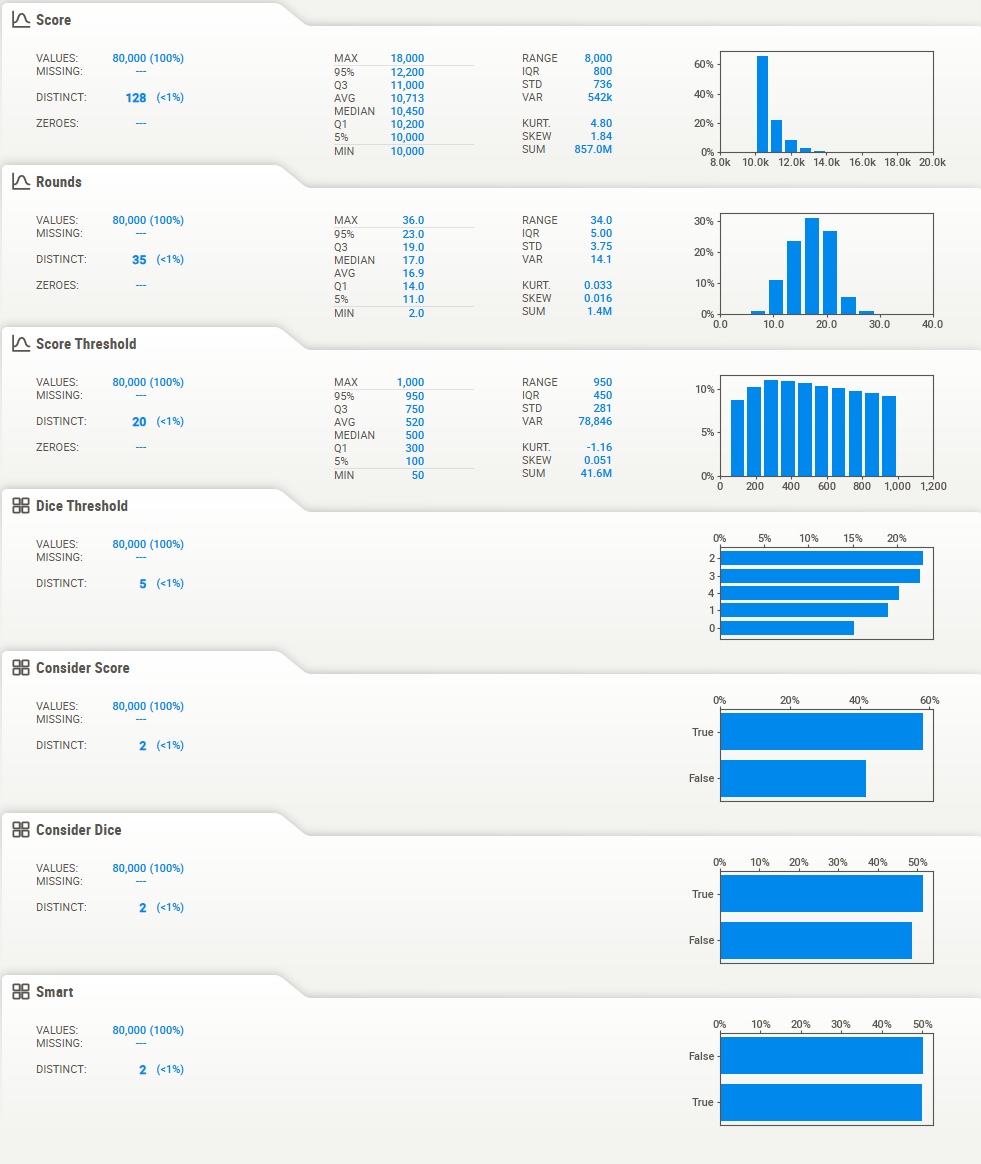

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open("All Wins EDA.png")
display(img)

Initial results are:

~300 is the best score threshold (units are weird so I'll have to graph it myself)

2 dice is the best dice threshold (i.e. continue rolling with 3+ dice available)

Consider Score is more important than consider dice.  Smart basically doesn't matter.

Casting Bools in the dataframe to Ints

In [ ]:
import pandas as pd
df = pd.read_csv('farkle_game_results_expanded.csv')
columns_to_convert = ['Consider Score', 'Consider Dice', 'Smart']
df[columns_to_convert] = df[columns_to_convert].astype(int)
print(df.head())

This generates the initial list of interactions I looked at.  I did another EDA after and made a smaller list that had non-zero interaction terms

In [ ]:
import itertools
a = 'Score Threshold'
b = 'Dice Threshold'
c = 'Consider Score'
d = 'Consider Dice'
e = 'Smart'
interaction_terms = [
    (c, d), #
    (c, e), #
    (d, e),
    (c, d, e), #
    (a, c), # this
    (a, e),
    (a, c, e), # this
    (a, c, d, e),
    (b, d),
    (b, e),
    (b, d, e),  # this
    (b, c, d, e)

]
df['Score_Dice_Threshold_Interaction'] = df['Score Threshold'] / (df['Dice Threshold'] + 1)  # high score and low dice is riskier so divide.  Add 1 to prevent divide by 0
for interaction in interaction_terms:
    interaction_term_name = '_x_'.join(interaction)
    df[interaction_term_name] = df[list(interaction)].prod(axis=1)

print(df.head())
output_file_path = 'farkle_with_interactions.csv'
df.to_csv(output_file_path, index=False)
print(df.head())

In [ ]:
import pandas as pd
df = pd.read_csv('farkle_game_results_expanded.csv')
columns_to_convert = ['Consider Score', 'Consider Dice', 'Smart']
df[columns_to_convert] = df[columns_to_convert].astype(int)
print(df.head())

import itertools
a = 'Score Threshold'
b = 'Dice Threshold'
c = 'Consider Score'
d = 'Consider Dice'
e = 'Smart'
interaction_terms = [
    (c, d), #
    (c, e), #
    (c, d, e), #
    (a, c), # 
    (a, c, e), # 
    (b, d, e),  # 
]
df['Score_Dice_Threshold_Interaction'] = df['Score Threshold'] / (df['Dice Threshold'] + 1)  # high score and low dice is riskier so divide.  Add 1 to prevent divide by 0
for interaction in interaction_terms:
    interaction_term_name = '_x_'.join(interaction)
    df[interaction_term_name] = df[list(interaction)].prod(axis=1)

print(df.head())
output_file_path = 'farkle_with_nonzero_interactions.csv' 
df.to_csv(output_file_path, index=False)

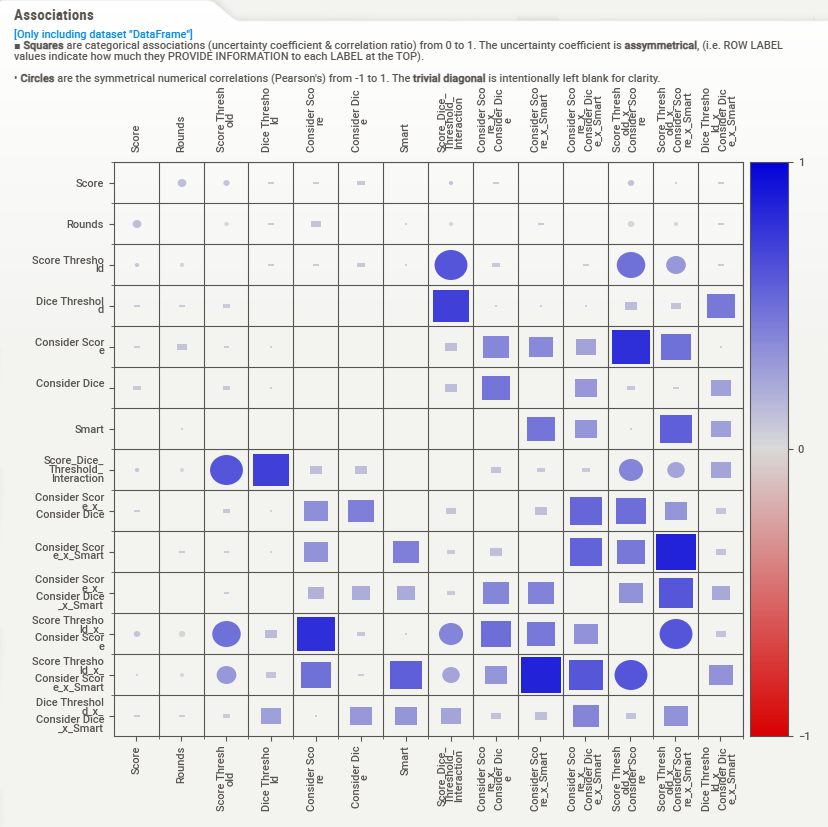

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open("All Wins Interactions Associations.png")
display(img)

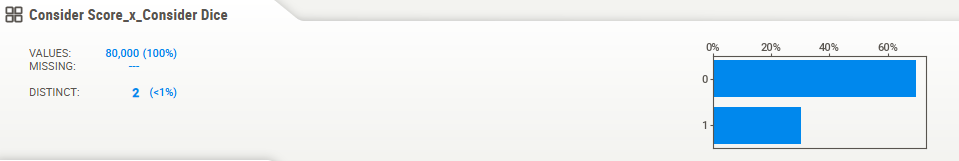

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open("Interactions Not Useful.png")
display(img)

Turns out interactions are not very useful.  The stronger interaction boxes are just detecting that Consider Score is related to interactions between Consider Score and Score Threshold.  Duh they are corellated.  The distribution graphs of interactions were bad visual tools too because a positive interaction was like a recessive gene.

On first glance, it looks like considering both score and dice is a great way to lose, but randomness dominates and only 25% of all strategies have both Consider Score and Consider Dice as True.

Graph of statistical spreads of winning strategies compared with how many rounds the games lasted.  The IQR at the top is miniscule.  Possibly slightly fewer rounds on average with high score thresholds than small score thresholds.

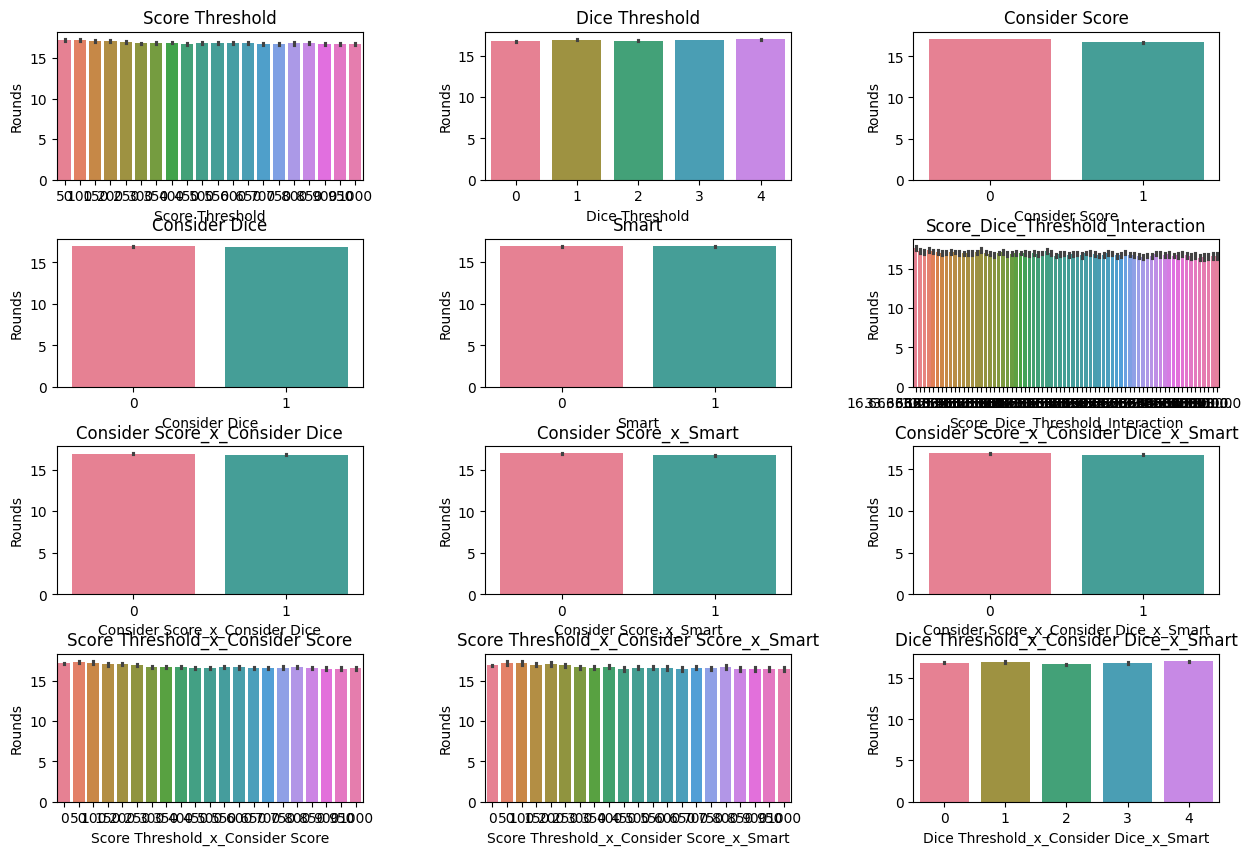

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
file_path = 'farkle_with_nonzero_interactions.csv'
df = pd.read_csv(file_path)

# List of variables to plot against Rounds
variables_to_plot = [
    'Score Threshold', 'Dice Threshold', 'Consider Score', 'Consider Dice', 'Smart',
    'Score_Dice_Threshold_Interaction', 'Consider Score_x_Consider Dice',
    'Consider Score_x_Smart', 'Consider Score_x_Consider Dice_x_Smart',
    'Score Threshold_x_Consider Score', 'Score Threshold_x_Consider Score_x_Smart',
    'Dice Threshold_x_Consider Dice_x_Smart'
]

# Set up the grid for plotting
n_cols = 3
n_rows = (len(variables_to_plot) + n_cols - 1) // n_cols  # Calculate number of rows required
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through variables and create bar plots
for i, variable in enumerate(variables_to_plot):
    y = df['Rounds']
    x = df[variable]
    palette = sns.color_palette('husl', x.nunique())
    sns.barplot(x = x, y = y, ax=axes[i], hue = x, palette = palette, legend = False)
    axes[i].set_title(variable)
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel('Rounds')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

Now looking at counts of how many wins each strategy had.  350 score threshold had the most wins but not by a lot and 300 is really close. Dice threshold of 2 has the most wins but 3 is very close behind.  Consider score seems to have more impact than consider dice.  Smart strategy seems to have no effect.  Interaction graphs aren't useful here due to sparse data.

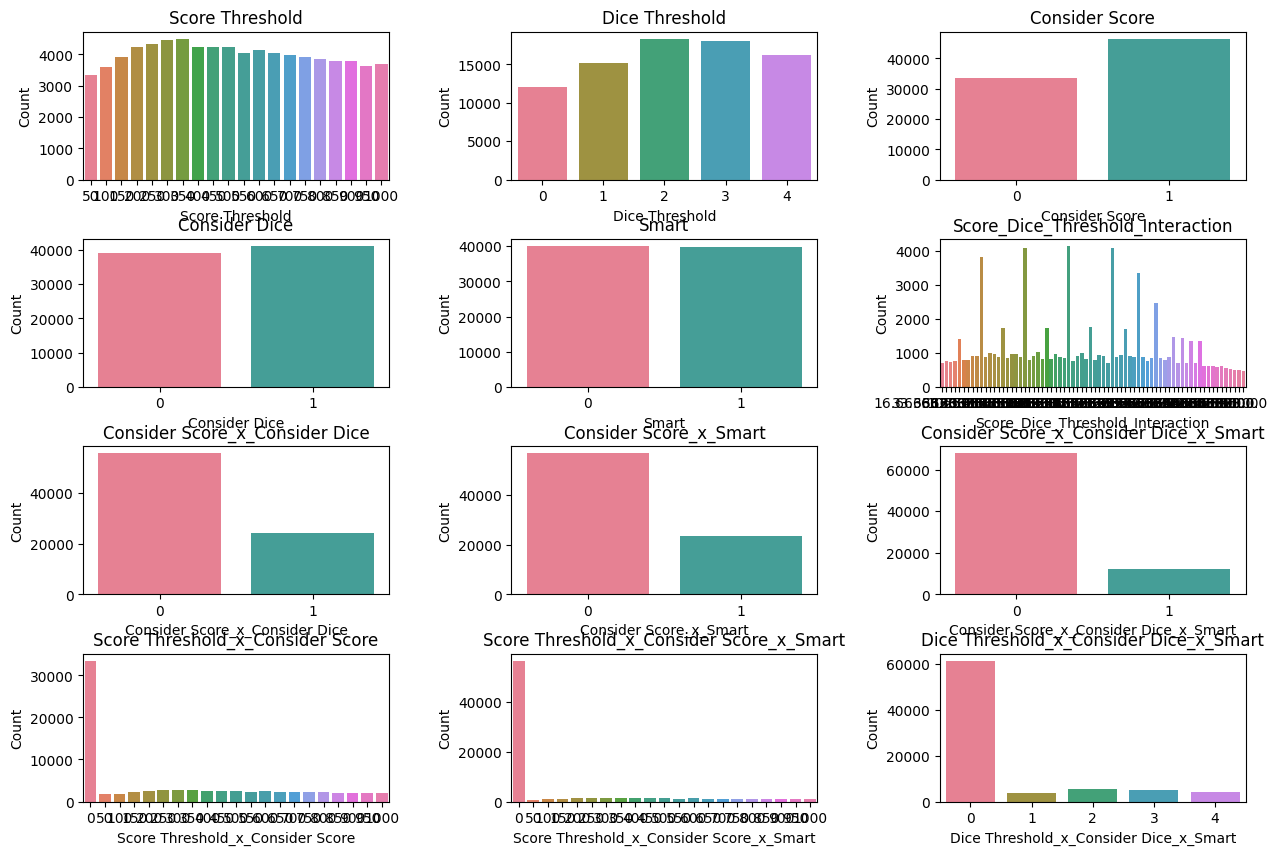

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
file_path = 'farkle_with_nonzero_interactions.csv'
df = pd.read_csv(file_path)

# List of variables to plot
variables_to_plot = [
    'Score Threshold', 'Dice Threshold', 'Consider Score', 'Consider Dice', 'Smart',
    'Score_Dice_Threshold_Interaction', 'Consider Score_x_Consider Dice',
    'Consider Score_x_Smart', 'Consider Score_x_Consider Dice_x_Smart',
    'Score Threshold_x_Consider Score', 'Score Threshold_x_Consider Score_x_Smart',
    'Dice Threshold_x_Consider Dice_x_Smart'
]

# Set up the grid for plotting
n_cols = 3
n_rows = (len(variables_to_plot) + n_cols - 1) // n_cols  # Calculate number of rows required
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through variables and create bar plots
for i, variable in enumerate(variables_to_plot):
    x = df[variable]
    palette = sns.color_palette('husl', x.nunique())
    sns.countplot(x = x, ax=axes[i], hue = x, palette = palette, legend = False)
    axes[i].set_title(variable)
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel('Count')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

New Approach: count how many wins each strategy has.  Then analyze the top 50 strategies to see what patterns are producing the most common wins.  760 strategies of 800 had winning games.  Only 5 percent of strategies never won a game.

In [ ]:
import pandas as pd

# Load CSV
file_path = 'farkle_game_results_expanded.csv'
df = pd.read_csv(file_path)

# Select the last five columns that define the strategy
strategy_columns = ['Score Threshold', 'Dice Threshold', 'Consider Score', 'Consider Dice', 'Smart']
strategies = df[strategy_columns]

# Group by these columns and count occurrences
strategy_counts = strategies.groupby(strategy_columns).size().reset_index(name='Count')

# Sort by count to see which strategy is most common
strategy_counts_sorted = strategy_counts.sort_values(by='Count', ascending=False)

# Save df 
output_file_path = 'farkle_strategy_counts.csv'  
strategy_counts_sorted.to_csv(output_file_path, index=False)

# Display the result
print(strategy_counts_sorted)

Counts of strategy wins among the top 50 most common. Excluding interaction terms for now.  Making a reusable function out of counts graphing because it's very useful to look at.

In [ ]:
import math

def farkle_counts_plotter(dataframe, column_names):
    # Set up the grid for plotting
    n_cols = 3
    n_rows = math.ceil(len(column_names)/n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    # Flatten axes array for easy indexing
    axes = axes.flatten()

    # Create bar plots for each variable
    for i, variable in enumerate(column_names):
        x = dataframe[variable]
        palette = sns.color_palette('husl', x.nunique())
        sns.countplot(x = x, ax=axes[i], hue = x, palette = palette, legend = False)
        axes[i].set_title(f'{variable} Distribution')
        axes[i].set_xlabel(variable)
        axes[i].set_ylabel('Count')
        if i == 0:
            axes[i].tick_params(axis='x', rotation=315)
        

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle("Counts of Each Variable in Top 50 Strategies")
    plt.tight_layout()
    plt.show()

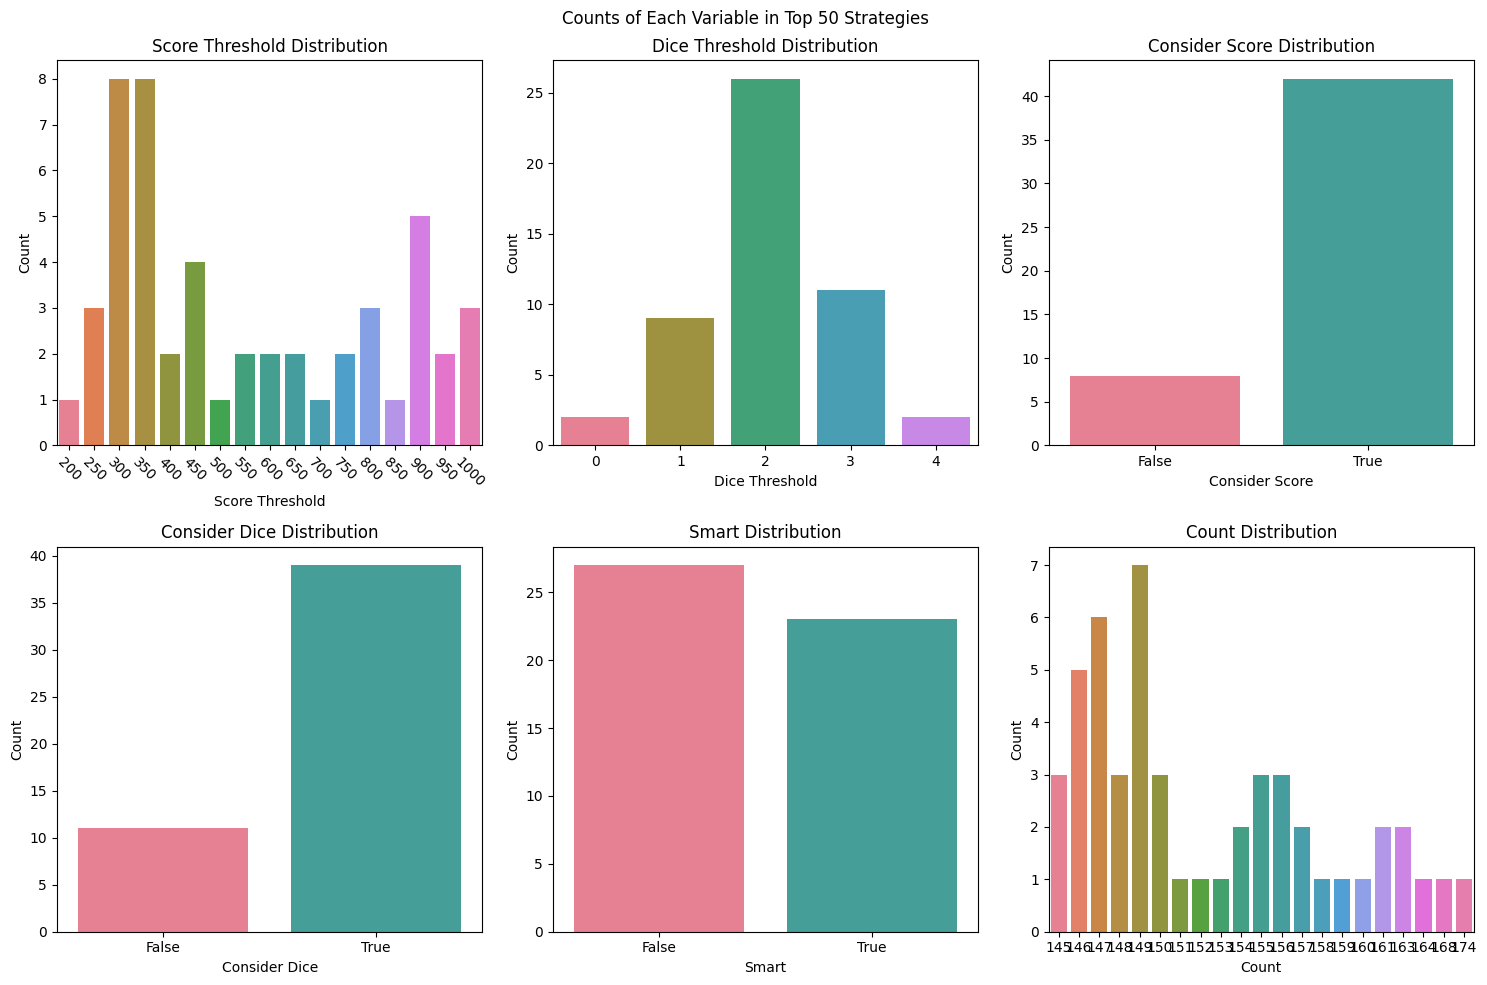

      Score Threshold  Dice Threshold  Consider Score  Consider Dice  Smart  \
0                 250               3            True          False   True   
1                 250               3            True          False   True   
2                 250               3            True          False   True   
3                 250               3            True          False   True   
4                 250               3            True          False   True   
...               ...             ...             ...            ...    ...   
7621              750               2            True           True   True   
7622              750               2            True           True   True   
7623              750               2            True           True   True   
7624              750               2            True           True   True   
7625              750               2            True           True   True   

      Count  
0       174  
1       174  
2       1

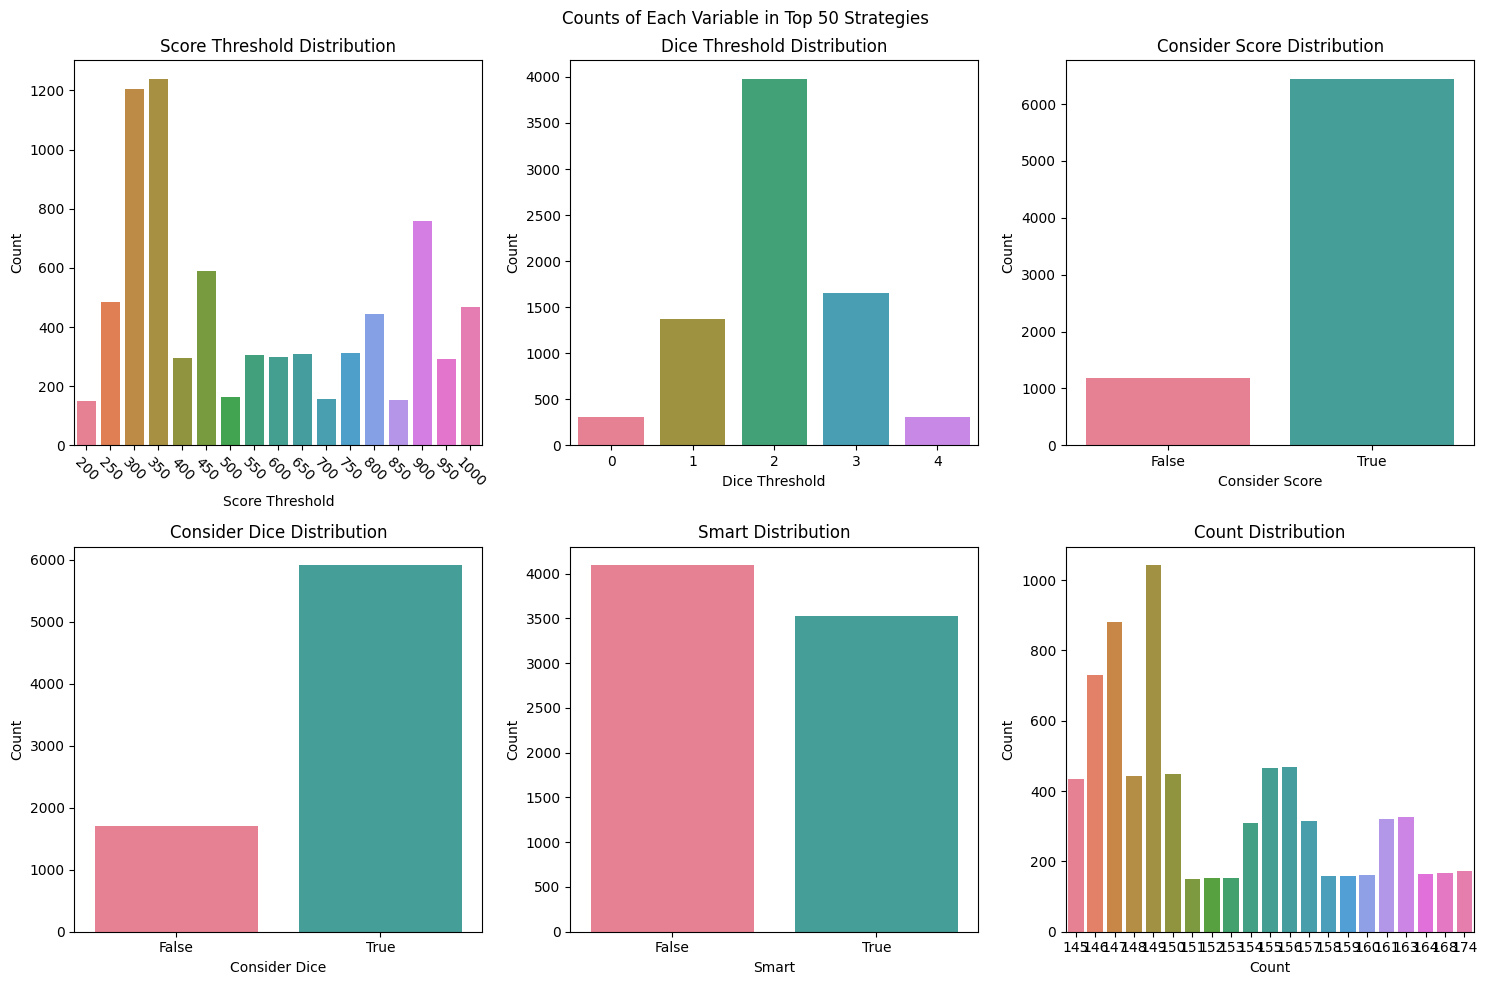

In [ ]:
file_path = 'farkle_strategy_counts.csv'
df = pd.read_csv(file_path)

# Select the last five columns that define the strategy
strategy_columns = ['Score Threshold', 'Dice Threshold', 'Consider Score', 'Consider Dice', 'Smart', 'Count']
strategies = df[strategy_columns]

# Sort by count to see which strategy is most common and take the top 50
top_50_strategies = strategies.head(50)

farkle_counts_plotter(top_50_strategies, strategy_columns)

weighted_df = top_50_strategies.loc[top_50_strategies.index.repeat(top_50_strategies['Count'])]

# Reset index to make it clean
weighted_df = weighted_df.reset_index(drop=True)

# Check the resulting DataFrame
print(weighted_df)

# Show DF
farkle_counts_plotter(weighted_df, strategy_columns)


So the best Farkle strategy is to make a deal with the devil for amazing luck.  The second best Farkle strategy is to continue rolling until you have at least 350 points but only if you have more than 2 dice available for rolling (and you couldn't be blamed for stopping at 300 if you only had 3 dice available to roll).  I'm a little surprised "Smart" isn't actually that smart.  I'd expected that adding an extra die into the pool would increase the chances of rolling n-of-a-kind or a 1 enough to make it more worth it.  There are a lot of Smart = True here so I want to see what kind of trends might exist where smart is the better option.  That resulted in the graphs below that were not actually that useful.  Too many graphs to actually understand anything.  So before the graphs, there is some dataframe exploration related to the Smart strategy that was performed after realizing the graphs were not particularly useful.

Graph reading reminder: If consider_score is True, then if turn points < score threshold, the player may continue.  If consider_dice is True, then if number of available dice > dice threshold, the player may continue.  I say may here because if they are considering both their dice and their score, only one of them has to miss the threshold for them to stop.

In [ ]:
import pandas as pd

strats_df = pd.read_csv("farkle_strategy_counts.csv", header=0)

grouped = strats_df.groupby(["Score Threshold", "Dice Threshold", "Consider Score", "Consider Dice", "Smart"])["Count"].sum().unstack(fill_value=0)
grouped["Fraction"] = grouped[True] / grouped[False]
grouped["Sum"] = grouped[True] + grouped[False]
grouped

Smart                                                        False  True  \
Score Threshold Dice Threshold Consider Score Consider Dice                
50              0              False          False             92    76   
                               True           False             88    85   
                                              True             101    68   
                1              False          False             79    84   
                                              True              52    45   
...                                                            ...   ...   
1000            3              True           True             136   135   
                4              False          False            106    84   
                                              True             108   118   
                               True           False             64    74   
                                              True              89   106   

Smart                                                        Fraction  Sum  
Score Threshold Dice Threshold Consider Score Consider Dice                 
50              0              False          False          0.826087  168  
                               True           False          0.965909  173  
                                              True           0.673267  169  
                1              False          False          1.063291  163  
                                              True           0.865385   97  
...                                                               ...  ...  
1000            3              True           True           0.992647  271  
                4              False          False          0.792453  190  
                                              True           1.092593  226  
                               True           False          1.156250  138  
                                              True           1.191011  195  

[380 rows x 4 columns]

In [ ]:
sort_grouped = grouped.sort_values("Fraction", ascending=False)
filter_grouped = grouped[grouped["Fraction"] > 1]
filter_grouped.sort_values(["Consider Score", "Consider Dice", "Score Threshold", "Dice Threshold"], ascending=False)
filter_grouped

In [ ]:
# filter_grouped.to_csv("Smart_Comparison.csv")

In [ ]:
import sweetviz as sv

s:\Libraries\OneDrive\Documents\Code Projects Parent Folder\Code Projects\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv('Smart_Comparison.csv')
my_report = sv.analyze(df)
my_report.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


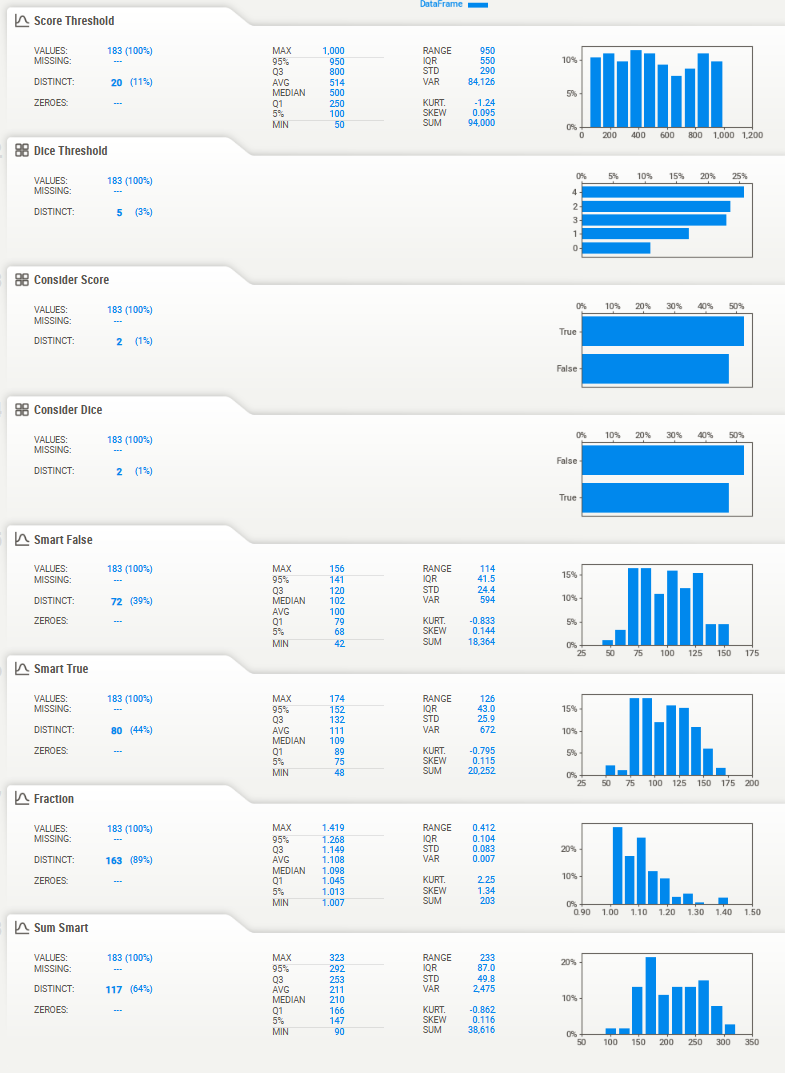

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open("Smart Better Wins.png")
display(img)

In [ ]:
smart_sorted_count = df.sort_values("Sum Smart", ascending=False)
smart_sorted_fraction =  df.sort_values("Fraction", ascending=False)

In [ ]:
best_smart_sorted_count = smart_sorted_count.head(20)
best_smart_sorted_fraction = smart_sorted_fraction.head(20)

In [ ]:
best_smart_sorted_count

Score Threshold  Dice Threshold  Consider Score  Consider Dice  \
46               250               3            True          False   
160              900               2            True           True   
63               350               2            True          False   
103              550               2            True           True   
92               500               2            True           True   
112              600               2            True           True   
81               450               2            True           True   
171              950               3           False           True   
150              850               2            True           True   
52               300               2            True           True   
58               350               0            True          False   
124              700               2            True           True   
41               250               1            True          False   
169              950               2            True           True   
50               300               0            True          False   
161              900               3           False           True   
142              800               3            True           True   
179             1000               3           False           True   
113              600               3            True           True   
65               350               3            True           True   

     Smart False  Smart True  Fraction  Sum Smart  
46           149         174  1.167785        323  
160          156         163  1.044872        319  
63           156         159  1.019231        315  
103          149         157  1.053691        306  
92           141         164  1.163121        305  
112          146         152  1.041096        298  
81           146         148  1.013699        294  
171          146         147  1.006849        293  
150          138         155  1.123188        293  
52           145         147  1.013793        292  
58           134         155  1.156716        289  
124          132         157  1.189394        289  
41           125         161  1.288000        286  
169          141         144  1.021277        285  
50           138         145  1.050725        283  
161          134         148  1.104478        282  
142          132         149  1.128788        281  
179          127         150  1.181102        277  
113          132         145  1.098485        277  
65           135         141  1.044444        276

In [ ]:
my_report = sv.analyze(best_smart_sorted_count)
my_report.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


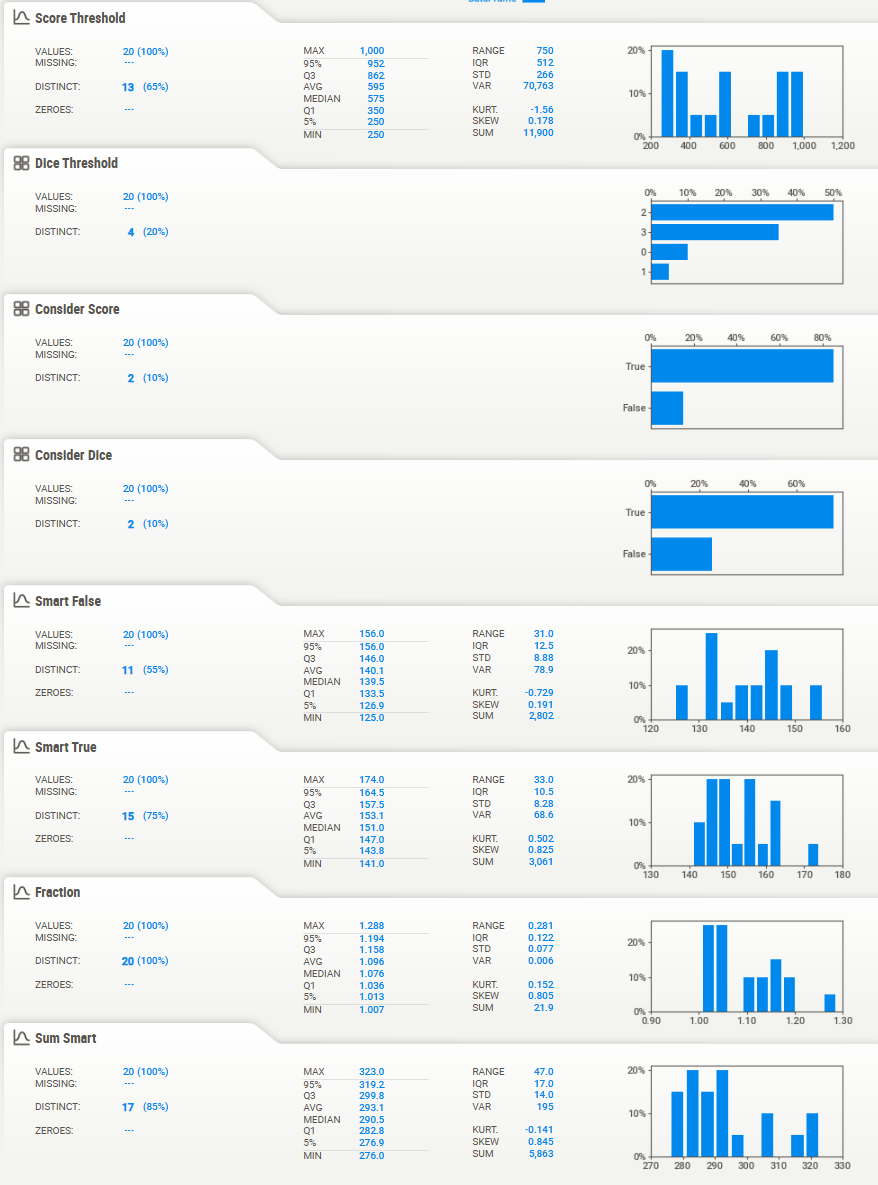

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open("Smart Better Wins Best Count.png")
display(img)

In [ ]:
best_smart_sorted_fraction

Score Threshold  Dice Threshold  Consider Score  Consider Dice  \
16               100               3            True           True   
31               200               2            True           True   
7                100               0            True          False   
123              700               2           False          False   
170              950               3           False          False   
64               350               3           False          False   
41               250               1            True          False   
159              900               2            True          False   
104              550               3           False          False   
176             1000               1            True           True   
77               400               4           False           True   
73               400               3           False          False   
45               250               3           False          False   
14               100               2            True           True   
175             1000               0            True          False   
140              800               2            True          False   
116              650               2           False          False   
125              700               3           False          False   
167              950               2           False          False   
178             1000               3           False          False   

     Smart False  Smart True  Fraction  Sum Smart  
16            74         105  1.418919        179  
31           106         149  1.405660        255  
7             78         109  1.397436        187  
123           64          89  1.390625        153  
170           69          92  1.333333        161  
64            68          88  1.294118        156  
41           125         161  1.288000        286  
159           73          93  1.273973        166  
104           66          84  1.272727        150  
176          108         137  1.268519        245  
77            90         114  1.266667        204  
73            76          96  1.263158        172  
45            73          91  1.246575        164  
14            94         115  1.223404        209  
175           68          83  1.220588        151  
140           82         100  1.219512        182  
116           74          90  1.216216        164  
125           71          86  1.211268        157  
167           81          98  1.209877        179  
178           82          99  1.207317        181

In [ ]:
my_report = sv.analyze(best_smart_sorted_fraction)
my_report.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


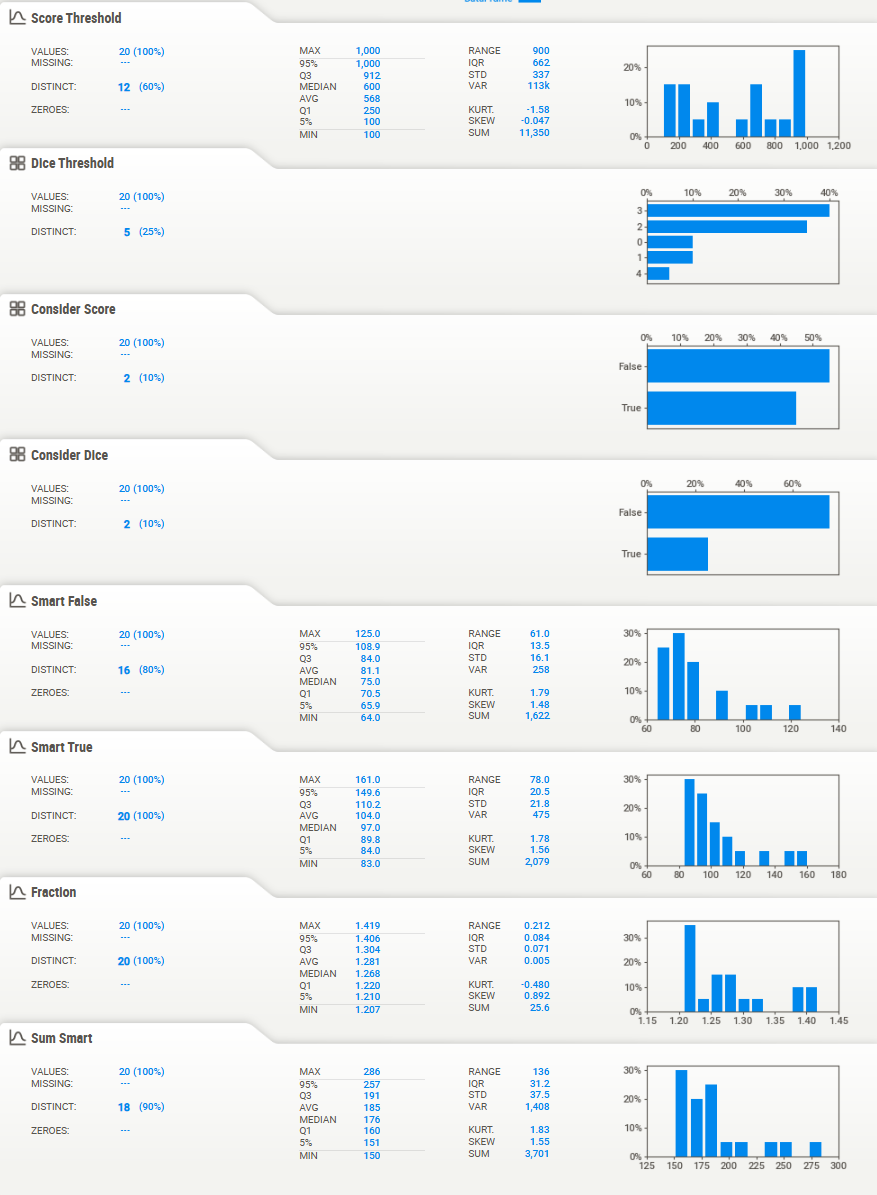

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open("Smart Better Wins Best Ratio.png")
display(img)

When 'Smart = True' outperformed 'Smart = False', across all wins, 'Consider Score = True' continued to be better than 'Consider Score = False'.  Consider Dice ended up narrowly favoring False instead of True.  Visually, dice count and score don't have much of a pattern across all wins.  The best Dice Threshold was 4, then 2, then 3 but they are fairly close in number.  If anything, the Dice Threshold of 4 being more common might happen because the smart trigger throws a die back letting the Dice Threshold of 4 player keep rolling a bit more.

Looking at the most consistent times 'Smart = True' outperformed 'Smart = False' gave contradictory results.  I looked at two definitions of consistent: the top 20 strategies as determined by number of wins and the top 20 strategies as determined by T:F ratio.

For the top 20 strategies with the highest win counts, the best Score Threshold was 300 but largely distributed with no discernable pattern. The best Dice Threshold was 2.  Consider Score and Consider Dice strongly favor True.  It basically mirrors the results of the win counts for all strategies with more adherence to the Consider Score and Consider Dice being True.  That makes sense because the odds have to be offset by something given that 'Smart = True' performs slightly worse than 'Smart = False'.

For the top 20 strategies with the biggest ratio of counts of 'Smart = True' to 'Smart = False', 'Consider Score = False' and 'Consider Dice = False' were the best strategies.  That suggests that high T:F ratios for Smart are the result of random chance rather than any strategy leading to 'Smart = True' being the better option.

So TLDR, randomness dominates Farkle and that means sometimes 'Smart = True' will beat 'Smart = False' but generally, points in the hand are better than potential points on the table.

I'm adding this section long after the bulk of the project was complete.  It occurred to me that choosing 50 strategies was pretty arbitrary and the aggregate data recommended strategy has the 23rd most wins with 151.  The highest win count belongs to score threshold of 250, ignore dice count, and use smart rerolls with 174 total wins.  But 80,000 is a big number, so time for some hypothesis testing/confidence intervals!

In [18]:
import math
from scipy.stats import norm

'''
Treating Farkle Wins as Poisson Trials and constructing confidence intervals:

H0: Difference between counts is less than the interval suggesting counts do not significantly differ.

H1: Difference between counts is greater than the interval suggesting counts are significantly different
'''

# Expected count per event.
mean_count = 80000 / 800  # 100
max_count = 174
# Standard error for the difference between two independent Poisson counts:
se_diff = math.sqrt(mean_count + mean_count)  # sqrt(100 + 100) = sqrt(200)

p_ci = [0.25, 0.10, 0.05, 0.04, 0.03, 0.025, 0.02, 0.01]

for p in p_ci:
    # For a two-sided 99% confidence interval:
    z_value = norm.ppf(1 - p/2)  # approximately 2.576

    # Threshold difference needed:
    threshold_difference = z_value * se_diff
    interval_min = max_count - threshold_difference
    ci = (1 - p)*100
    print(f"Threshold difference for {ci}% confidence: {threshold_difference:.2f}")
    print(f"At count values greater than {interval_min:.2f}, the data suggest with {ci}% confidence that the count is not significantly different from the maximum observed count of {max_count}")
    print("\n")

Threshold difference for 75.0% confidence: 16.27
At count values greater than 157.73, the data suggest with 75.0% confidence that the count is not significantly different from the maximum observed count of 174


Threshold difference for 90.0% confidence: 23.26
At count values greater than 150.74, the data suggest with 90.0% confidence that the count is not significantly different from the maximum observed count of 174


Threshold difference for 95.0% confidence: 27.72
At count values greater than 146.28, the data suggest with 95.0% confidence that the count is not significantly different from the maximum observed count of 174


Threshold difference for 96.0% confidence: 29.04
At count values greater than 144.96, the data suggest with 96.0% confidence that the count is not significantly different from the maximum observed count of 174


Threshold difference for 97.0% confidence: 30.69
At count values greater than 143.31, the data suggest with 97.0% confidence that the count is not signi

Threshold difference for 75.0% confidence: 16.27

At count values greater than 157.73, the data suggest with 75.0% confidence that the count is not significantly different from the maximum observed count of 174


Threshold difference for 90.0% confidence: 23.26

At count values greater than 150.74, the data suggest with 90.0% confidence that the count is not significantly different from the maximum observed count of 174


Threshold difference for 95.0% confidence: 27.72

At count values greater than 146.28, the data suggest with 95.0% confidence that the count is not significantly different from the maximum observed count of 174


Threshold difference for 96.0% confidence: 29.04

At count values greater than 144.96, the data suggest with 96.0% confidence that the count is not significantly different from the maximum observed count of 174


Threshold difference for 97.0% confidence: 30.69

At count values greater than 143.31, the data suggest with 97.0% confidence that the count is not significantly different from the maximum observed count of 174


Threshold difference for 97.5% confidence: 31.70

At count values greater than 142.30, the data suggest with 97.5% confidence that the count is not significantly different from the maximum observed count of 174


Threshold difference for 98.0% confidence: 32.90

At count values greater than 141.10, the data suggest with 98.0% confidence that the count is not significantly different from the maximum observed count of 174


Threshold difference for 99.0% confidence: 36.43

At count values greater than 137.57, the data suggest with 99.0% confidence that the count is not significantly different from the maximum observed count of 174

The choice to look at the top 50 strategies by complete chance all fell within the 96% confidence interval suggesting that none of the observed top 50 counts differ from each other at a statistically significant amount.  I'll call it good enough rather than recalculate everything for some statistically significant count level.  The recommended strategy falls within the 90% confidence interval as well.

Now, back to graphs that are potentially interesting but not that useful.  Consider material after this point to be highly optional.

In [65]:
# Saving to CSV because using .head(50) is too temporary
output_file_path = 'top_50_strategies_weighted.csv' 
weighted_df.to_csv(output_file_path, index=False)

This adds the interaction terms back into the top 50 strategies dataframe.  Don't actually think it is useful because of probability of the strategy type overwhelming any increase or decrease in win percentage in the graph.  Instead we are using filters.

In [30]:
import pandas as pd
df = pd.read_csv('top_50_strategies.csv')
columns_to_convert = ['Consider Score', 'Consider Dice', 'Smart']
df[columns_to_convert] = df[columns_to_convert].astype(int)
print(df.head())

import itertools
a = 'Score Threshold'
b = 'Dice Threshold'
c = 'Consider Score'
d = 'Consider Dice'
e = 'Smart'
interaction_terms = [
    (c, d), #
    (c, e), #
    (c, d, e), #
    (a, c), # 
    (a, c, e), # 
    (b, d, e),  # 
]
df['Score_Dice_Threshold_Interaction'] = df['Score Threshold'] / (df['Dice Threshold'] + 1)  # high score and low dice is riskier so divide.  Add 1 to prevent divide by 0
for interaction in interaction_terms:
    interaction_term_name = '_x_'.join(interaction)
    df[interaction_term_name] = df[list(interaction)].prod(axis=1)

print(df.head())
print(df.columns.values.tolist())

   Score Threshold  Dice Threshold  Consider Score  Consider Dice  Smart
0              250               3               1              0      1
1              750               2               1              1      0
2              500               2               1              1      1
3              900               2               1              1      1
4             1000               2               1              1      0
   Score Threshold  Dice Threshold  Consider Score  Consider Dice  Smart  \
0              250               3               1              0      1   
1              750               2               1              1      0   
2              500               2               1              1      1   
3              900               2               1              1      1   
4             1000               2               1              1      0   

   Score_Dice_Threshold_Interaction  Consider Score_x_Consider Dice  \
0                         62.50000

In [31]:
output_file_path = 'top_50_strategies_w_interactions.csv' 
df.to_csv(output_file_path, index=False)

Updating plotter function to allow filtering

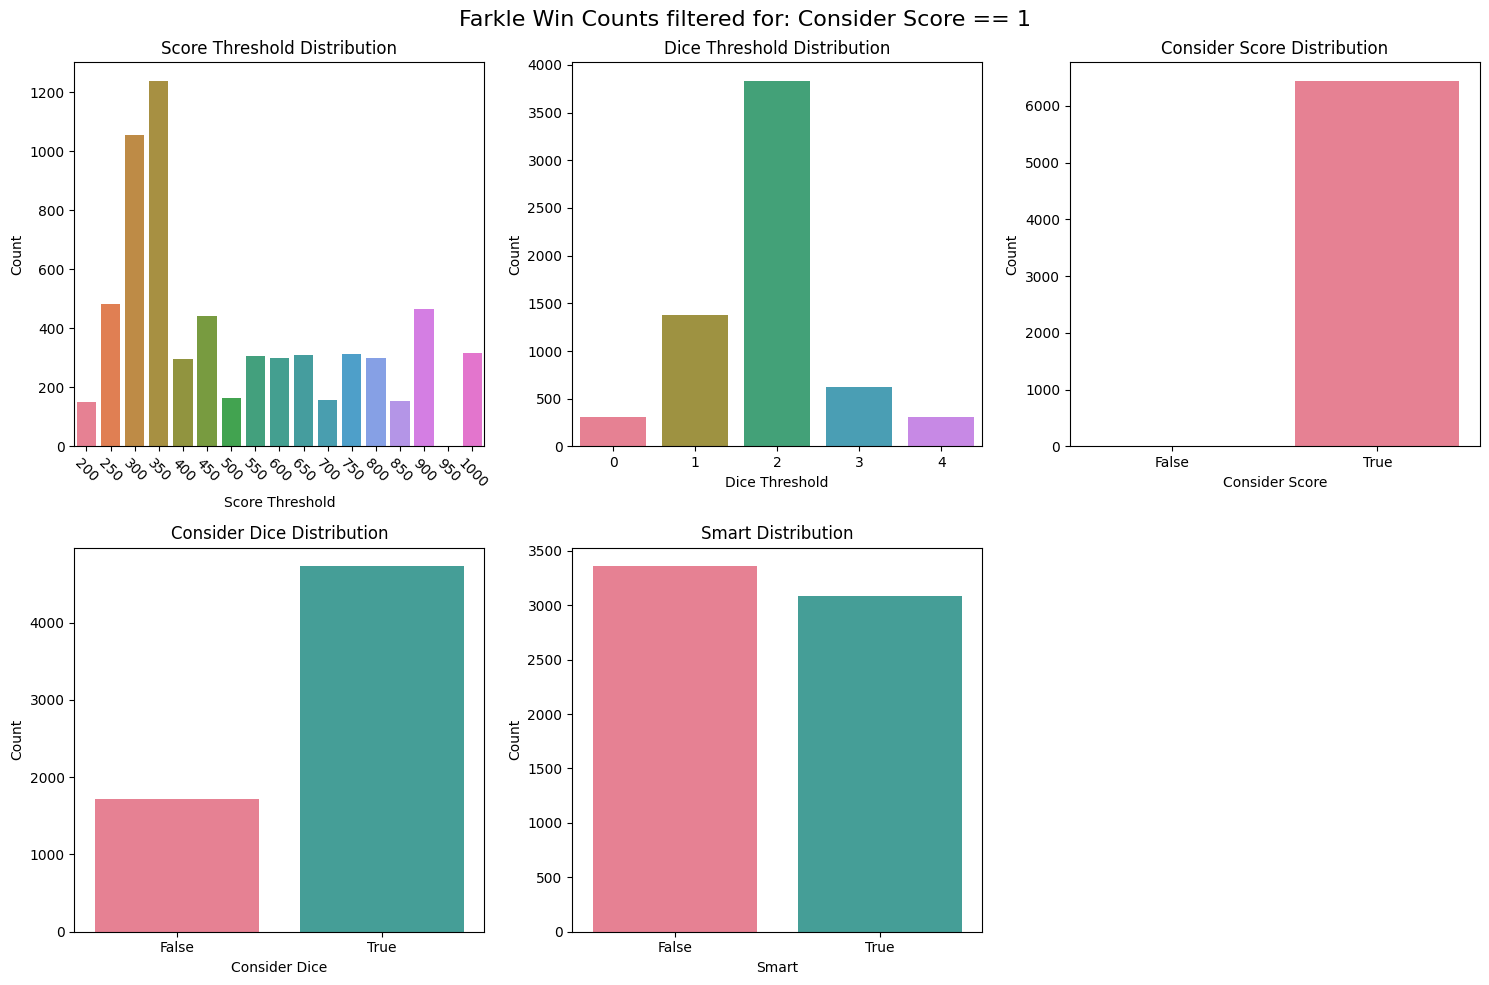

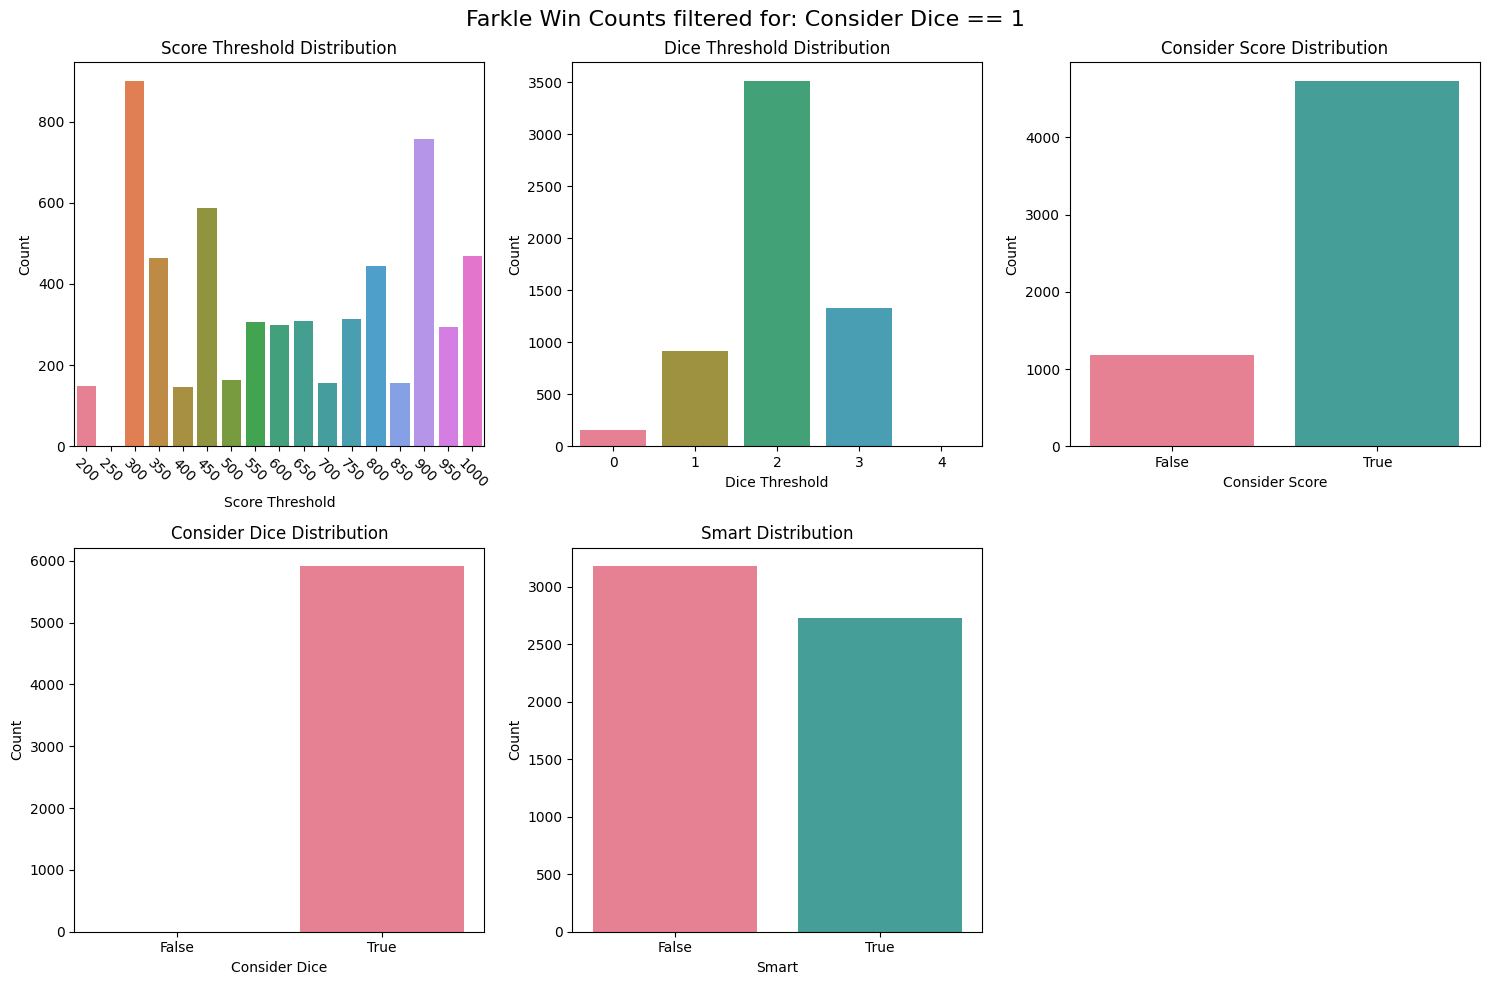

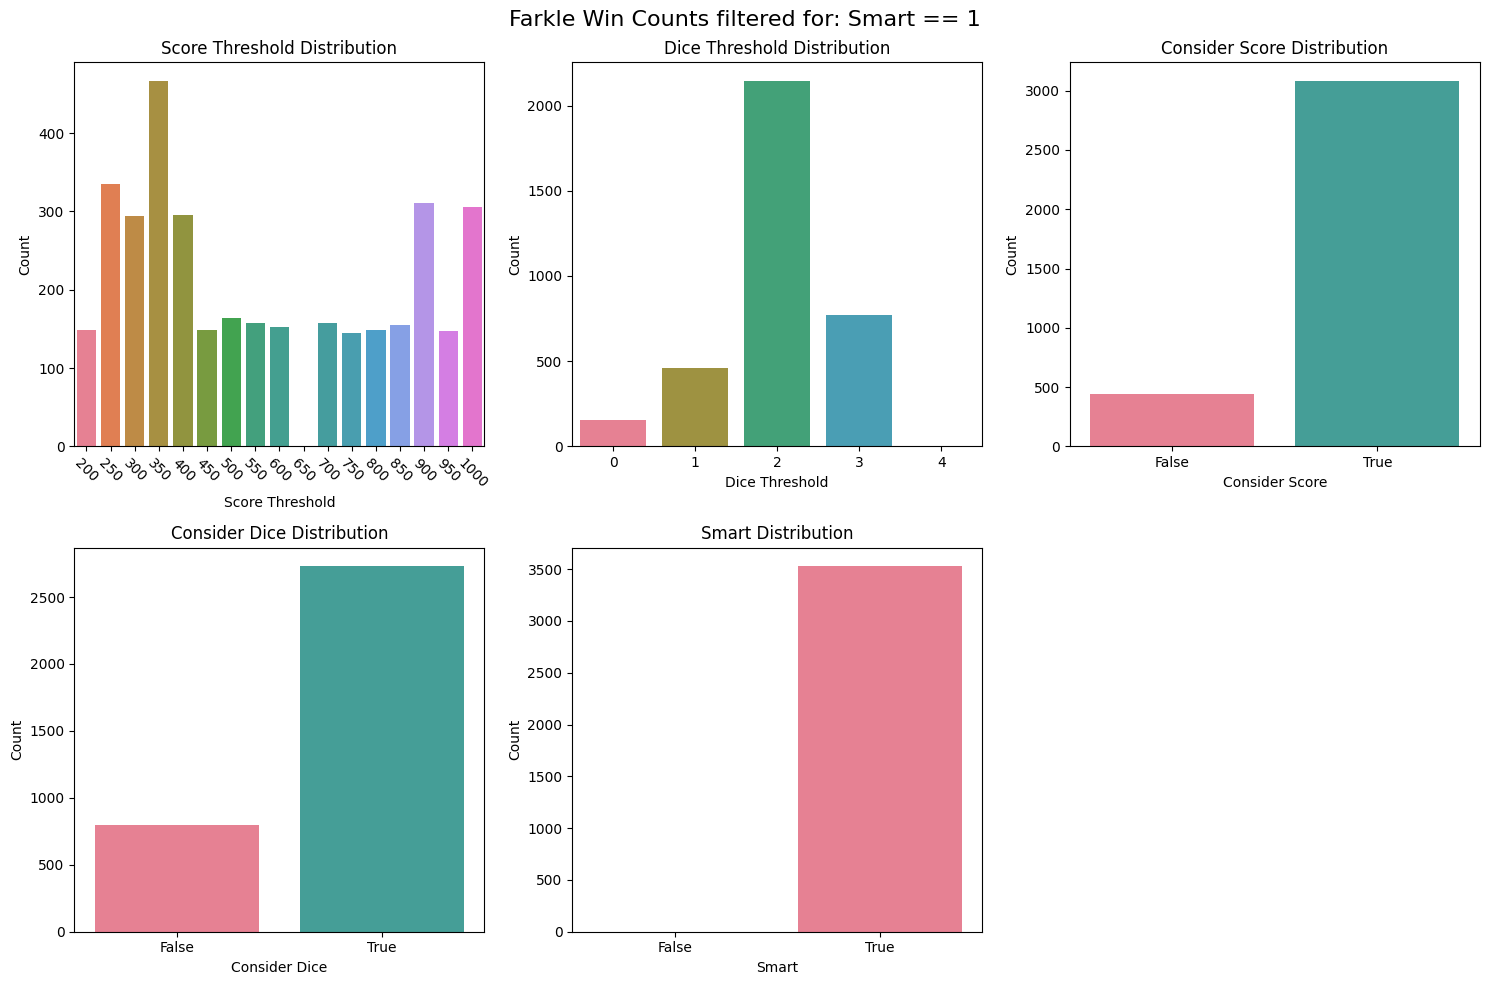

In [ ]:
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

def filtered_farkle_counts_plotter(df, column_names, filter_columns, filter_values, title_suffix):
    # Filter the DataFrame based on the given condition
    if not isinstance(filter_columns, list):
        lst_filter_columns = [filter_columns]
    else:
        lst_filter_columns = filter_columns

    if not isinstance(filter_values, list):
        lst_filter_values = [filter_values]
    else:
        lst_filter_values = filter_values
    if len(lst_filter_columns) != len(lst_filter_values):
        return print('Number of filter_columns does not match number of filter_values')
    else:
        df_filters = []
        for i in range(len(lst_filter_columns)):
            df_filters.append((df[lst_filter_columns[i]] == lst_filter_values[i]))
    combined_filter = reduce(lambda x, y: x & y, df_filters)
    filtered_df = df[combined_filter]
    
    # Determine global max count for setting a common y-axis limit
    global_max_count = 0
    for variable in column_names:
        counts = filtered_df[variable].value_counts()
        if not counts.empty:
            max_count = counts.max()
            if max_count > global_max_count:
                global_max_count = max_count

    # If no data matches the filter, global_max_count might be zero, handle gracefully
    if global_max_count == 0:
        global_max_count = 1
    
    # Set up the grid for plotting
    n_cols = 3
    n_rows = math.ceil(len(column_names)/n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    # Flatten axes array for easy indexing
    axes = axes.flatten()
    
    # Create bar plots for each variable
    for i, variable in enumerate(column_names):
        x=filtered_df[variable]
        all_categories = sorted(df[variable].unique())
        num_categories = x.nunique()
        palette = sns.color_palette('husl', len(all_categories))
        sns.countplot(x = x, ax = axes[i], hue = x, palette=palette[:num_categories], legend = False, order = all_categories)
        axes[i].set_title(f'{variable} Distribution')
        axes[i].set_xlabel(variable)
        axes[i].set_ylabel('Count')
        axes[i].set_ylim(0, global_max_count * 1.1)  # Add a little buffer
        if i == 0:
            axes[i].tick_params(axis='x', rotation=315)
    
    # Remove any empty subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle(f"Farkle Win Counts filtered for: {title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot grids for each condition
df = pd.read_csv('top_50_strategies_weighted.csv')
strategy_columns = ['Score Threshold', 'Dice Threshold', 'Consider Score', 'Consider Dice', 'Smart']
filtered_farkle_counts_plotter(df, strategy_columns, 'Consider Score', 1, 'Consider Score == 1')
filtered_farkle_counts_plotter(df, strategy_columns, 'Consider Dice', 1, 'Consider Dice == 1')
filtered_farkle_counts_plotter(df, strategy_columns, 'Smart', 1, 'Smart == 1')

The graphing function now accepts lists of variables and their values and constructs a descriptor for writing graph titles.  Now we need to list the combinations and values in the correct format.

In [2]:
from itertools import combinations

# List of variables
var_lst = [
    ('Consider Score', 1), 
    ('Consider Score', 0), 
    ('Consider Dice', 1), 
    ('Consider Dice', 0), 
    ('Smart', 1), 
    ('Smart', 0)
]

# Mutually exclusive pairs
mutual_exclusions = [
    (('Consider Score', 1), ('Consider Score', 0)),
    (('Consider Dice', 1), ('Consider Dice', 0)),
    (('Smart', 1), ('Smart', 0)),
]

# Function to check if a combination is valid
def is_valid_combination(combo, exclusions):
    flat_combo = set(combo)
    for exclusion in exclusions:
        # If all elements of an exclusion pair are in the combination, it's invalid
        if all(elem in flat_combo for elem in exclusion):
            return False
    return True

# Generate all combinations
three_combos = list(combinations(var_lst, 3))
two_combos = list(combinations(var_lst, 2))

# Combine and filter the combinations
all_combos = two_combos + three_combos
valid_combos = [combo for combo in all_combos if is_valid_combination(combo, mutual_exclusions)]



In [3]:
def filter_unpacker(tuple_of_tuples):
    variables = [i[0] for i in tuple_of_tuples]
    values = [i[1] for i in tuple_of_tuples]
    titles = ''
    for i in range(len(variables)):
        txt = f'{variables[i]} == {values[i]}, '
        titles += txt
    titles = titles[:-2]
    return [variables, values, titles]

In [4]:
def var_lst_setup(short_tuple):
    var_name = [short_tuple[0]]
    value = [short_tuple[1]]
    txt = f'{var_name} == {value[0]}'
    return [var_name, value, txt]

In [7]:
all_filters = [var_lst_setup(i) for i in var_lst] + [filter_unpacker(j) for j in valid_combos]
for k in all_filters:
    print(k)

[['Consider Score'], [1], "['Consider Score'] == 1"]
[['Consider Score'], [0], "['Consider Score'] == 0"]
[['Consider Dice'], [1], "['Consider Dice'] == 1"]
[['Consider Dice'], [0], "['Consider Dice'] == 0"]
[['Smart'], [1], "['Smart'] == 1"]
[['Smart'], [0], "['Smart'] == 0"]
[['Consider Score', 'Consider Dice'], [1, 1], 'Consider Score == 1, Consider Dice == 1']
[['Consider Score', 'Consider Dice'], [1, 0], 'Consider Score == 1, Consider Dice == 0']
[['Consider Score', 'Smart'], [1, 1], 'Consider Score == 1, Smart == 1']
[['Consider Score', 'Smart'], [1, 0], 'Consider Score == 1, Smart == 0']
[['Consider Score', 'Consider Dice'], [0, 1], 'Consider Score == 0, Consider Dice == 1']
[['Consider Score', 'Consider Dice'], [0, 0], 'Consider Score == 0, Consider Dice == 0']
[['Consider Score', 'Smart'], [0, 1], 'Consider Score == 0, Smart == 1']
[['Consider Score', 'Smart'], [0, 0], 'Consider Score == 0, Smart == 0']
[['Consider Dice', 'Smart'], [1, 1], 'Consider Dice == 1, Smart == 1']
[['

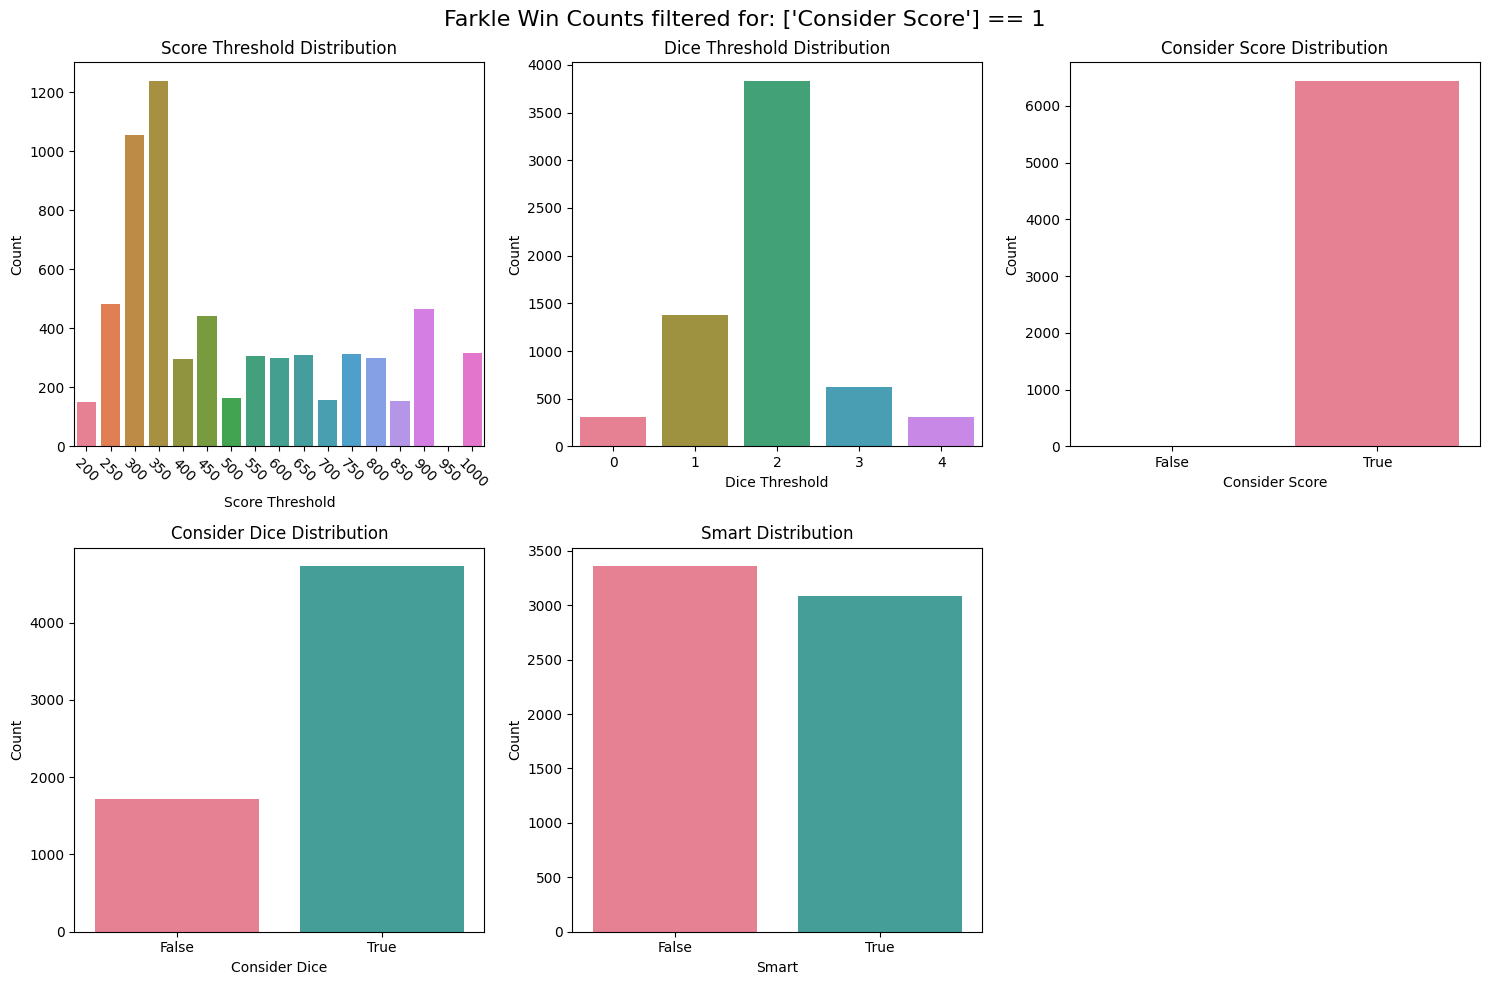

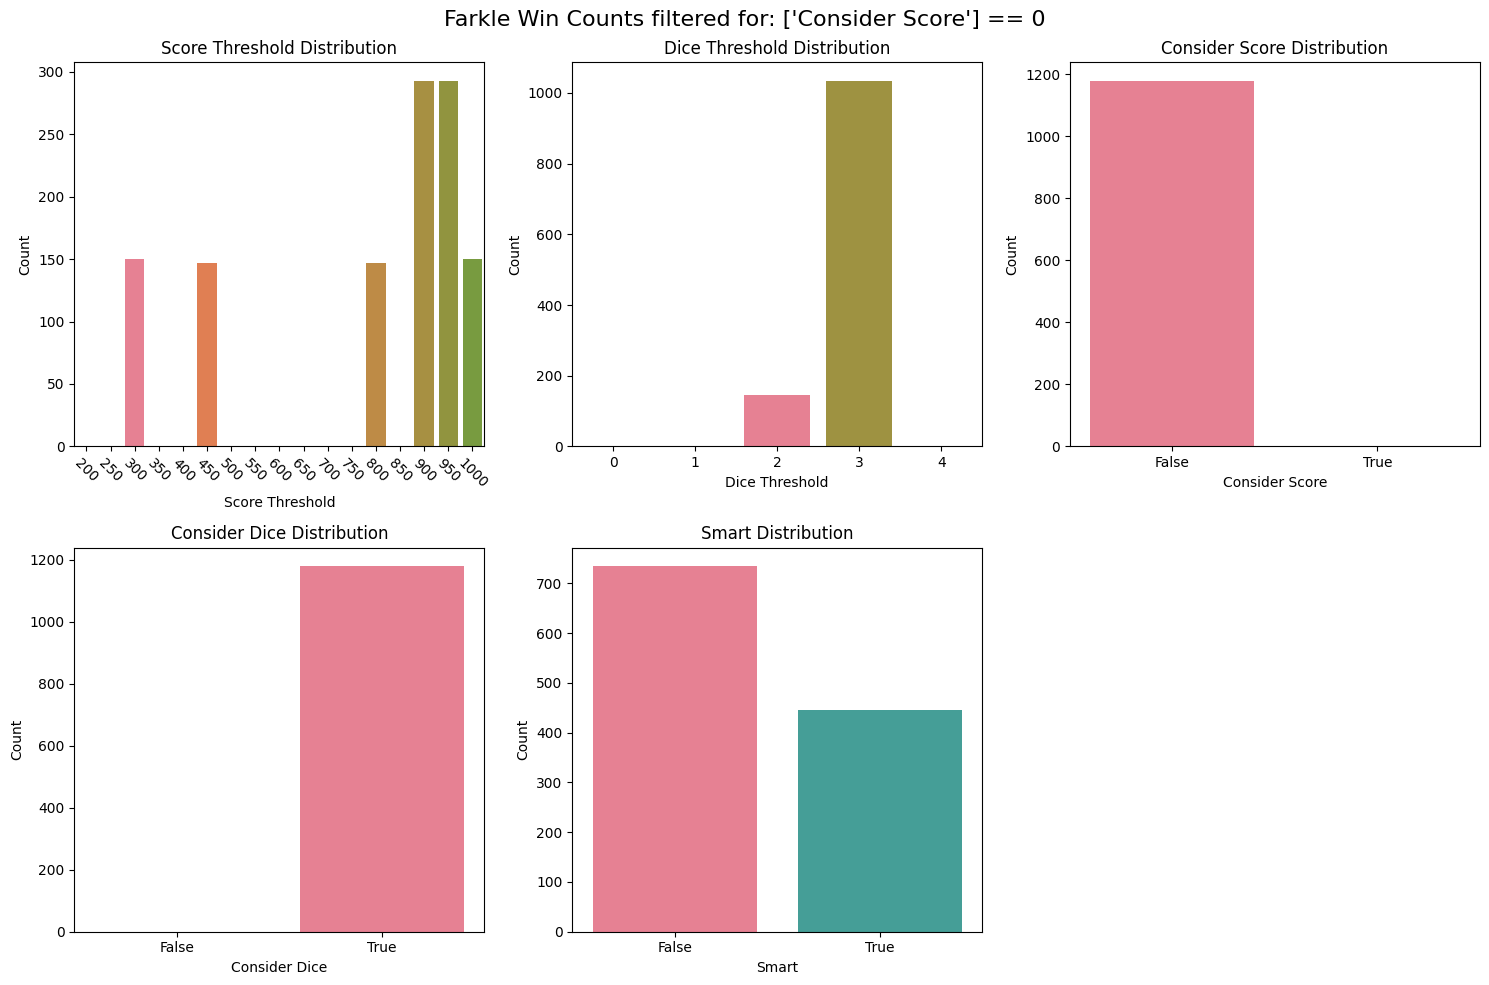

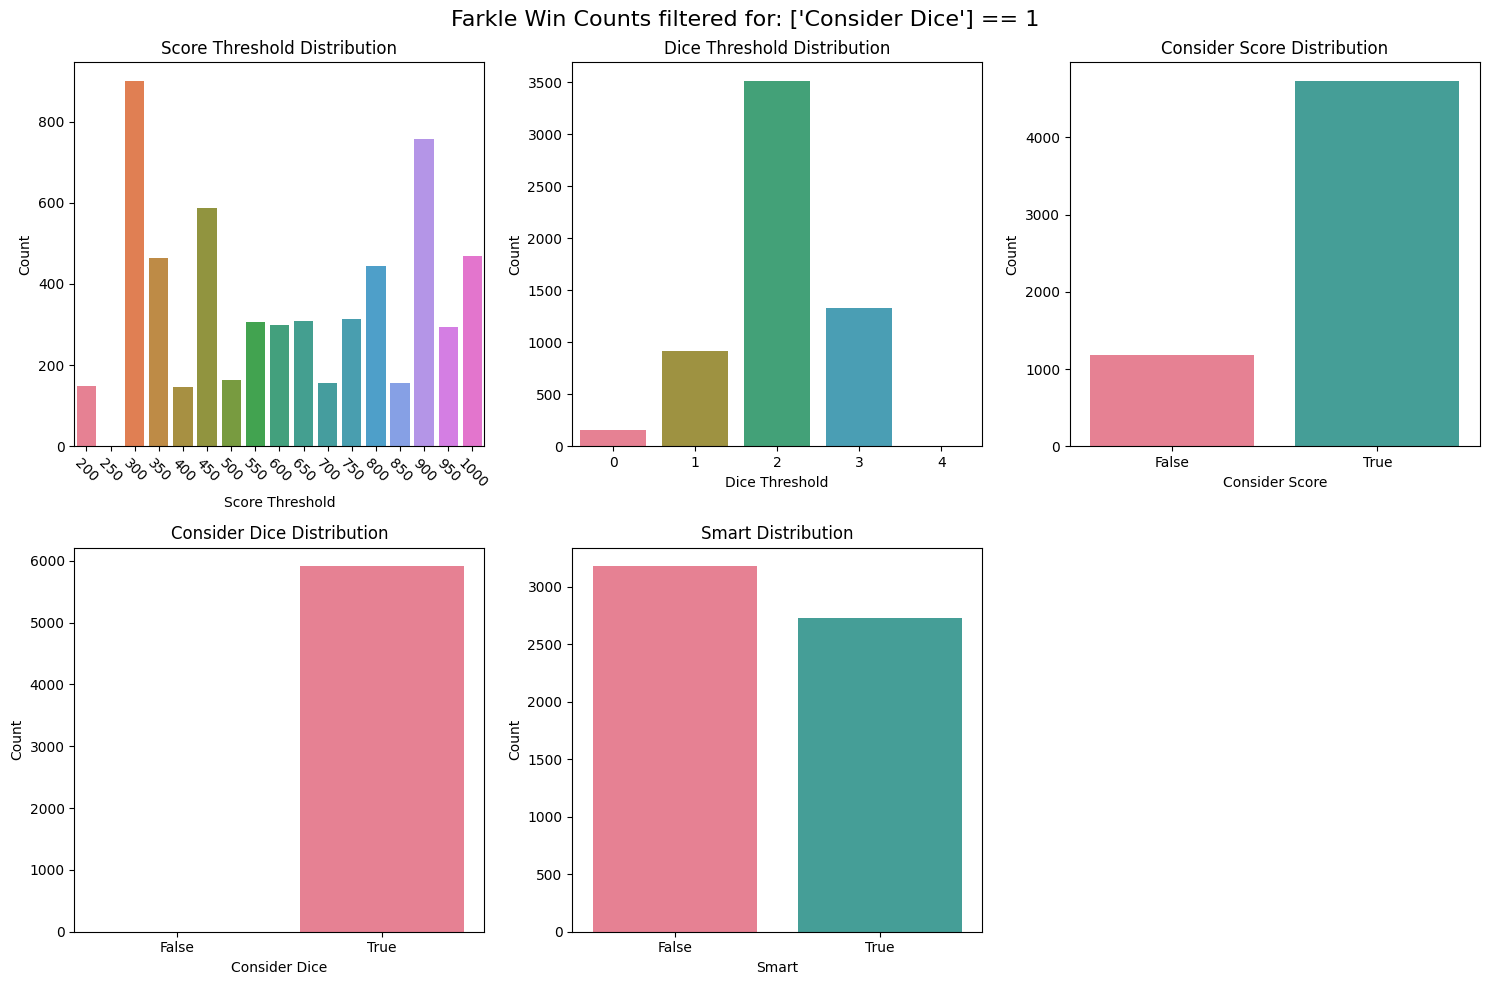

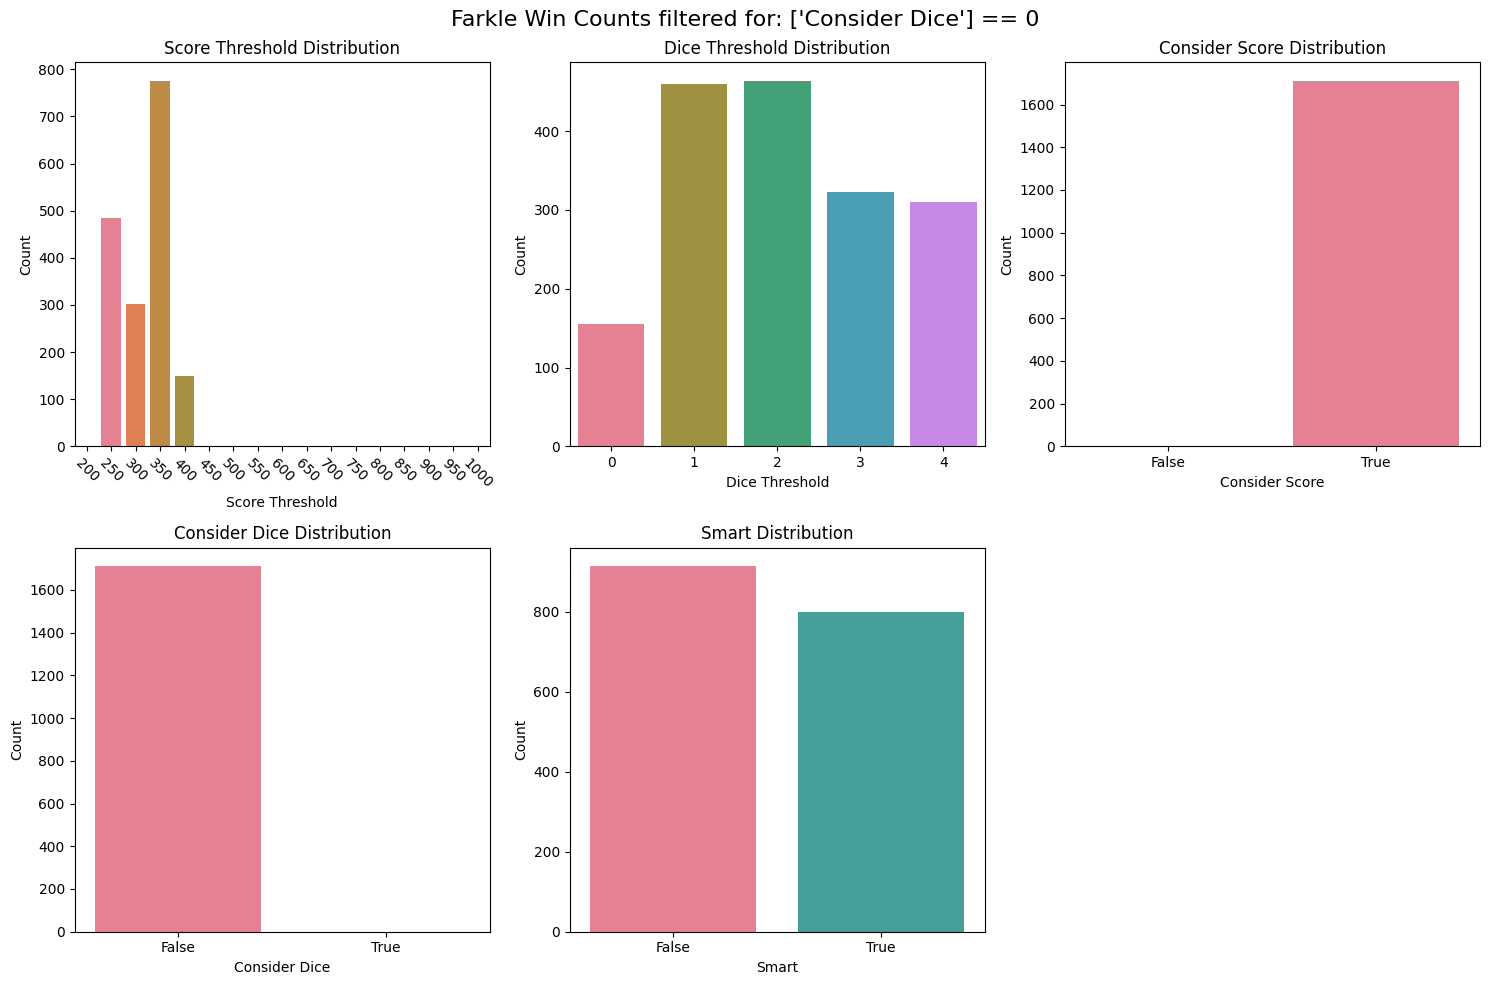

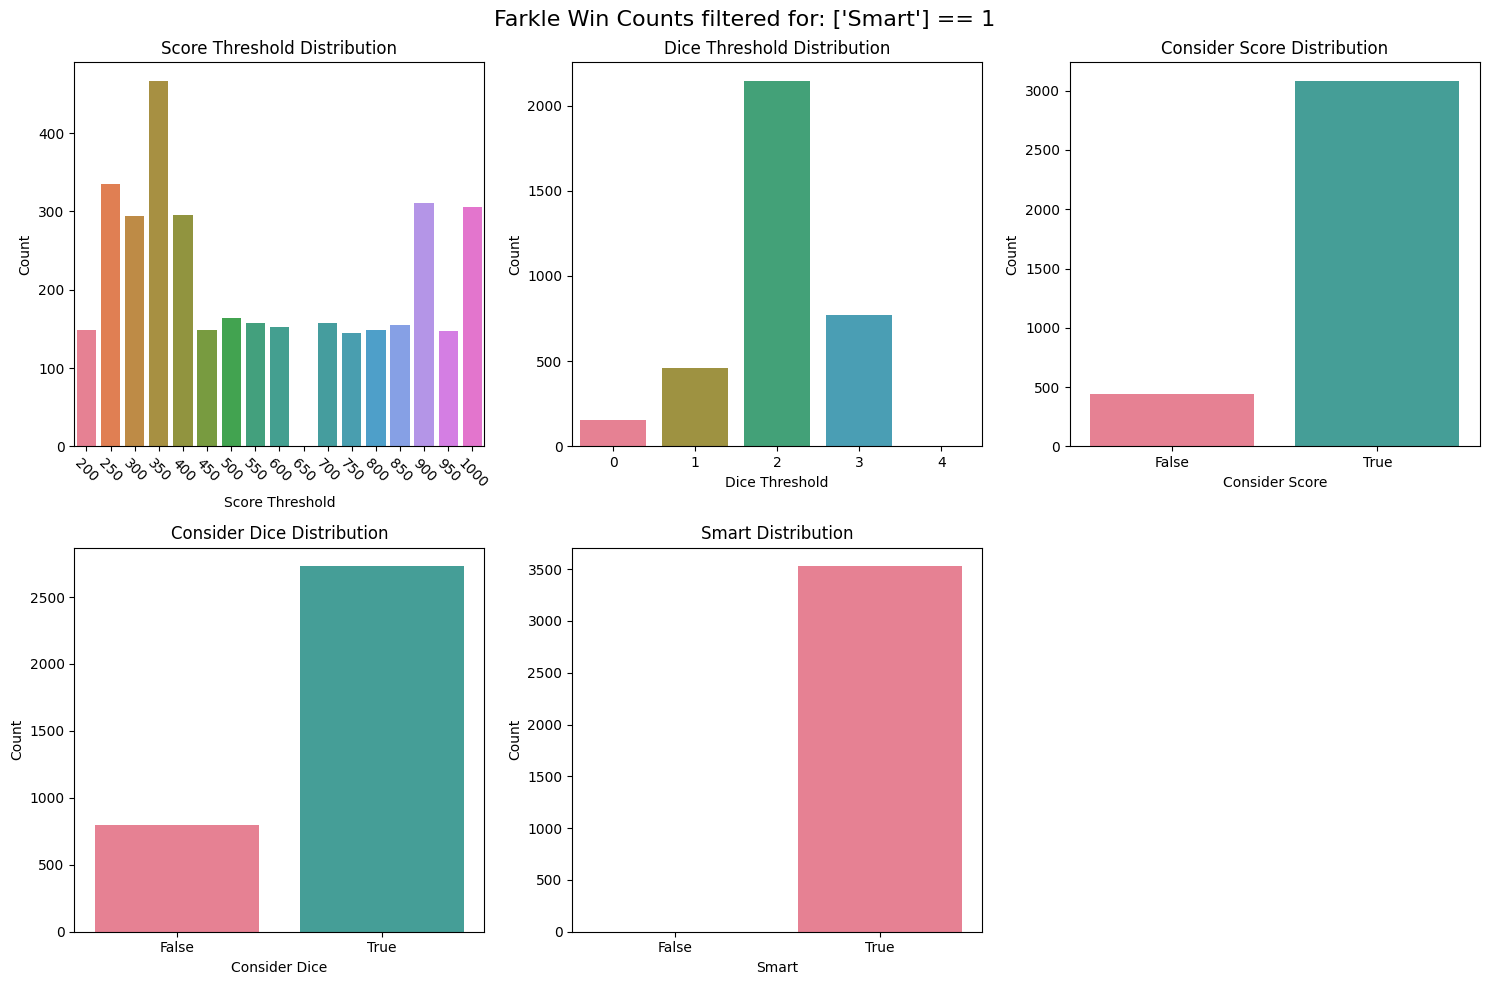

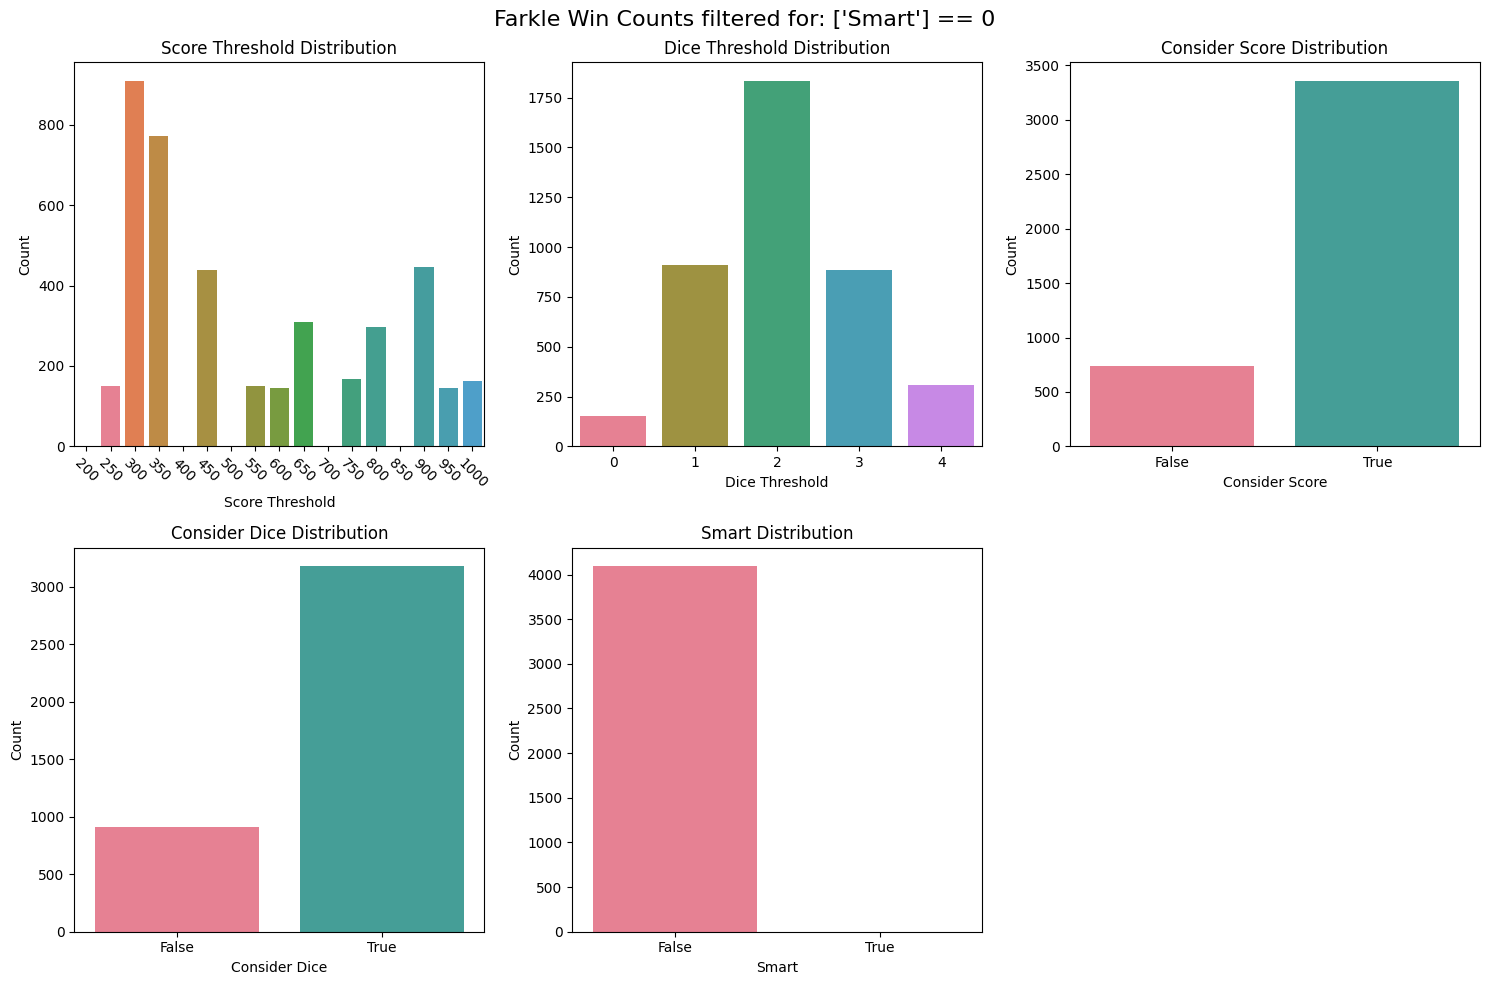

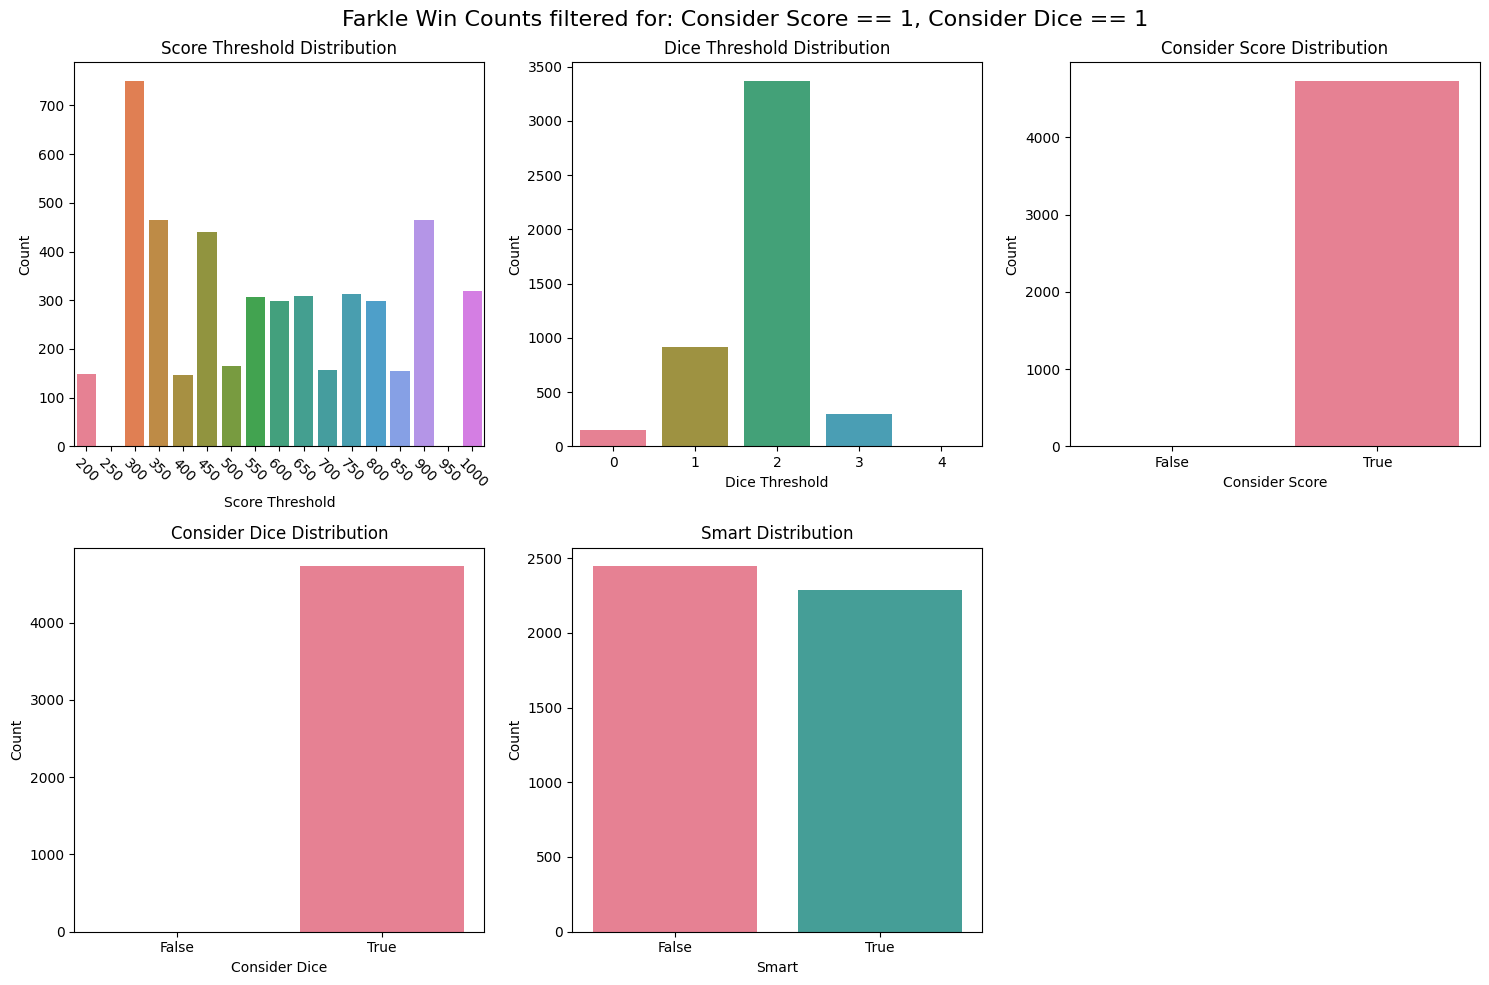

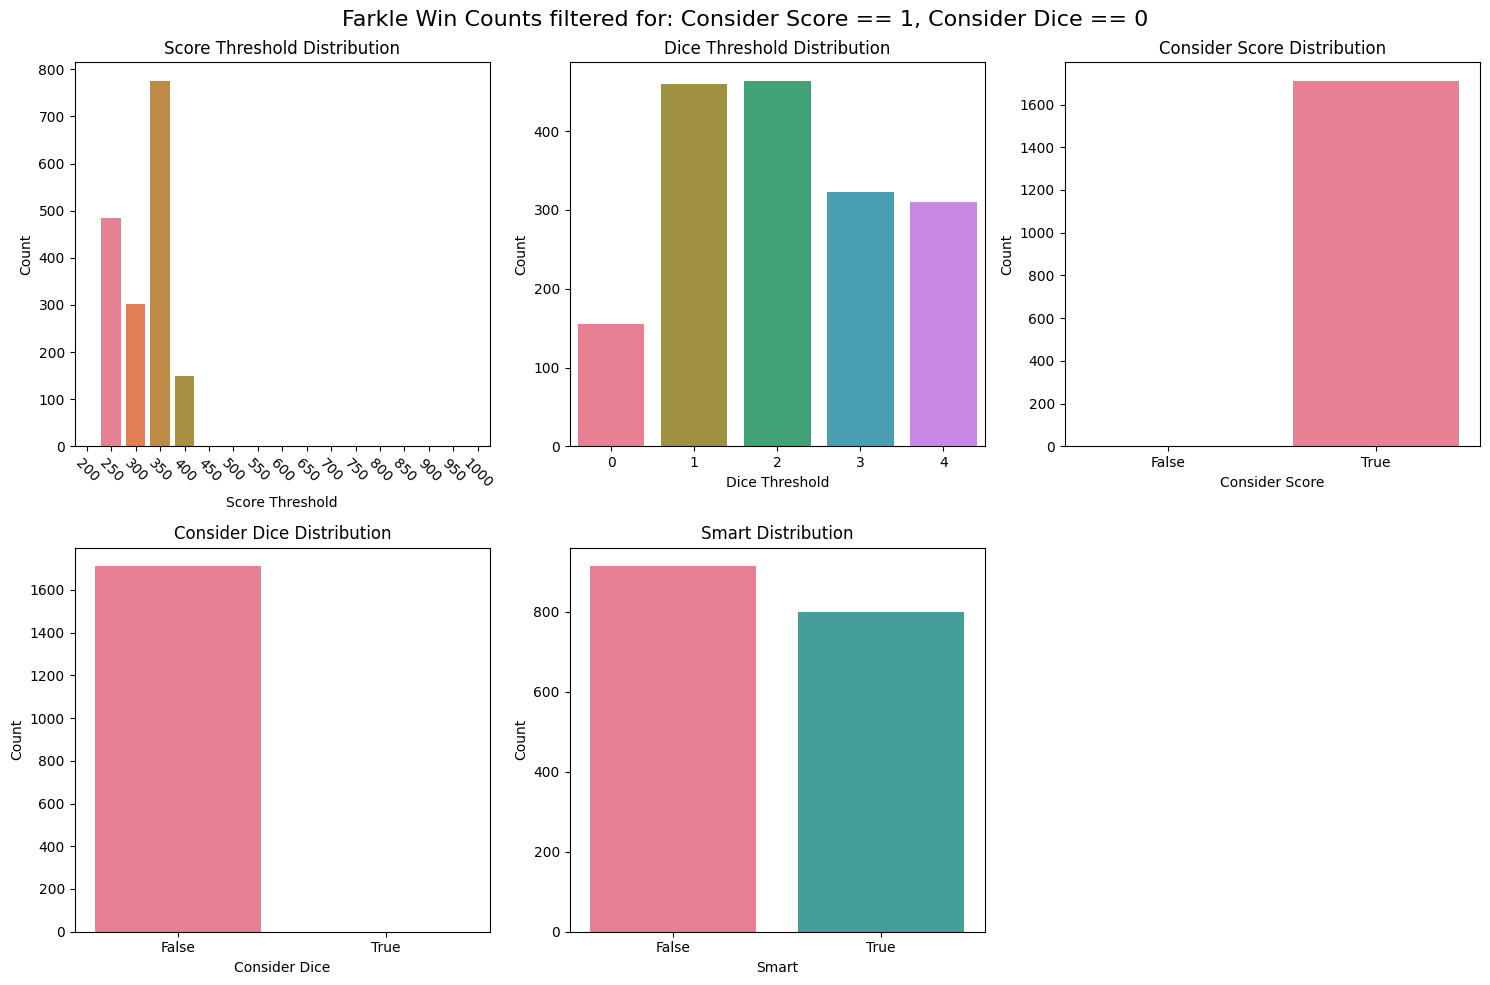

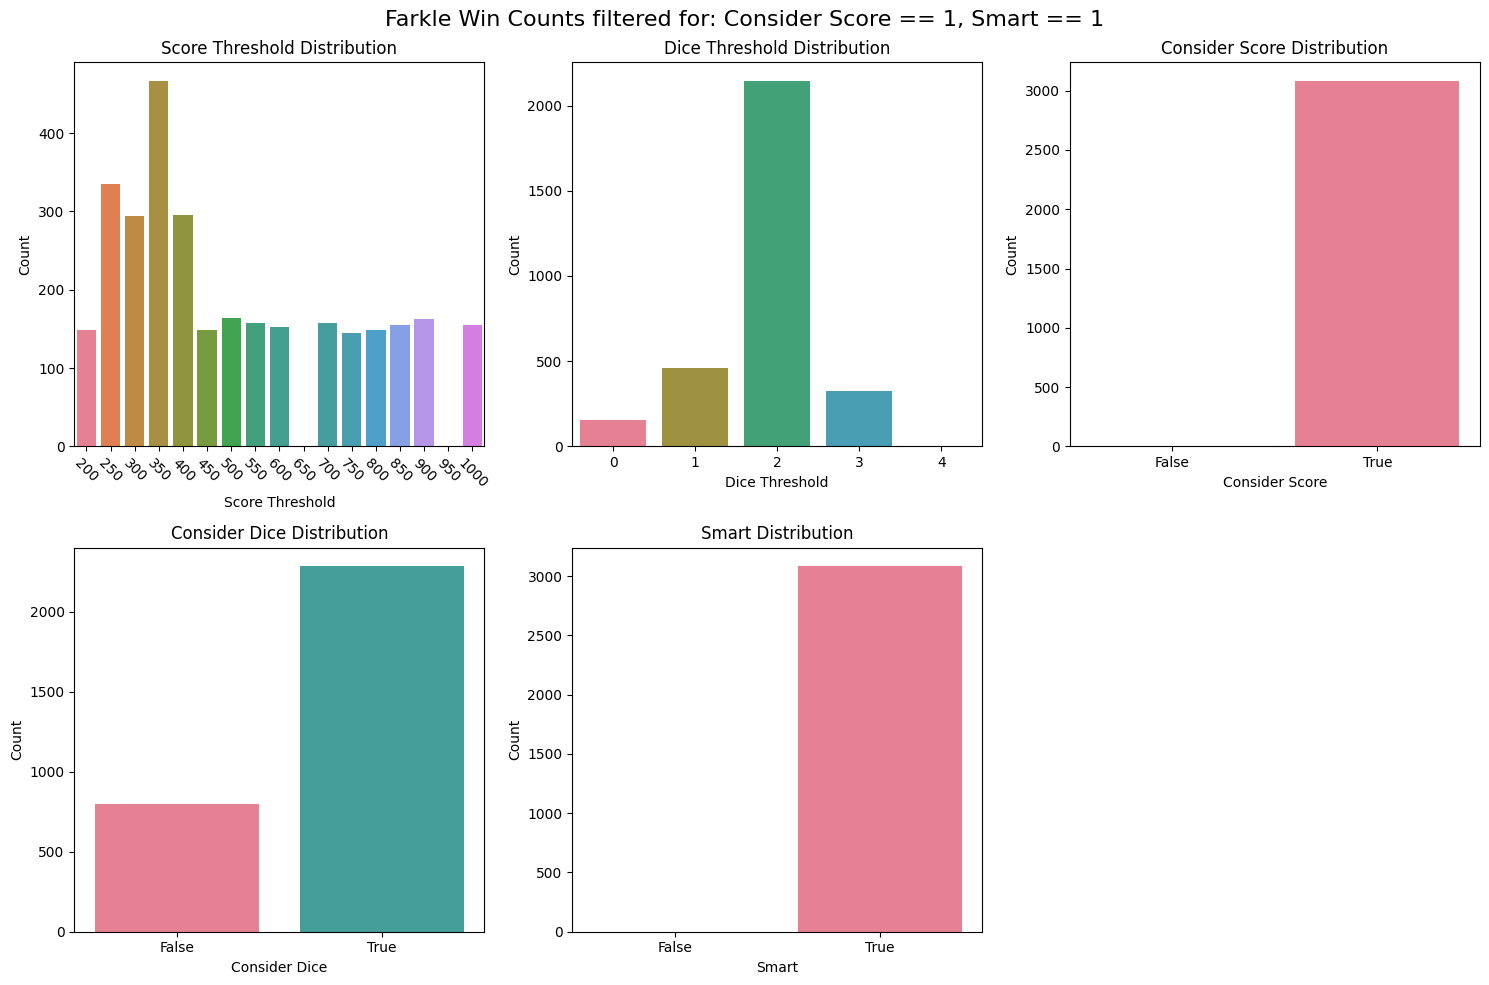

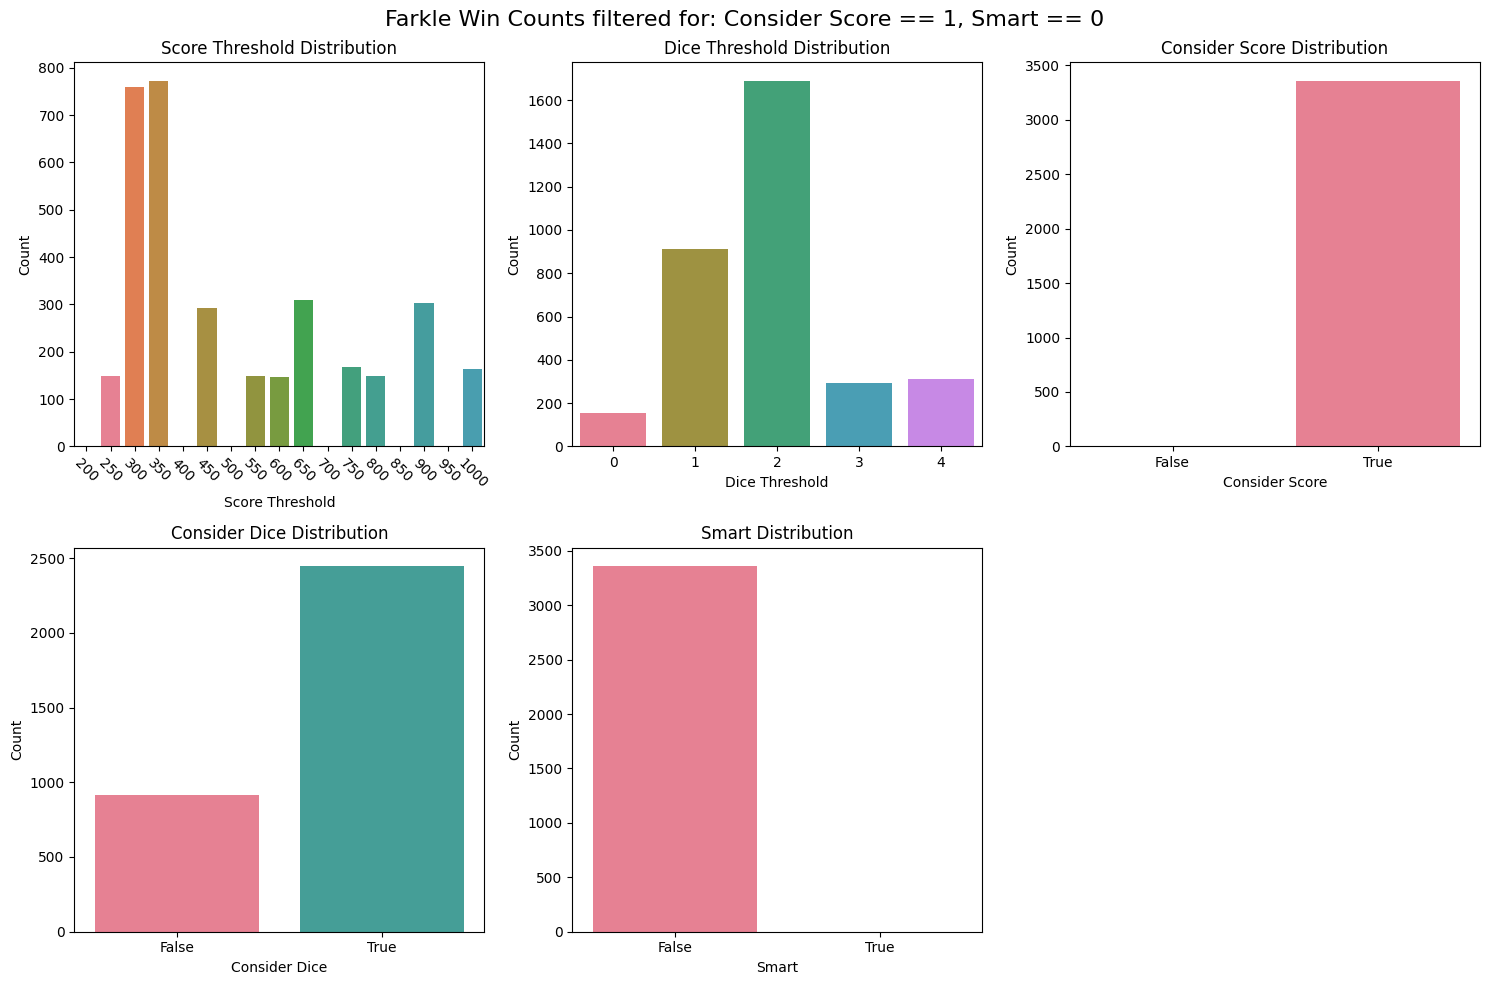

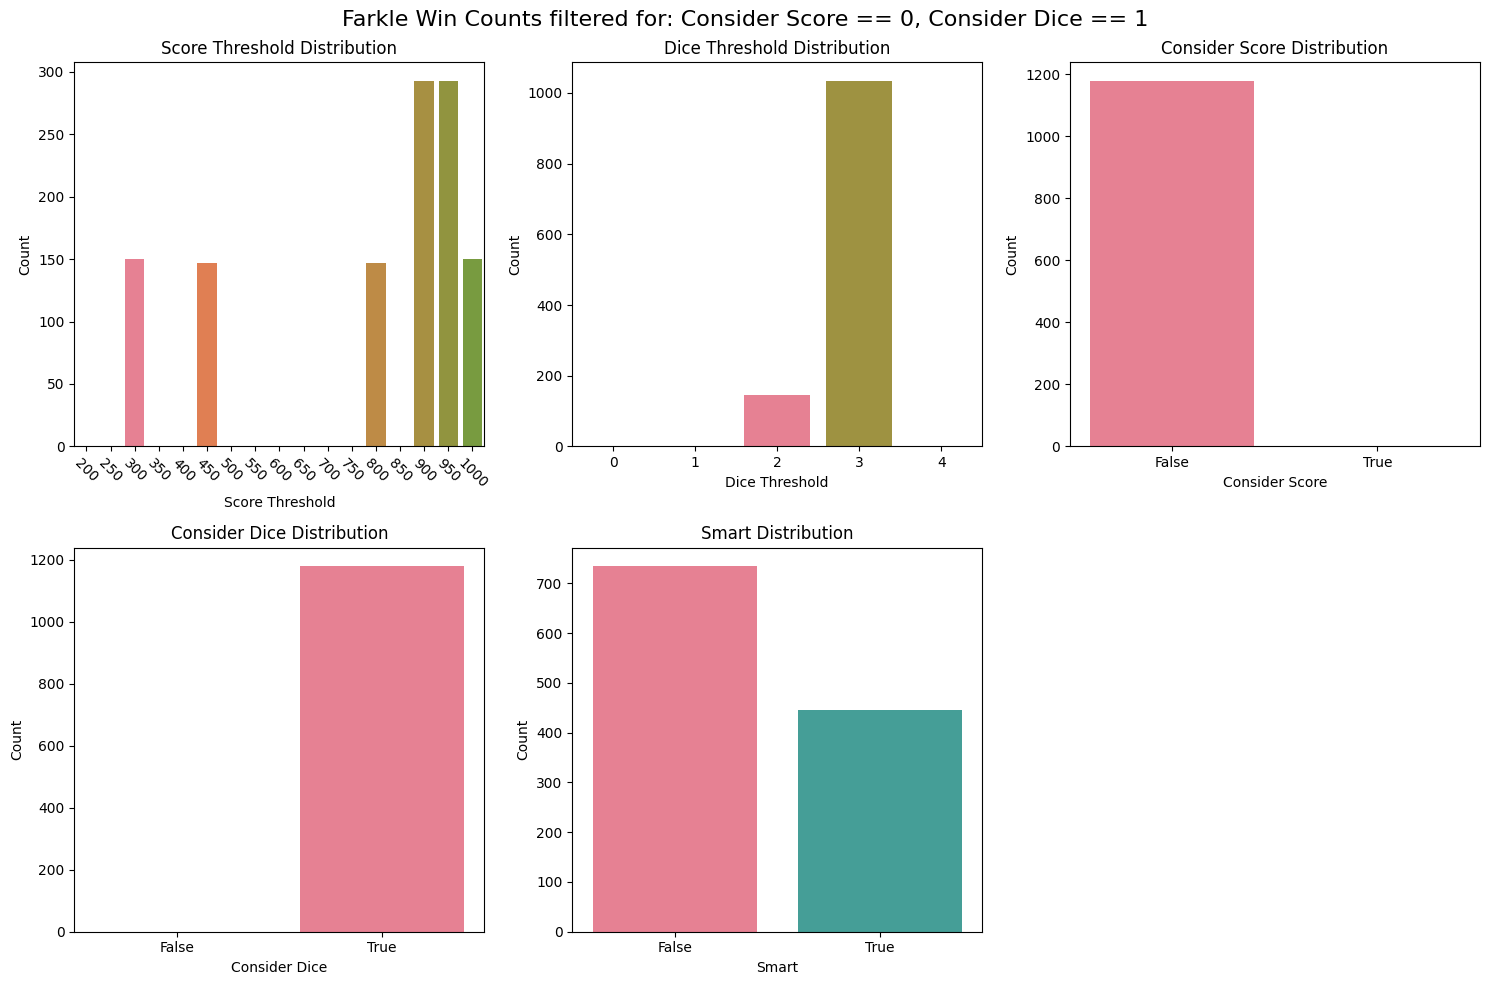

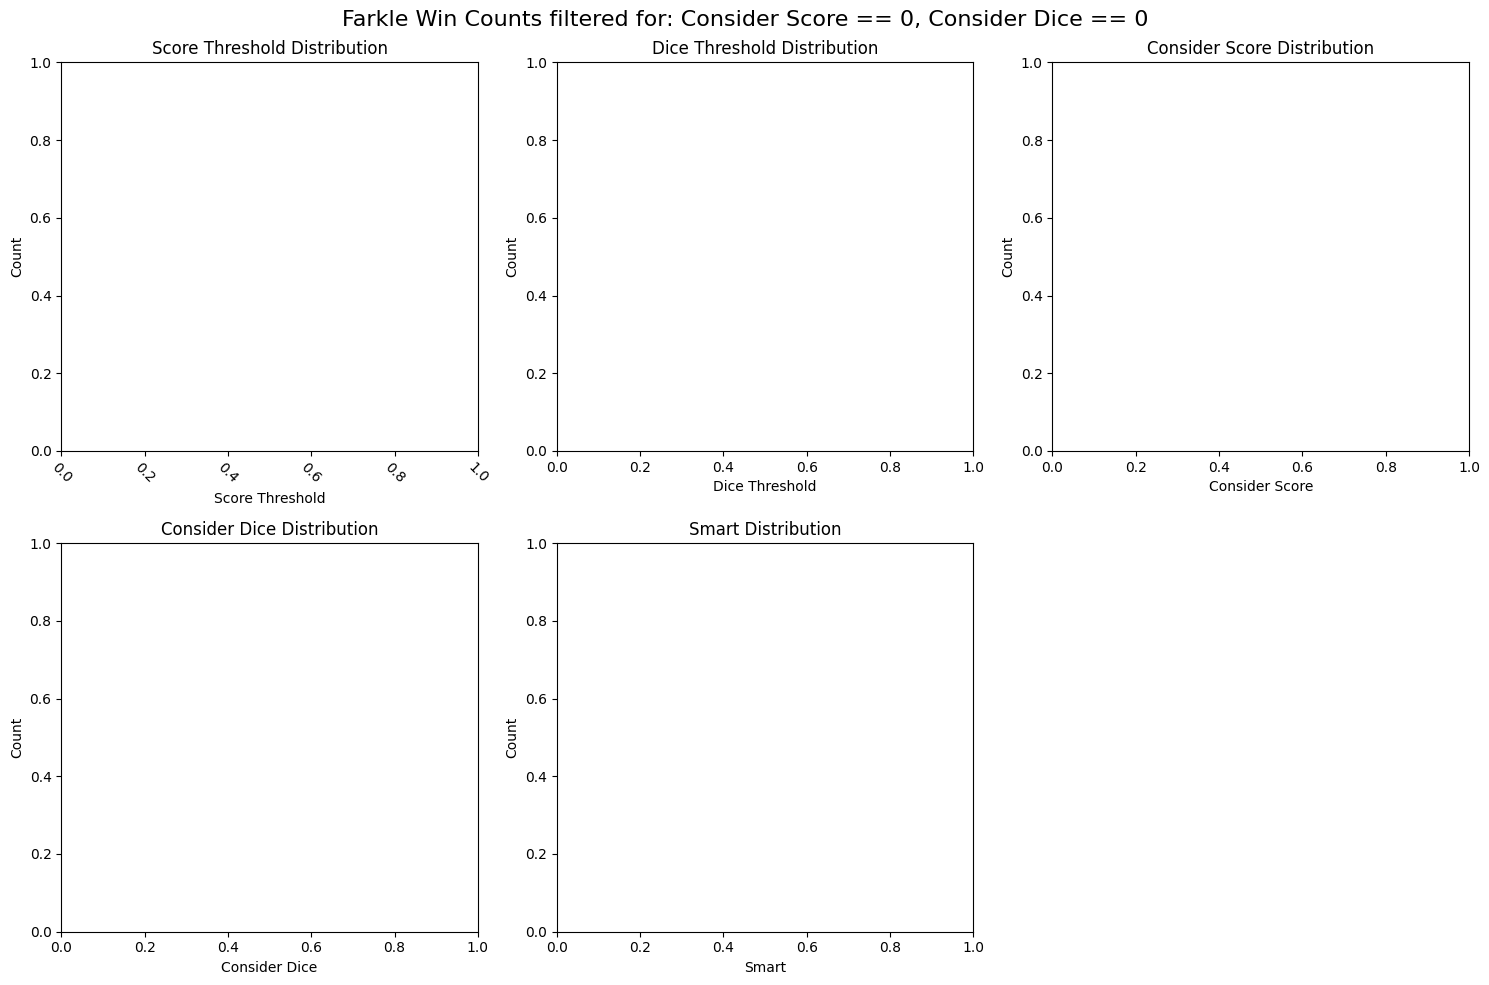

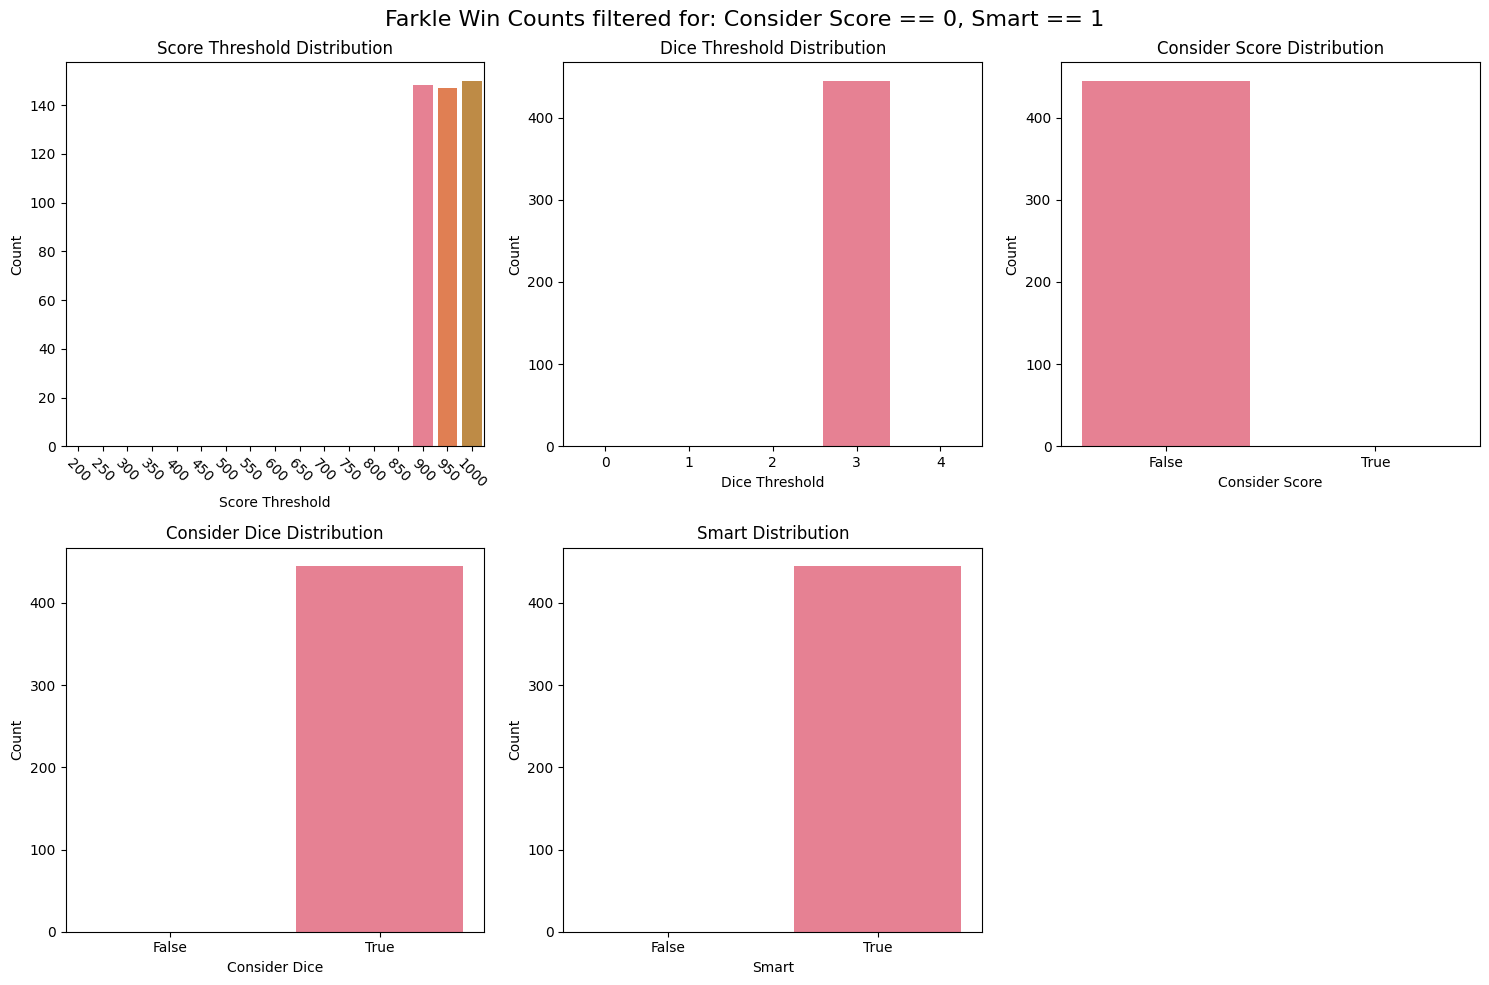

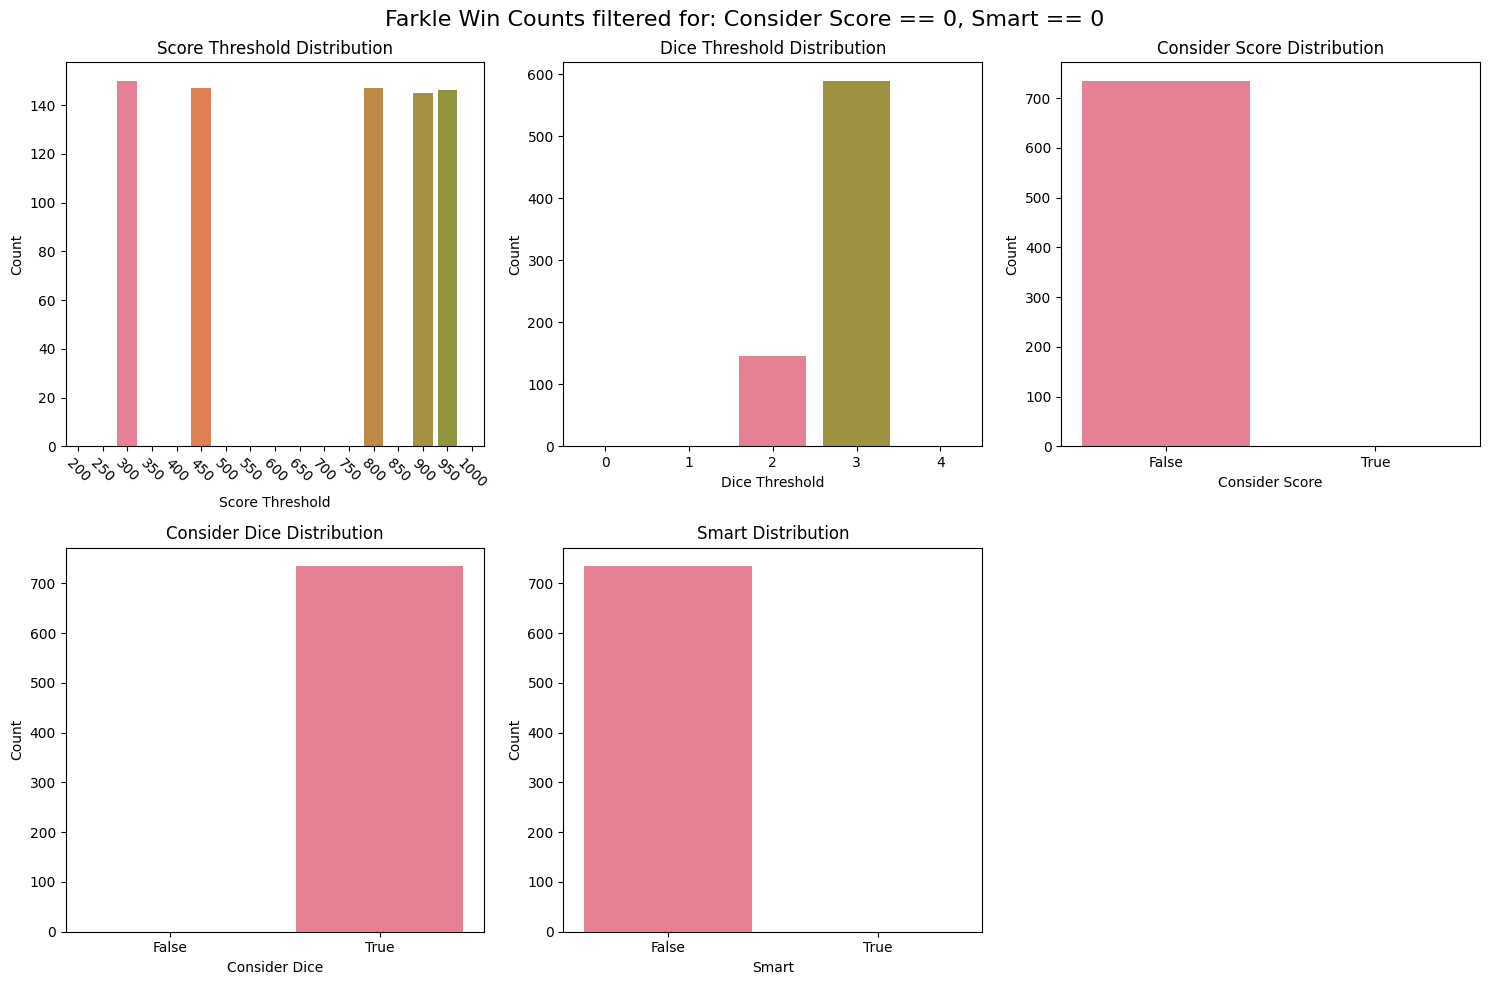

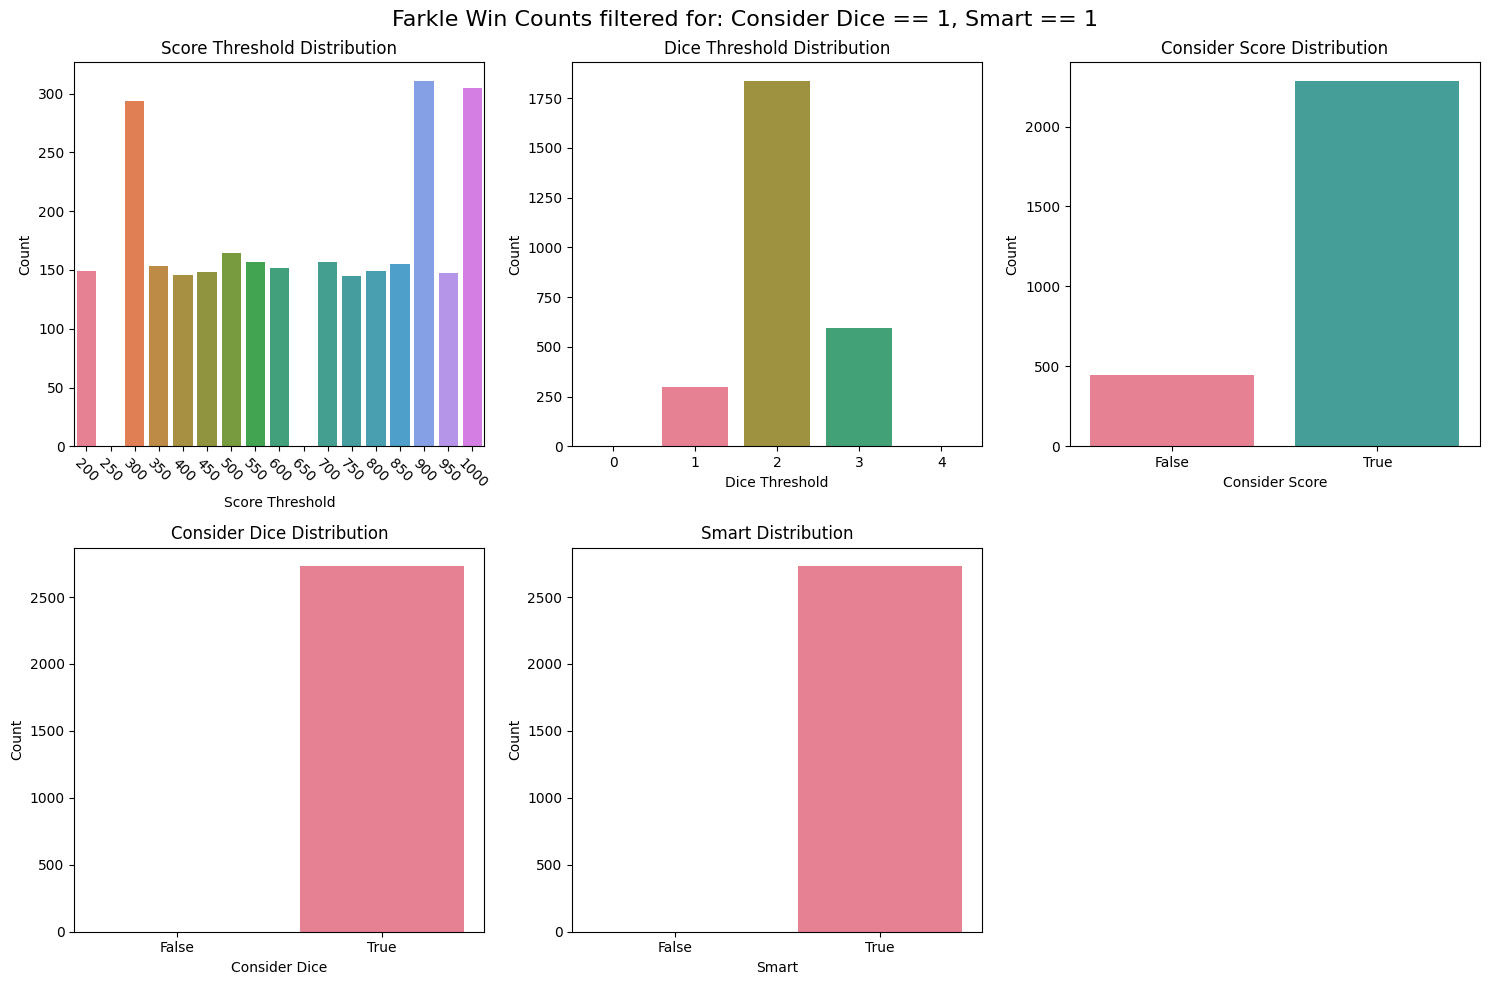

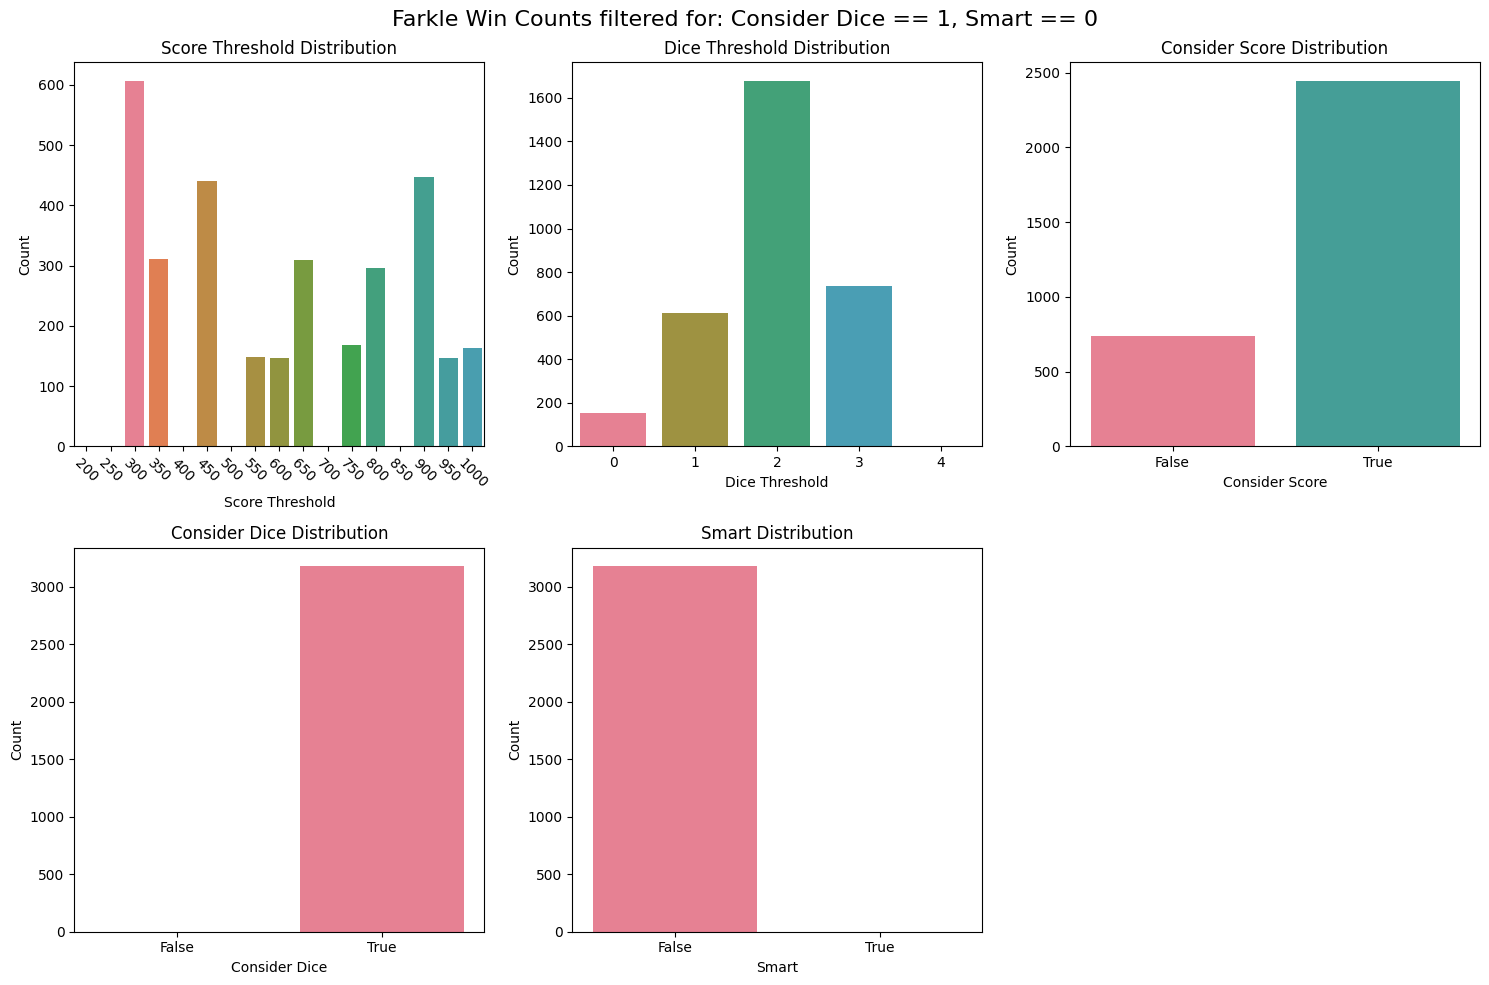

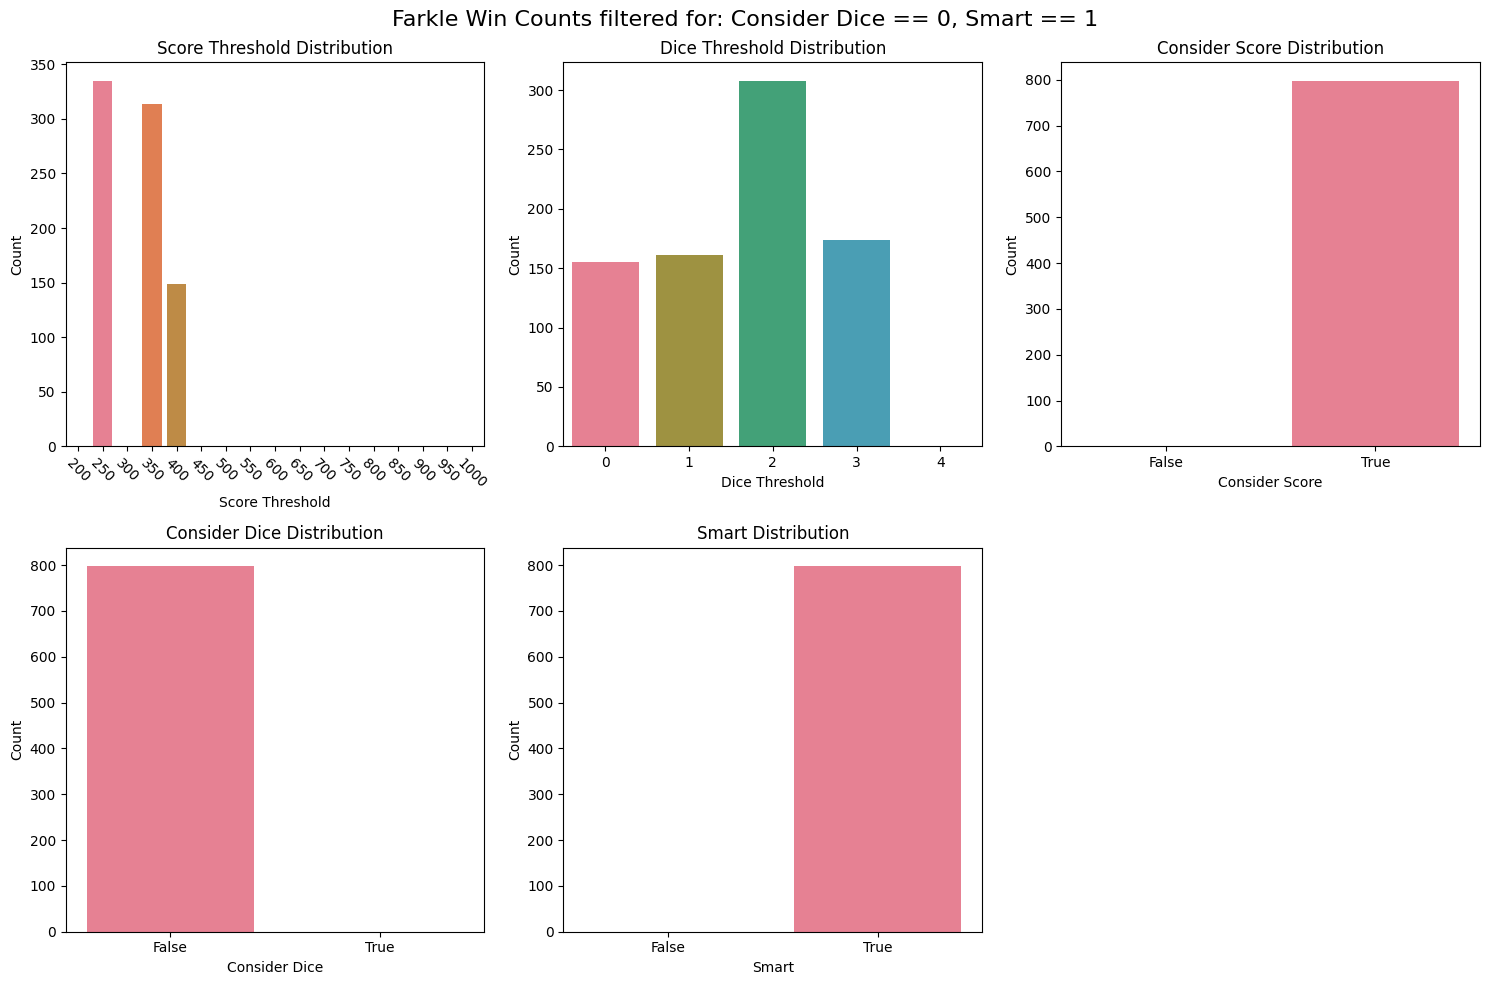

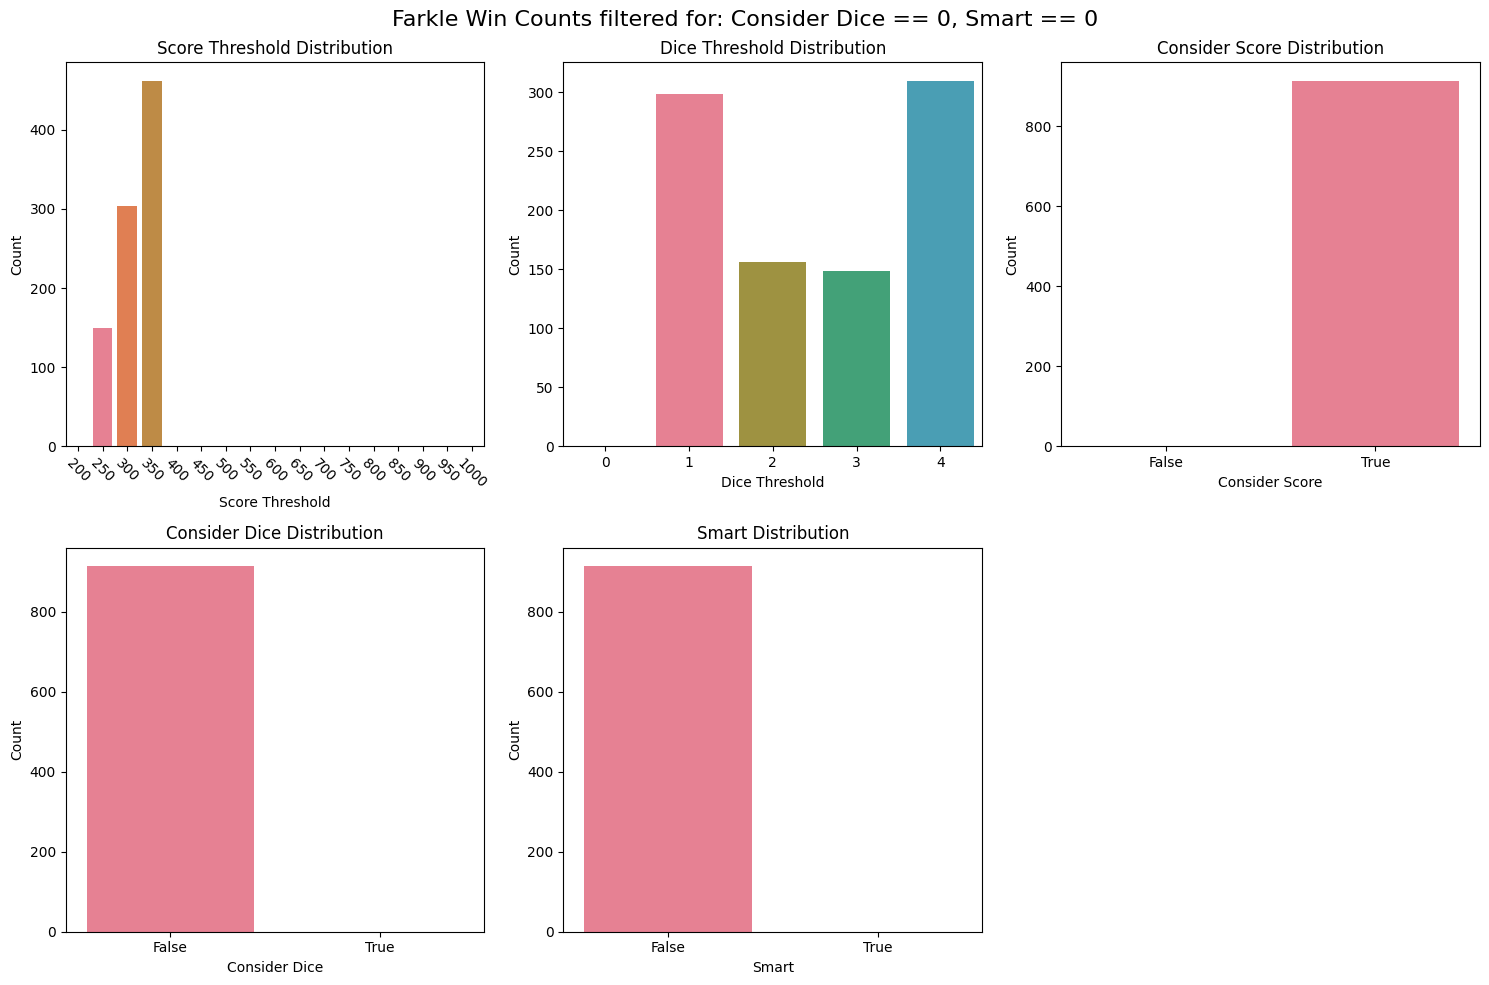

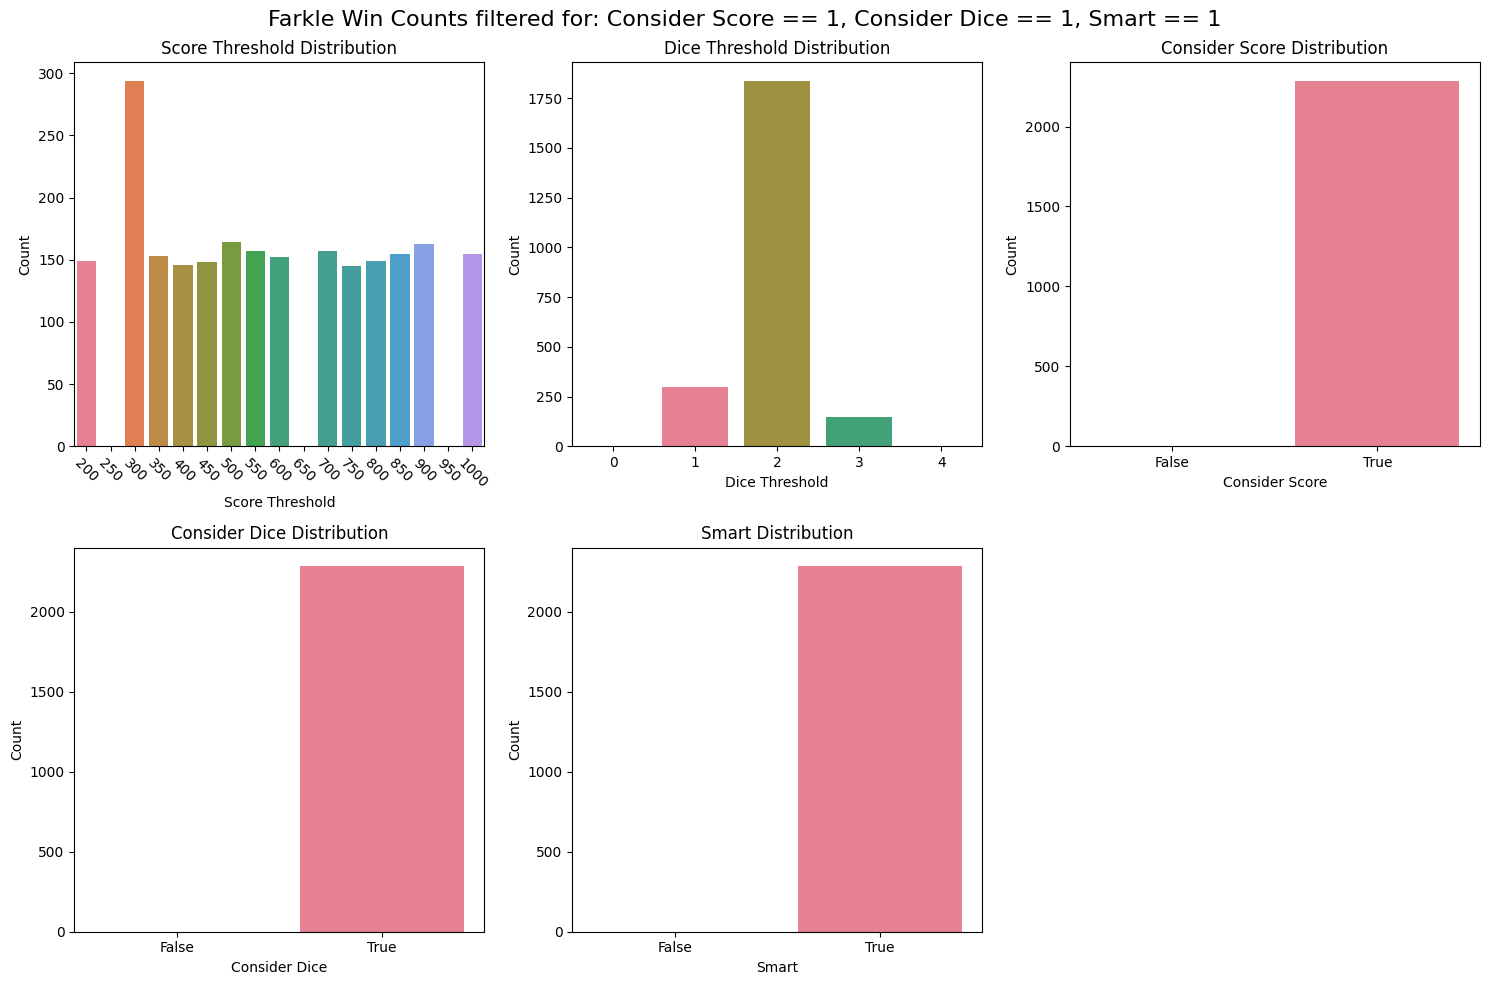

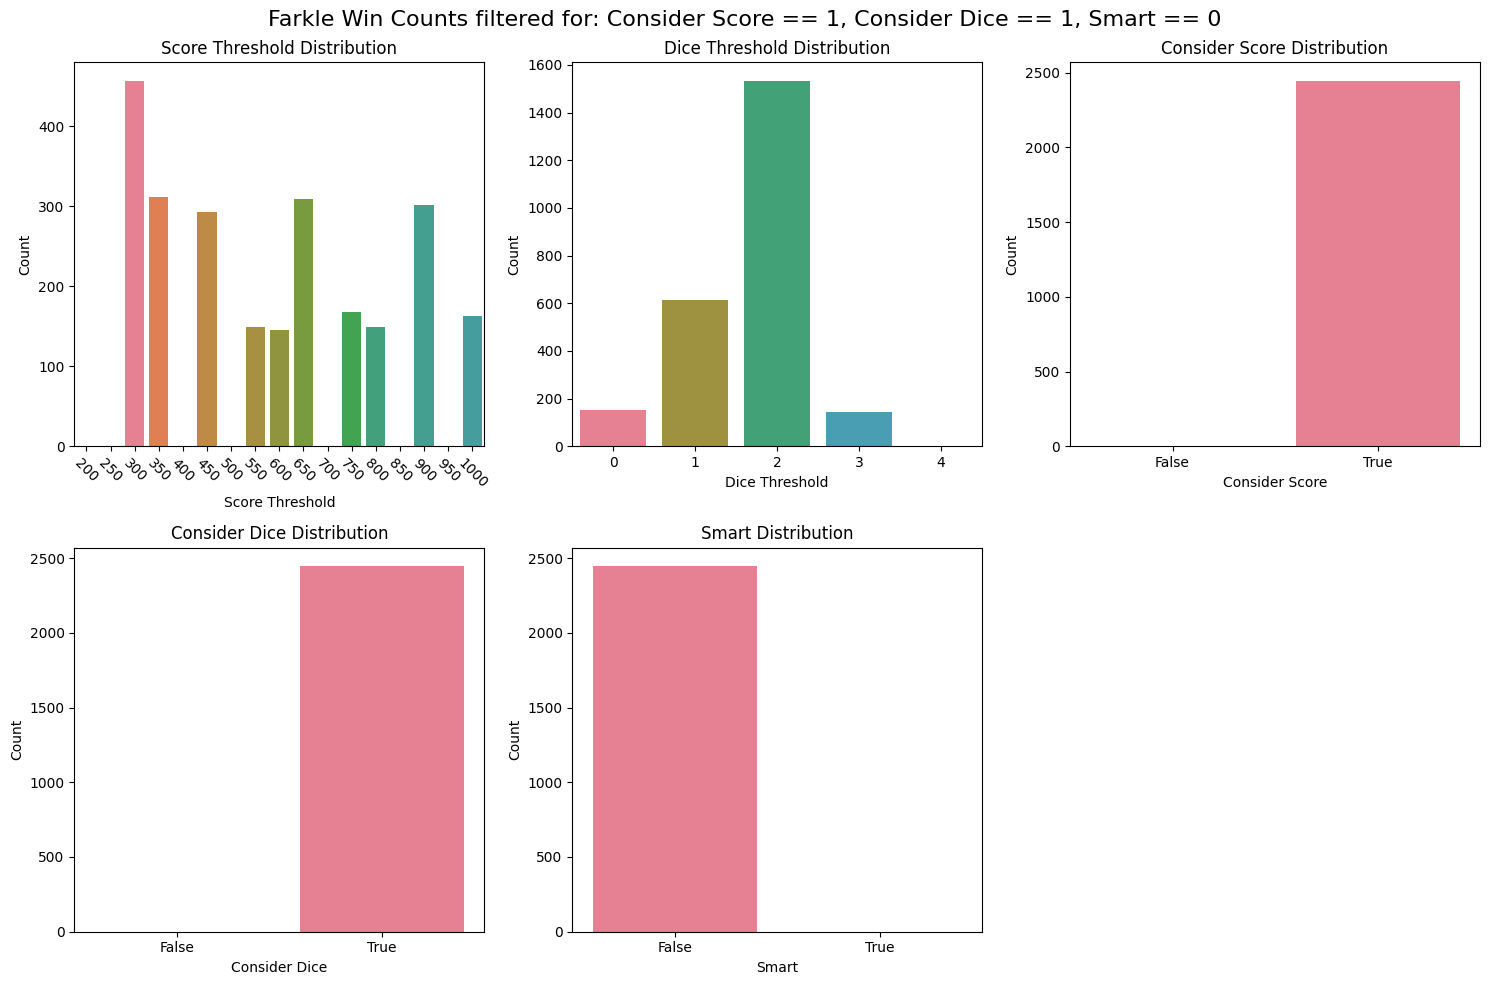

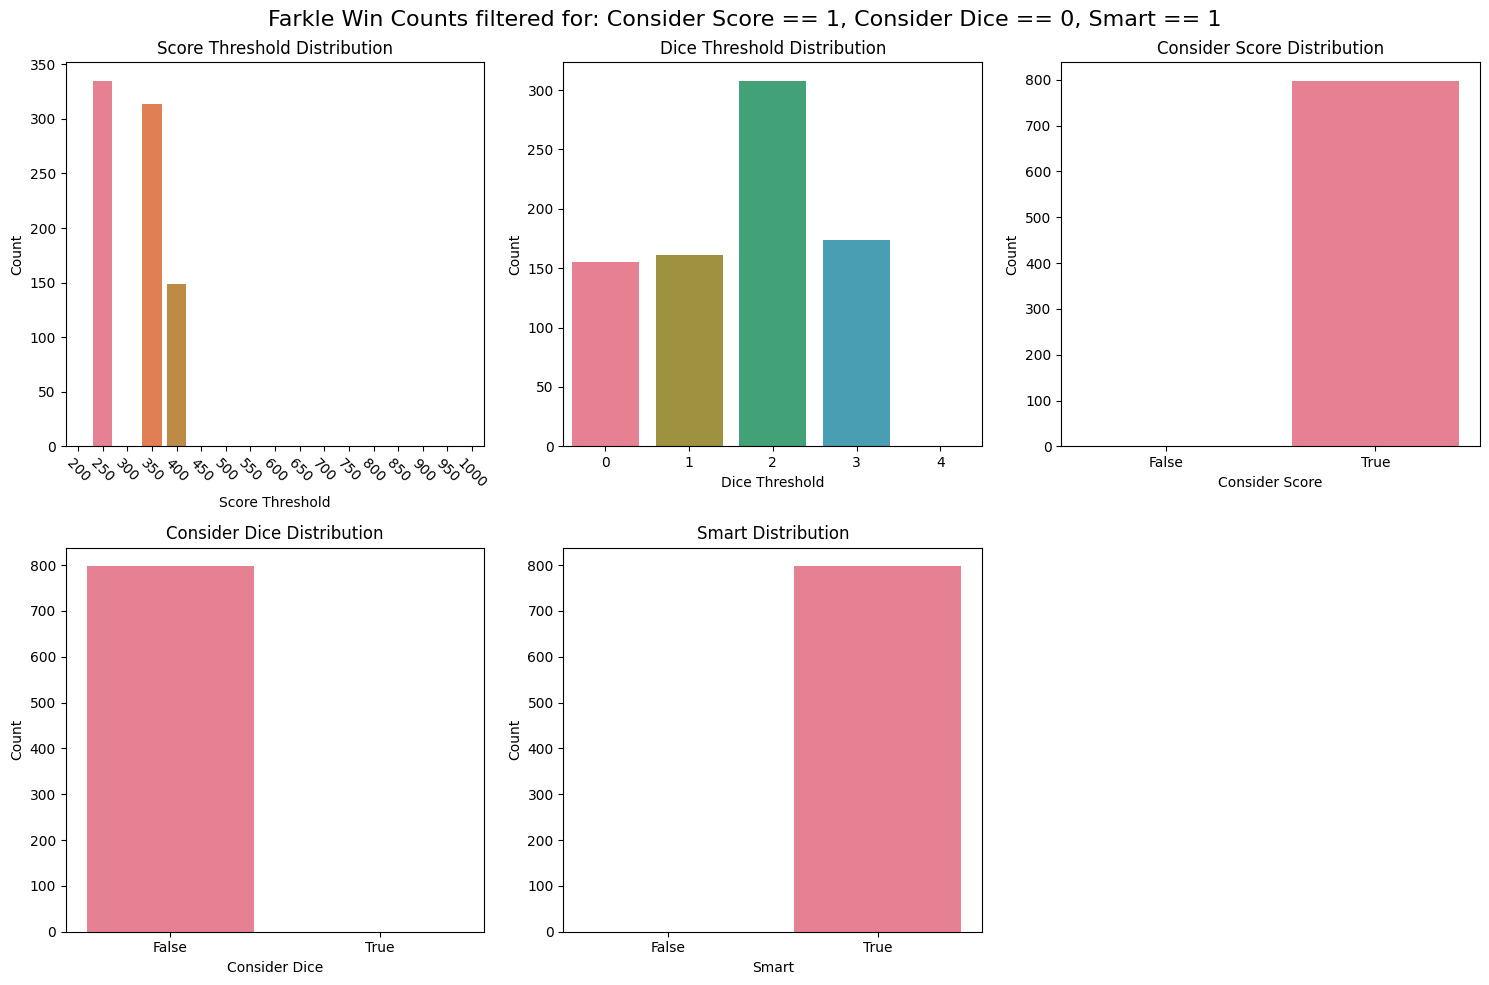

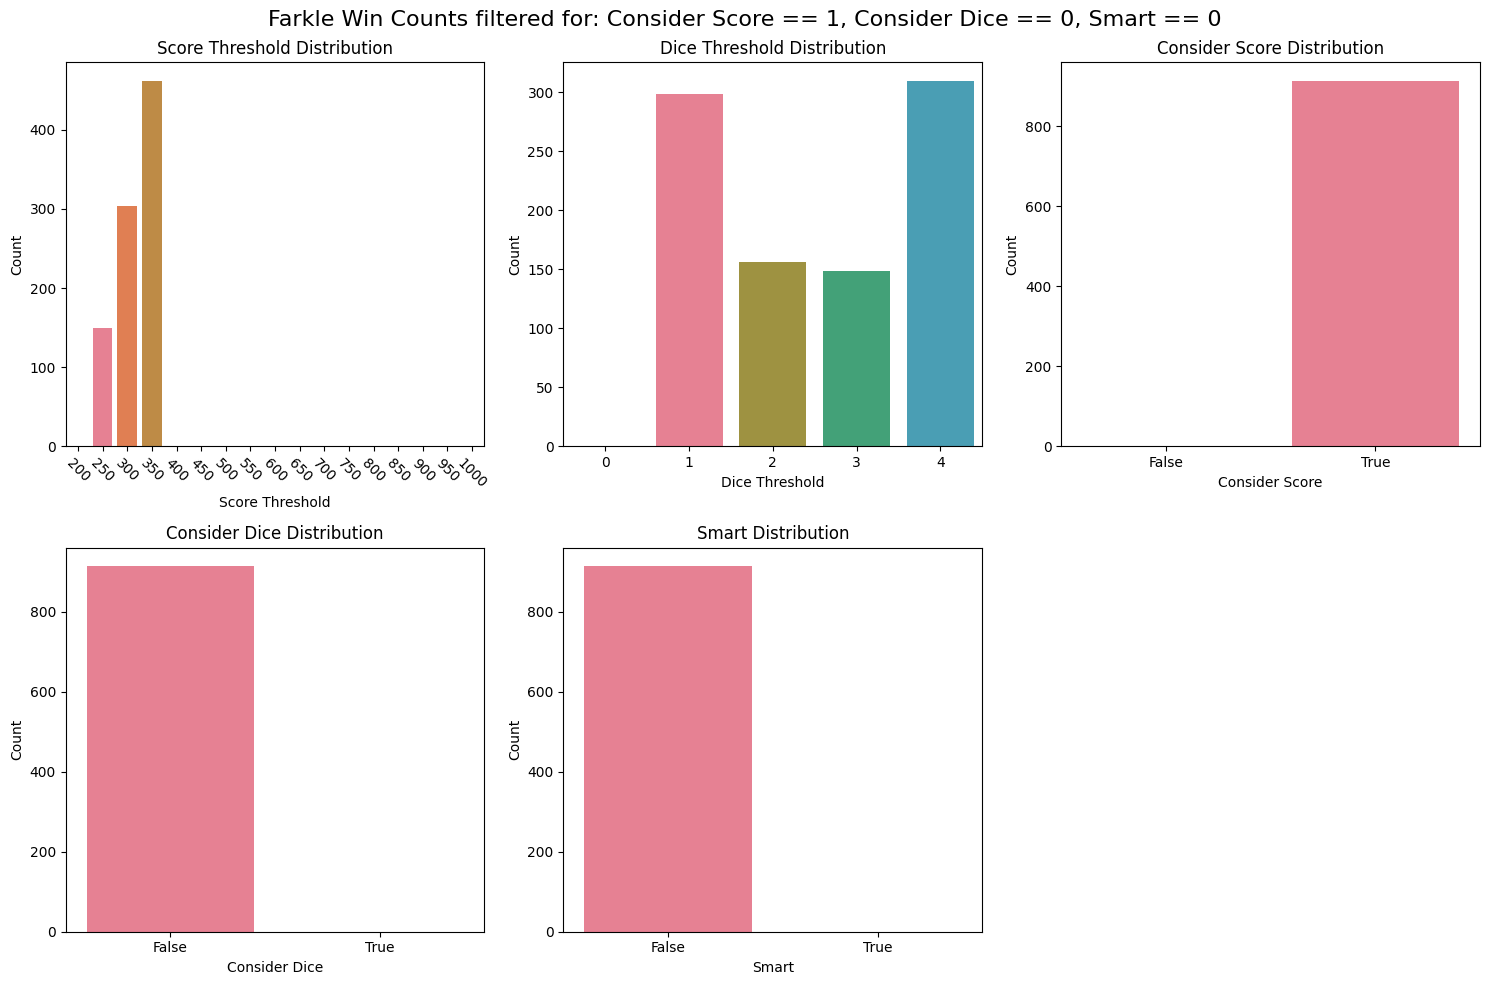

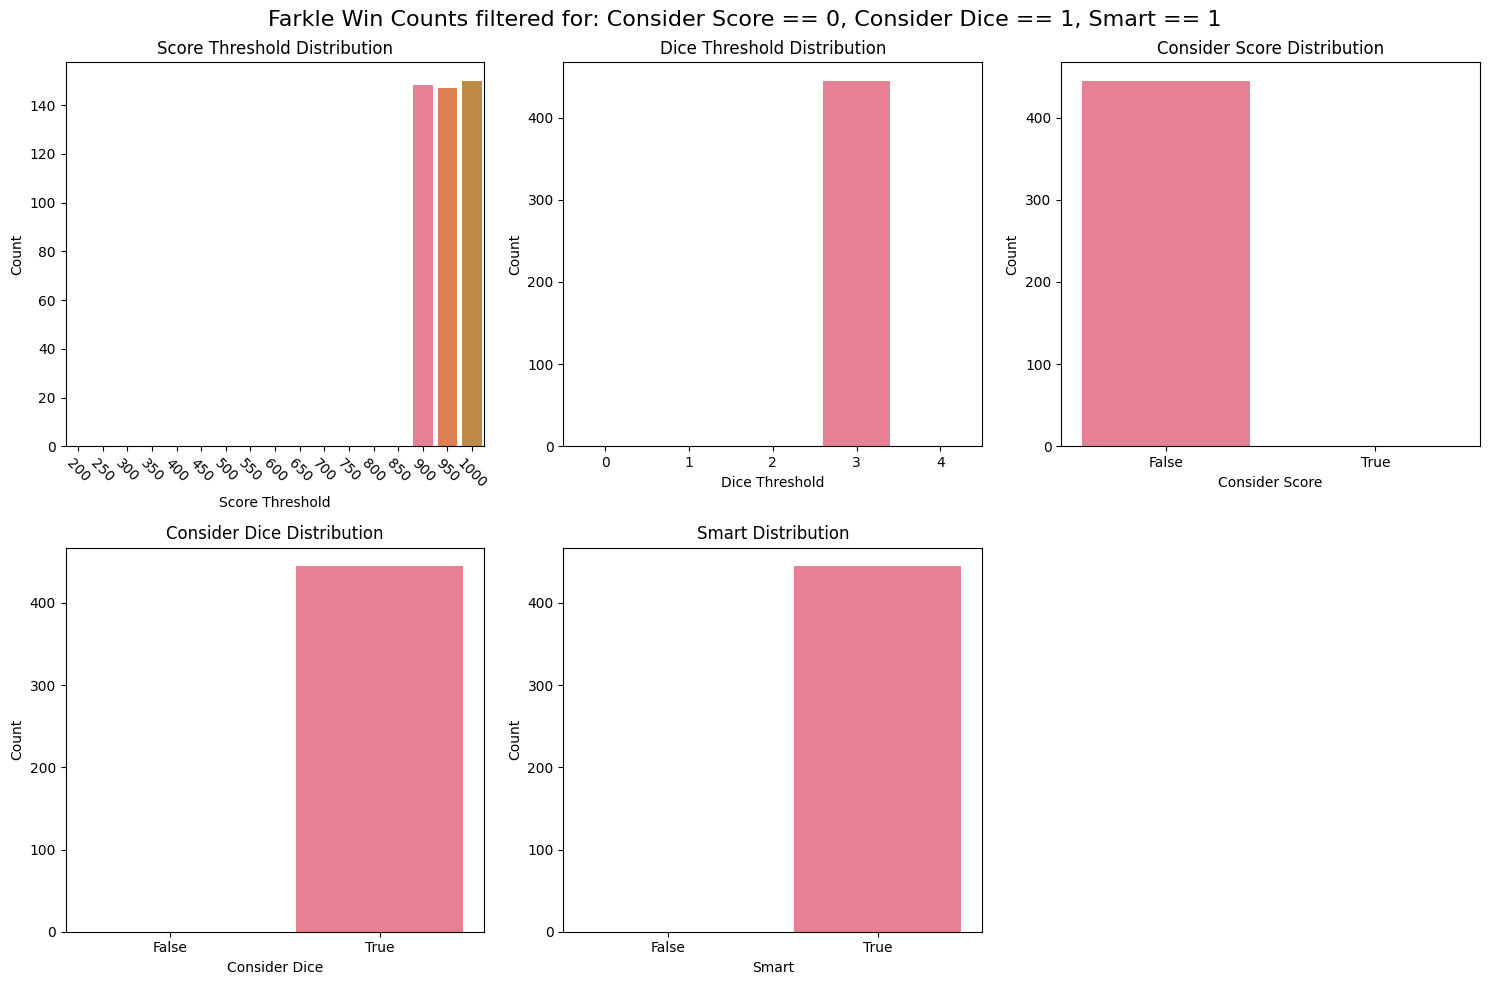

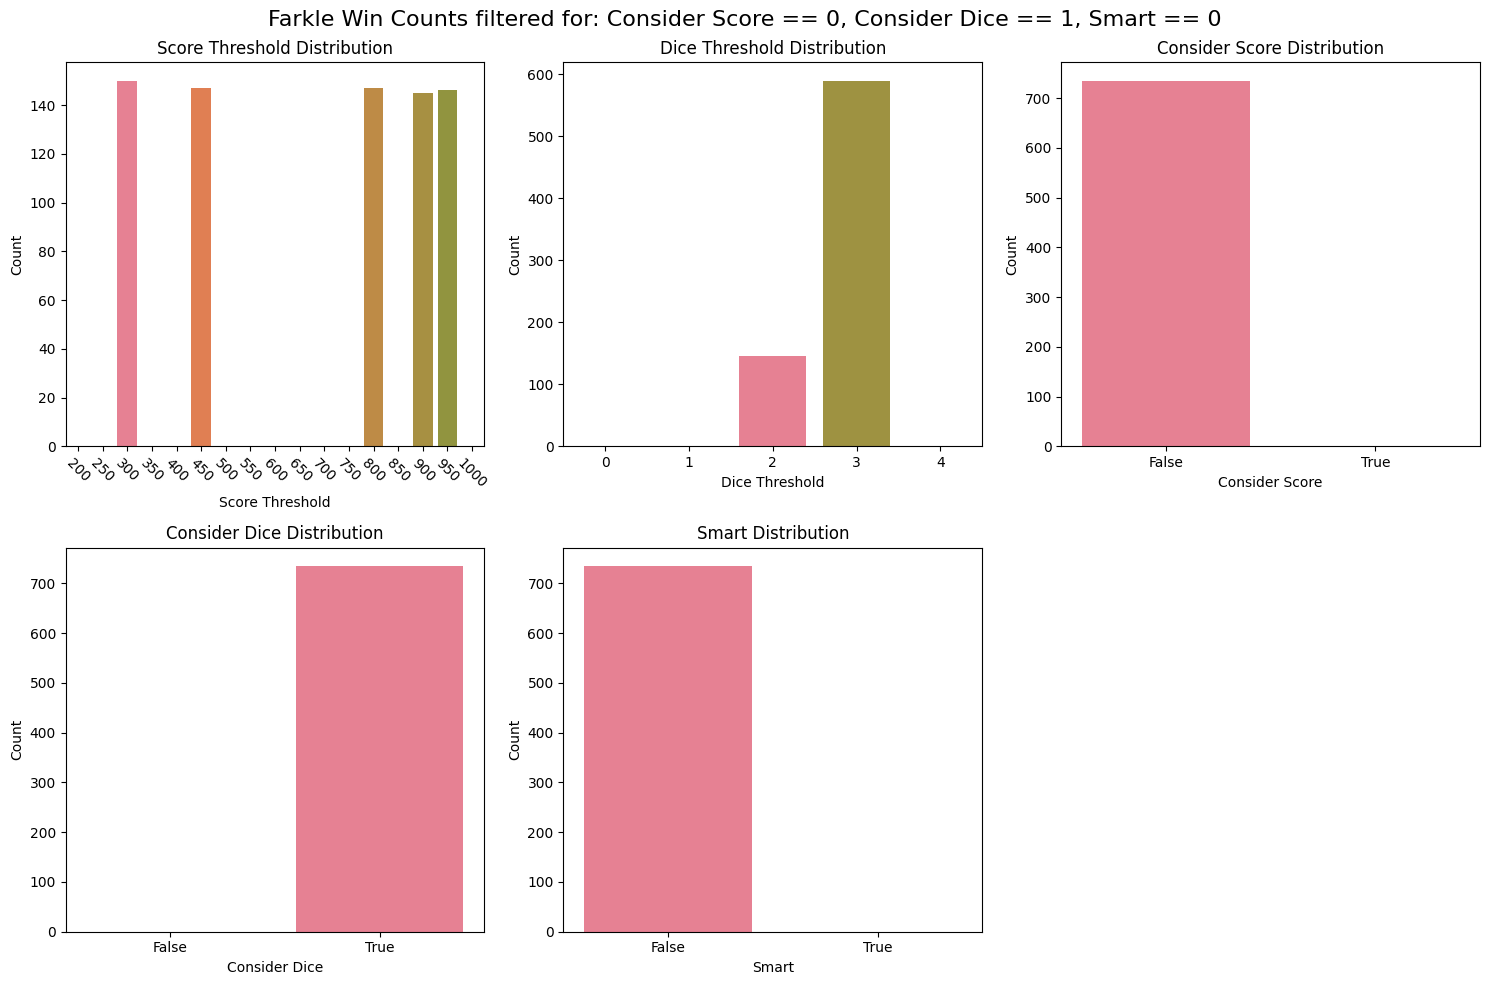

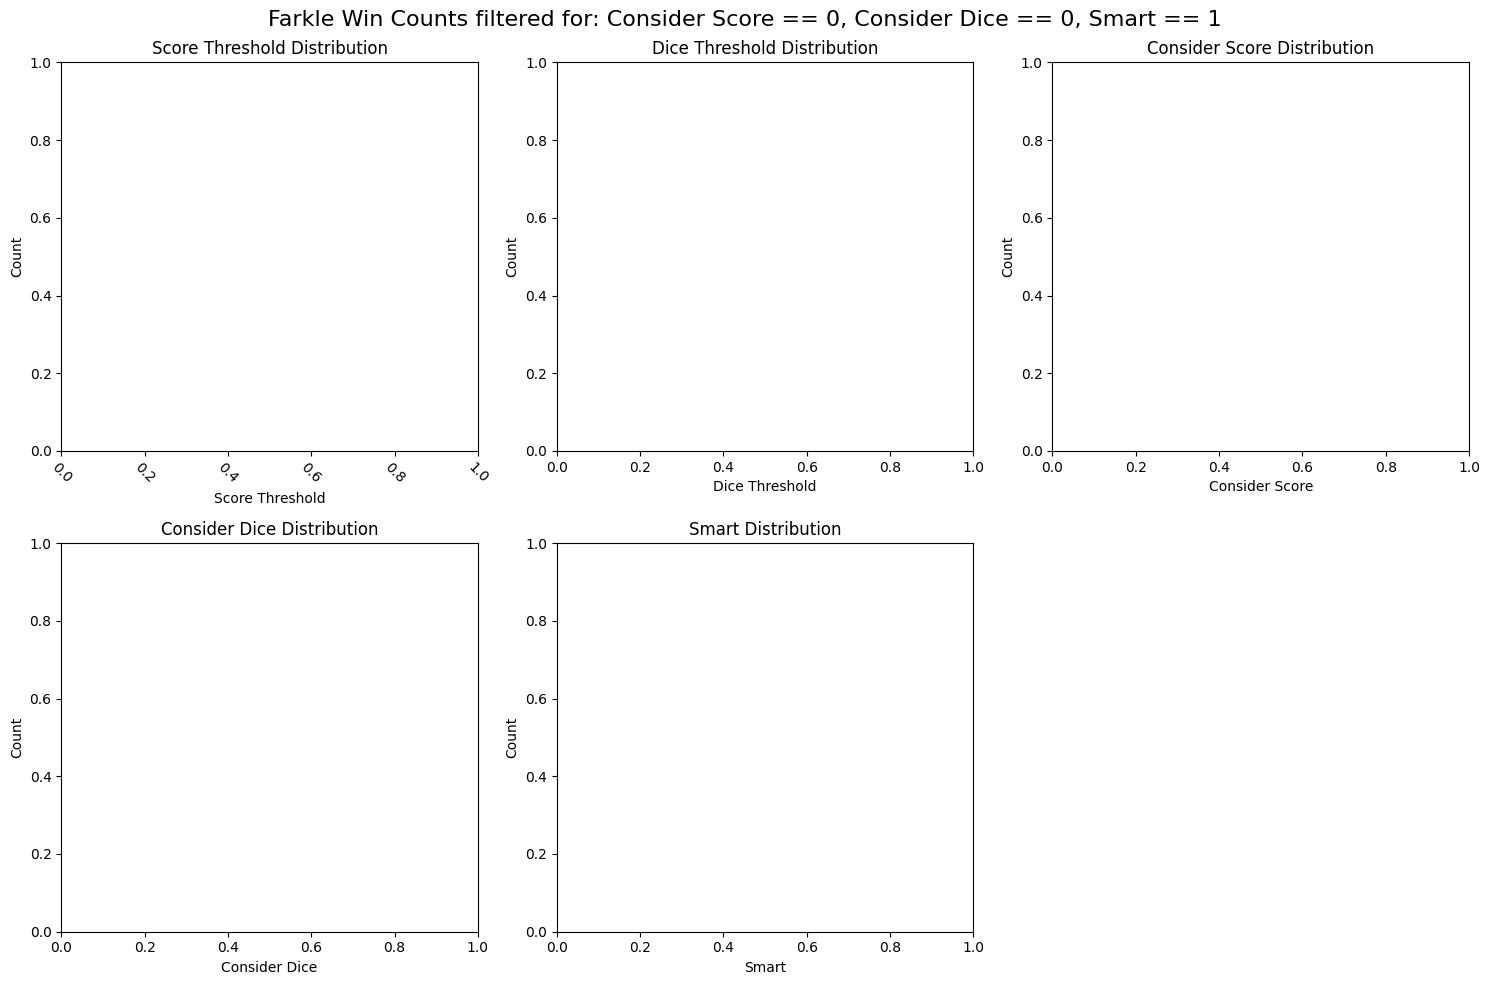

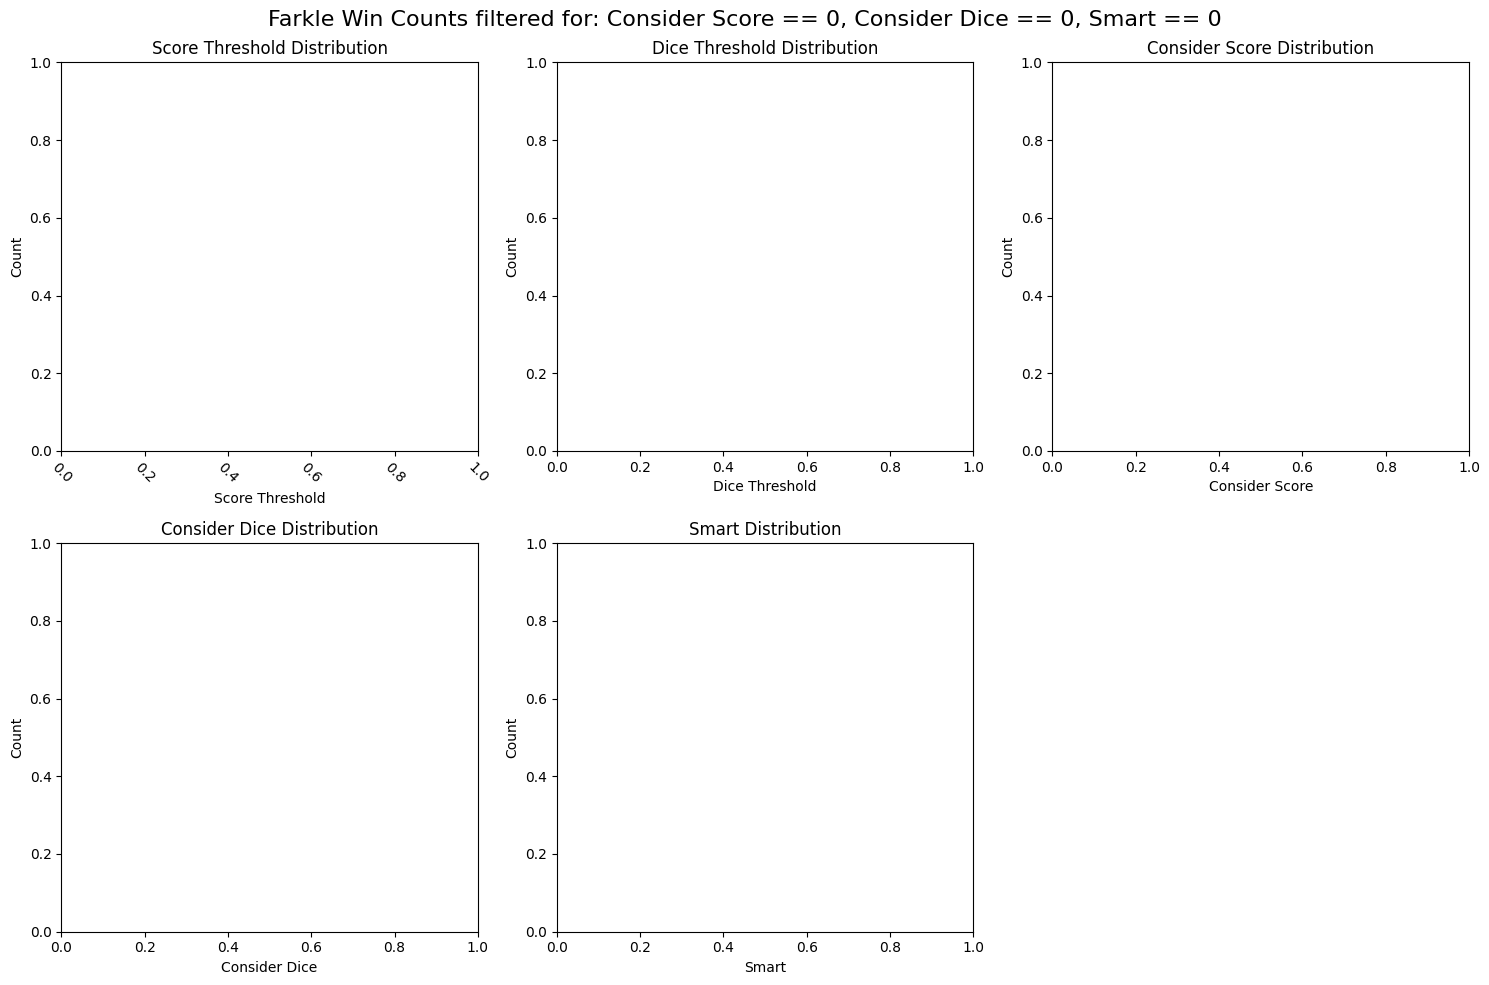

In [84]:
df = pd.read_csv('top_50_strategies_weighted.csv')
strategy_columns = ['Score Threshold', 'Dice Threshold', 'Consider Score', 'Consider Dice', 'Smart']
for item in all_filters:
    filtered_farkle_counts_plotter(df, strategy_columns, item[0], item[1], item[2])

In [67]:
print(len(df))

7626


In [68]:
print(7626/80000)

0.095325


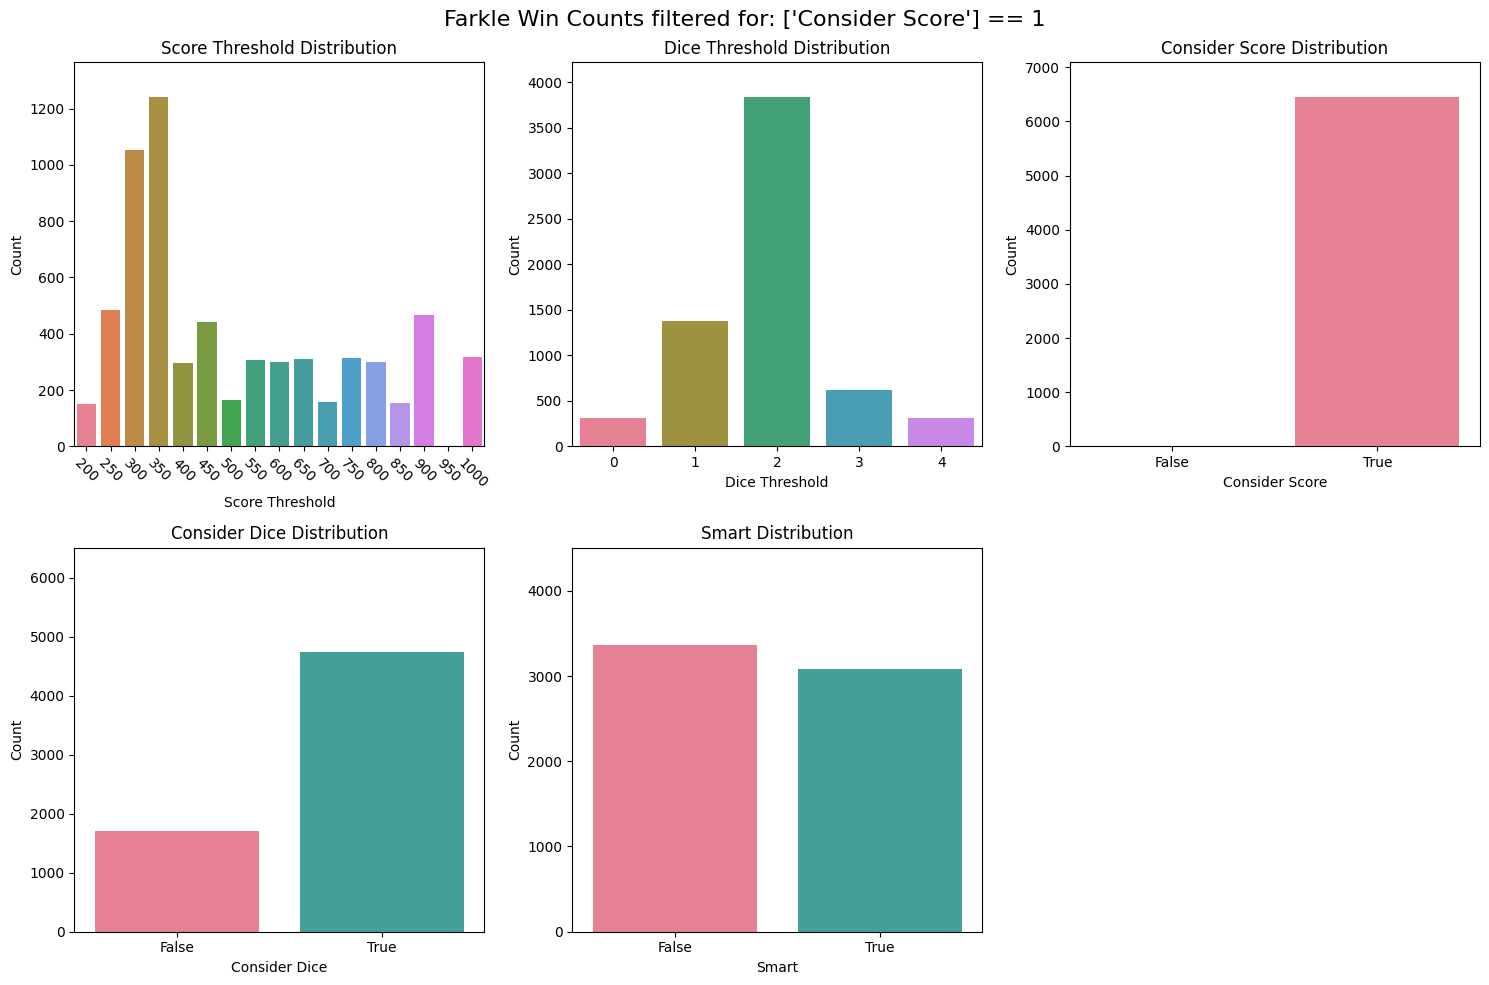

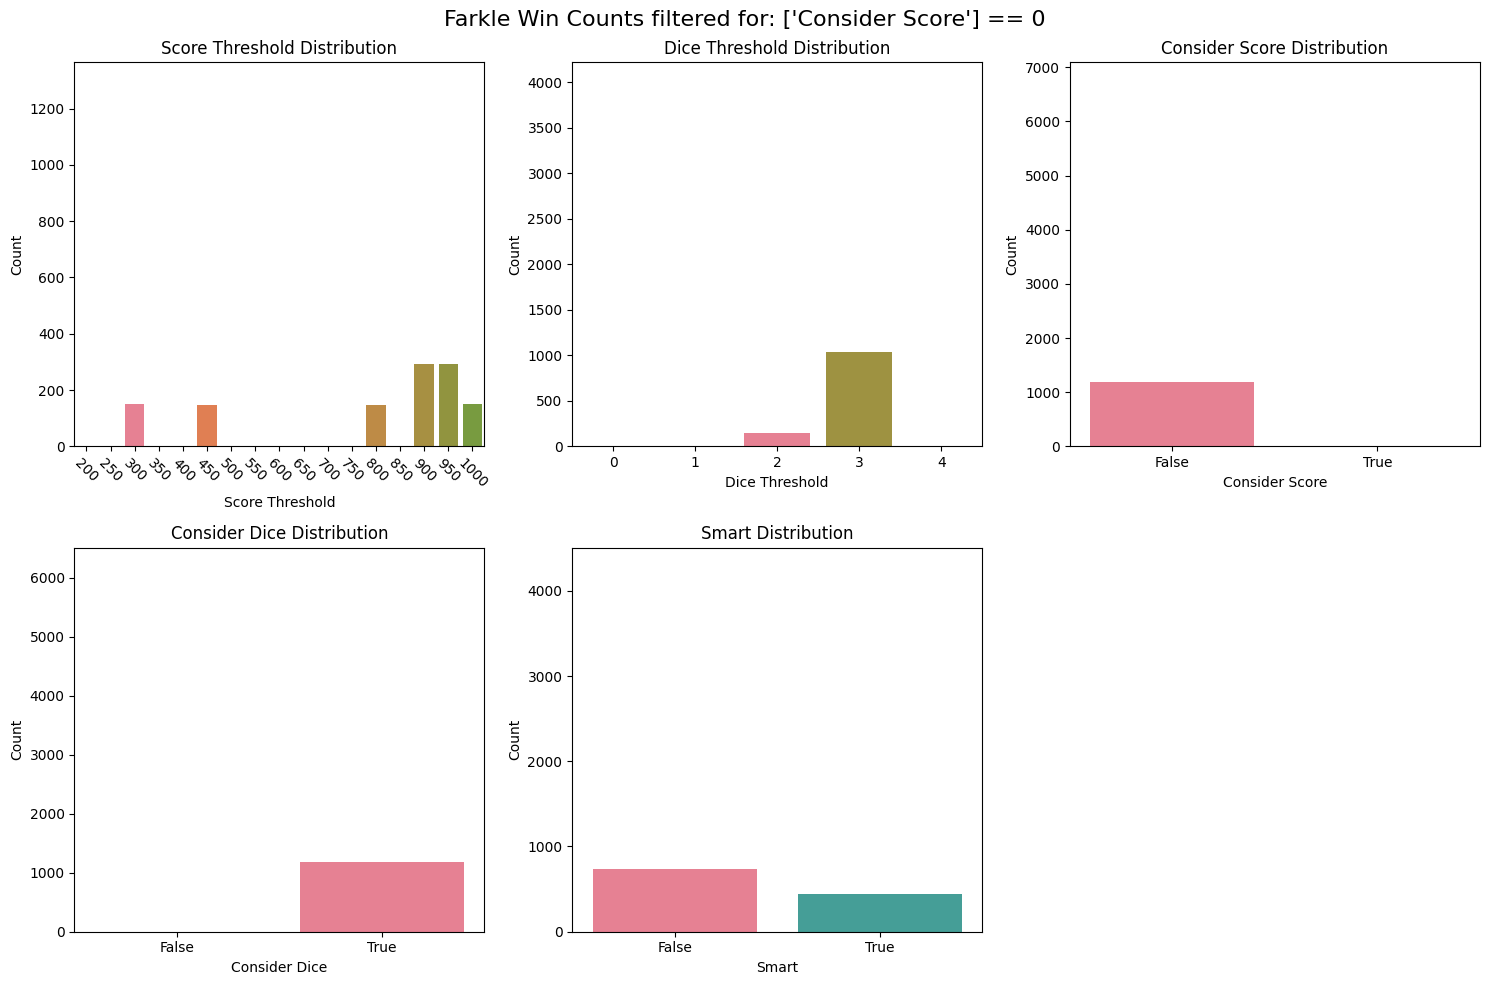

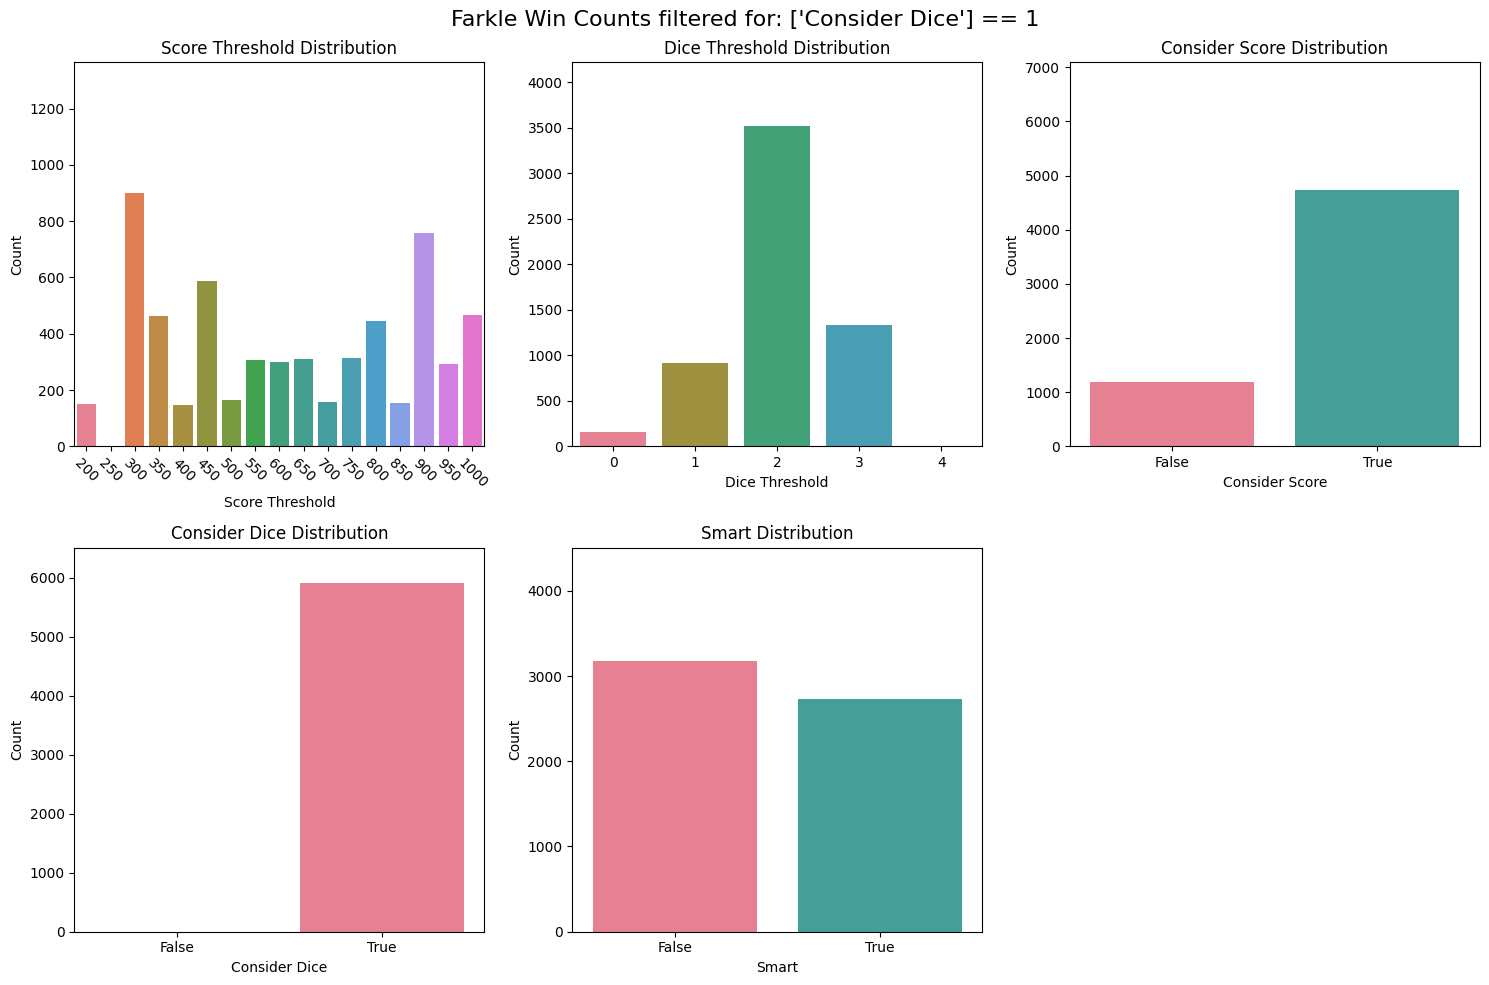

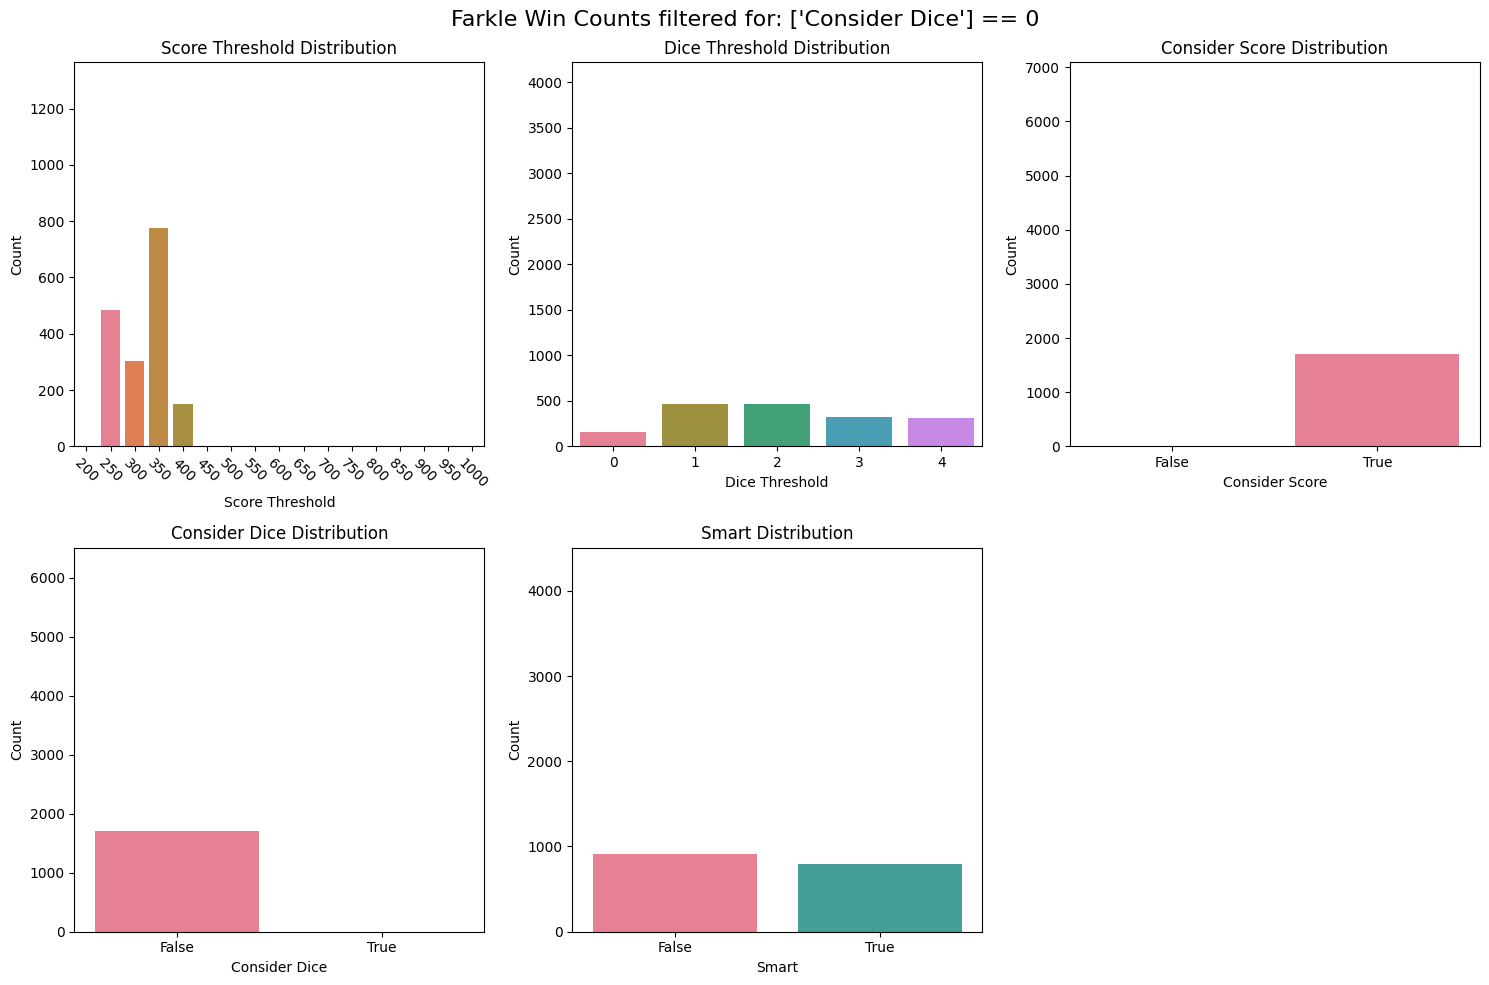

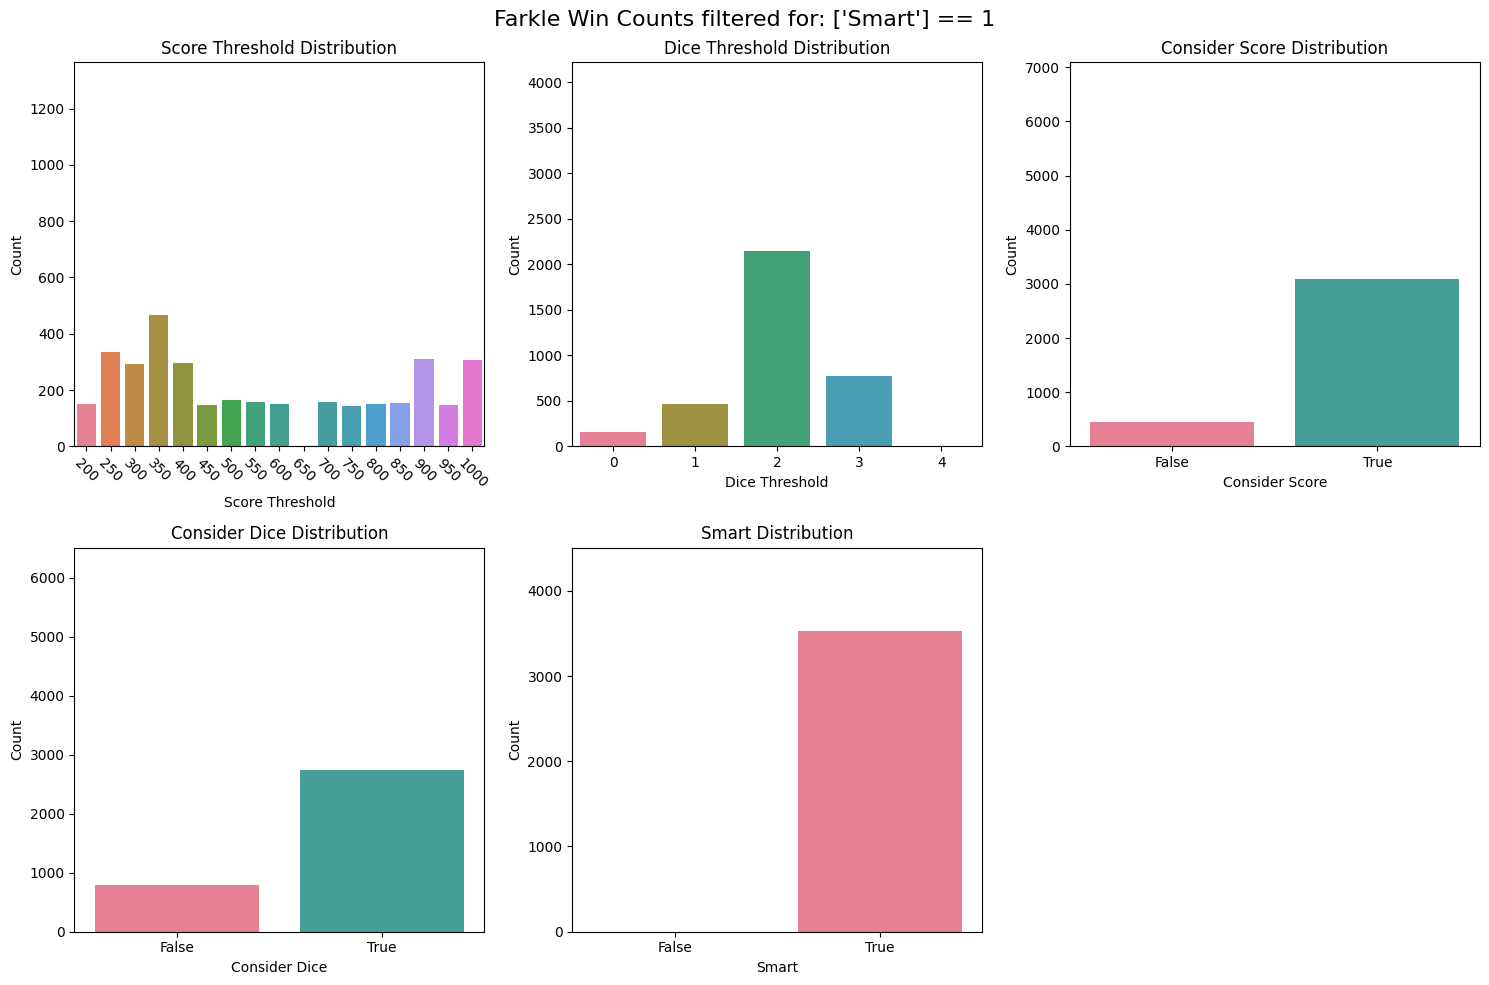

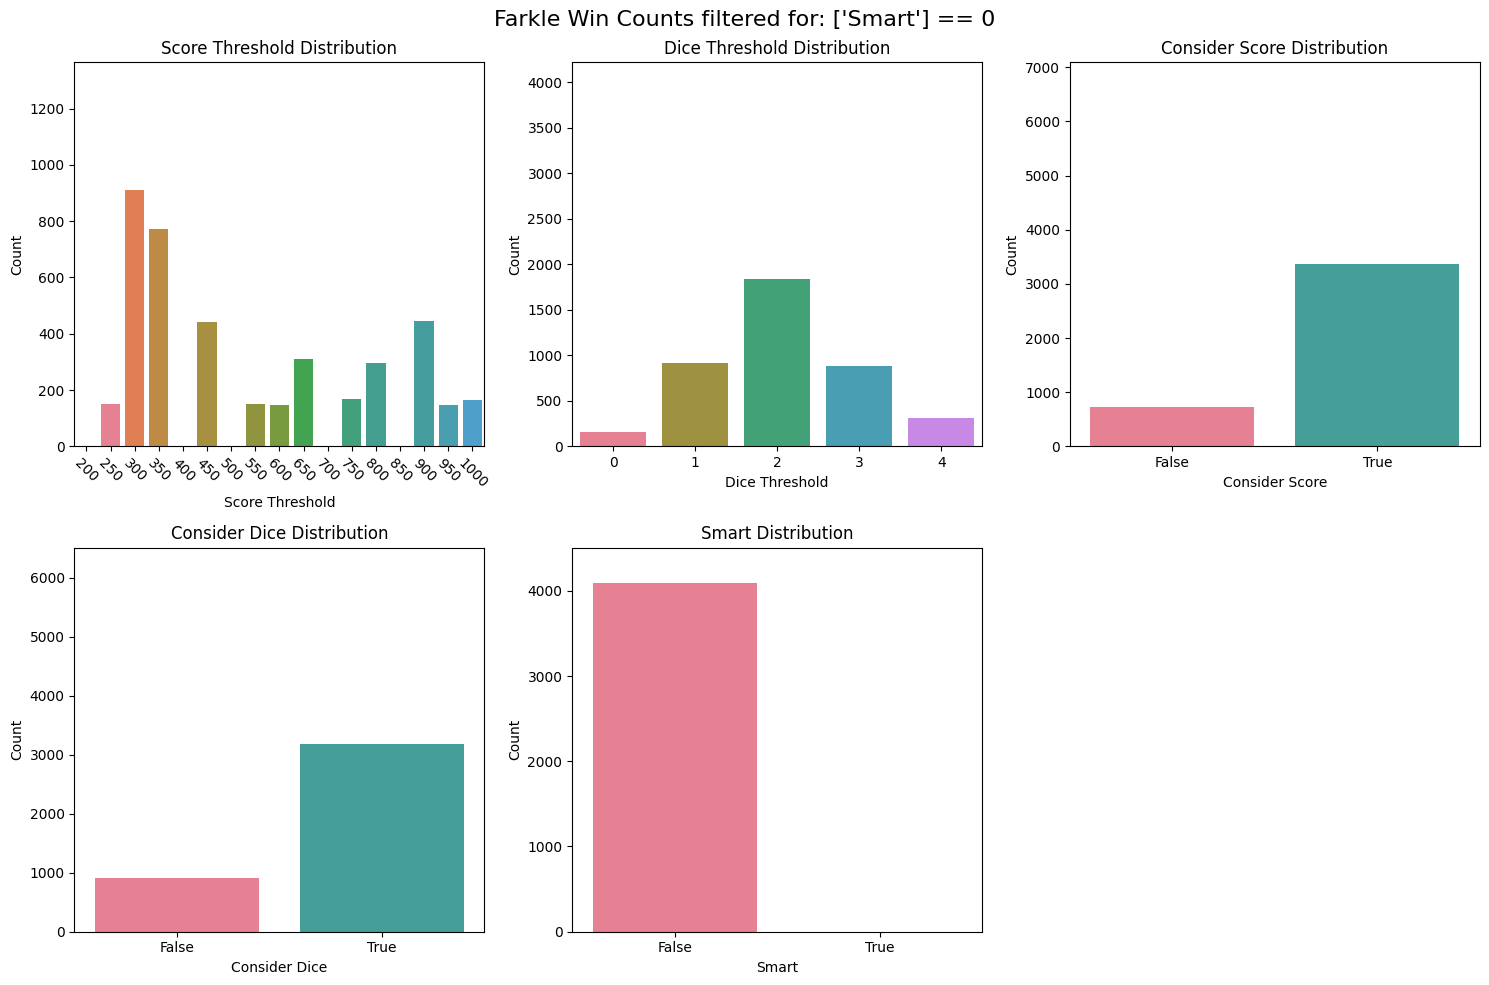

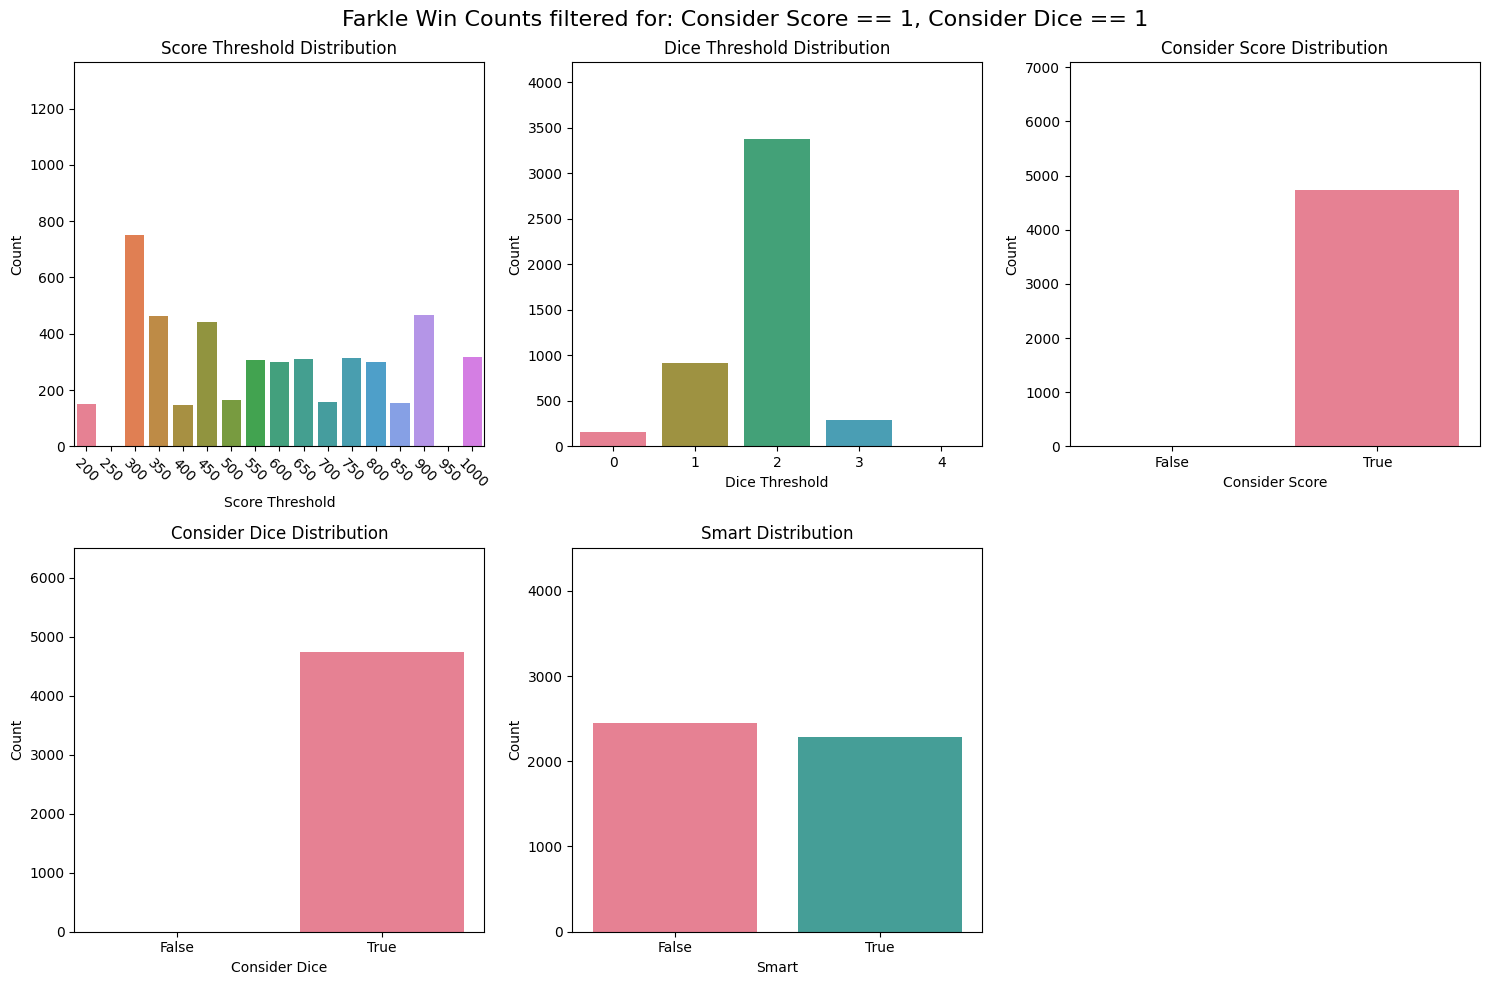

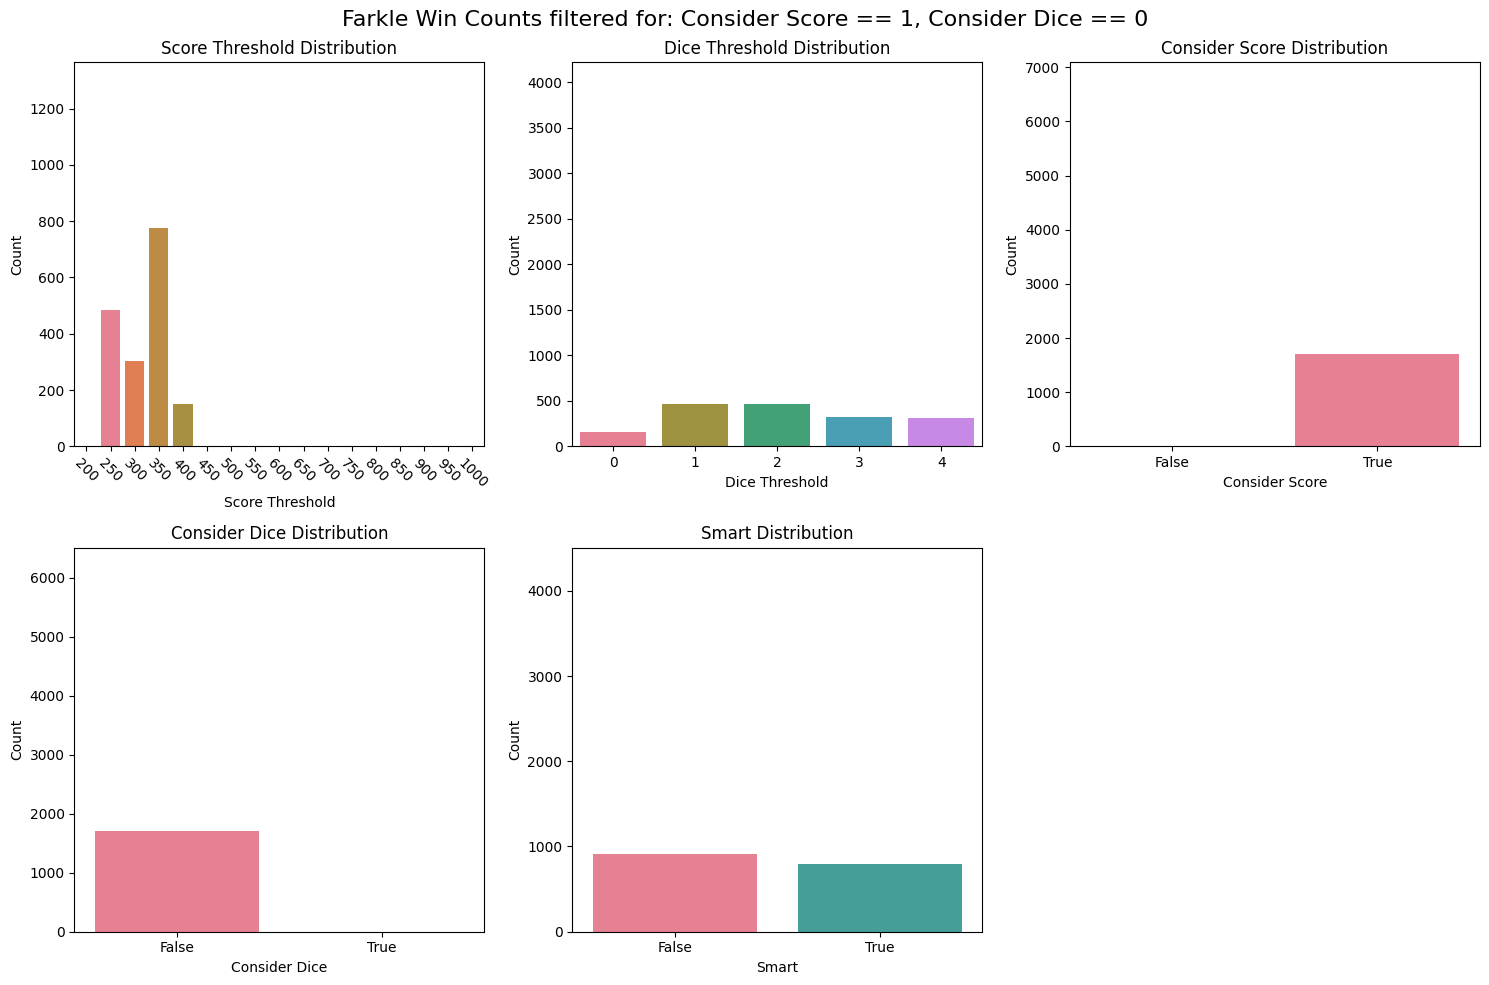

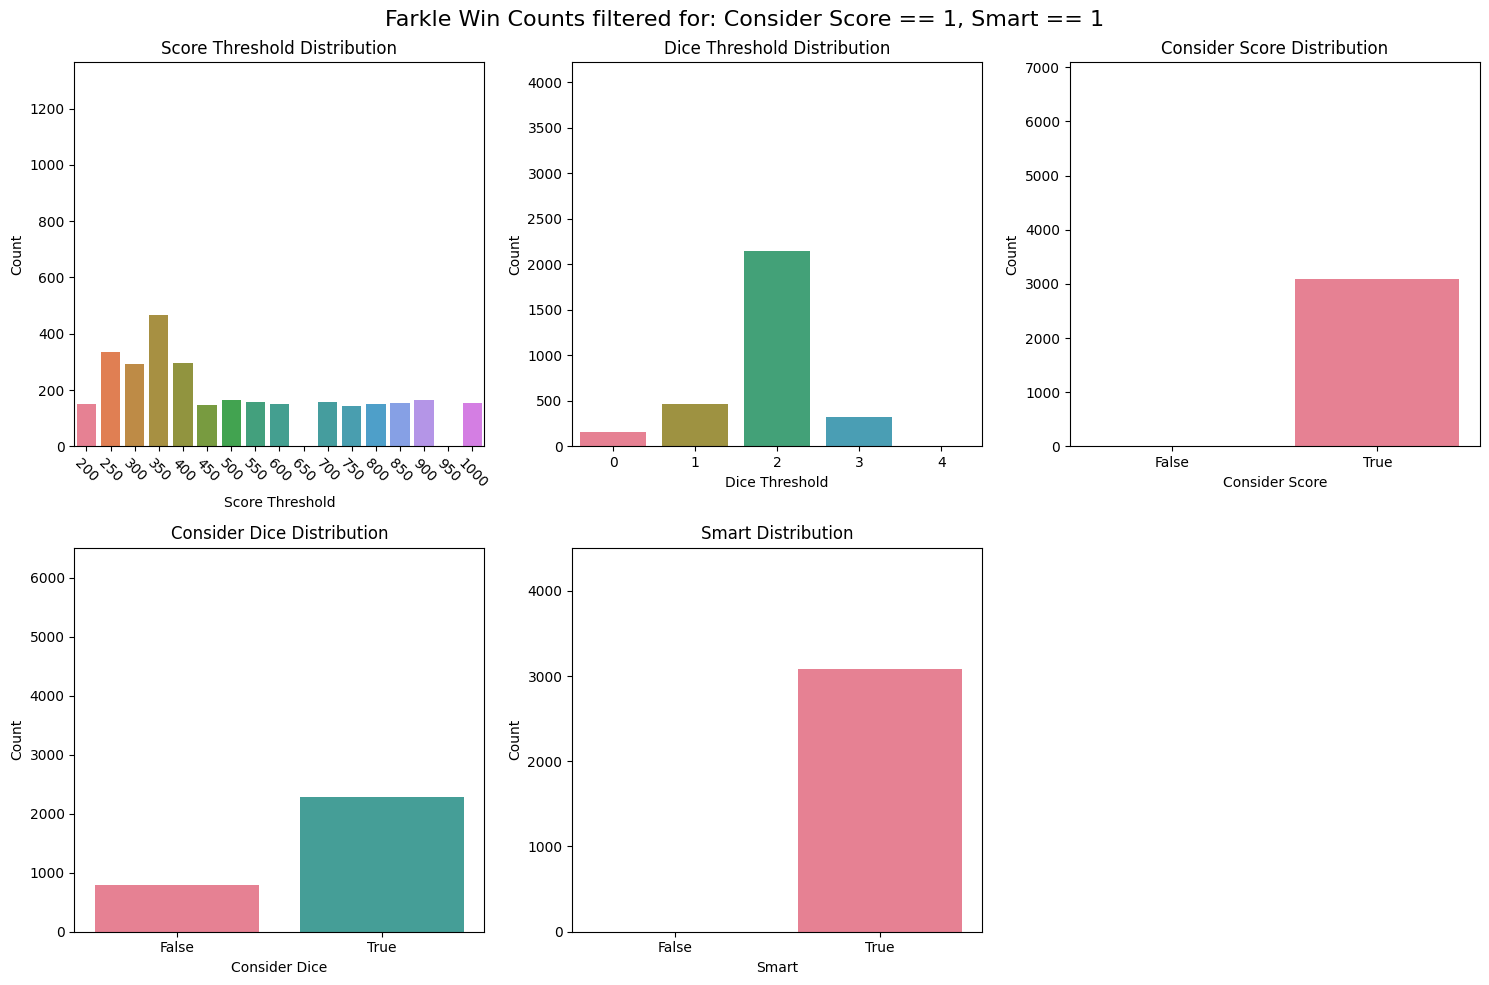

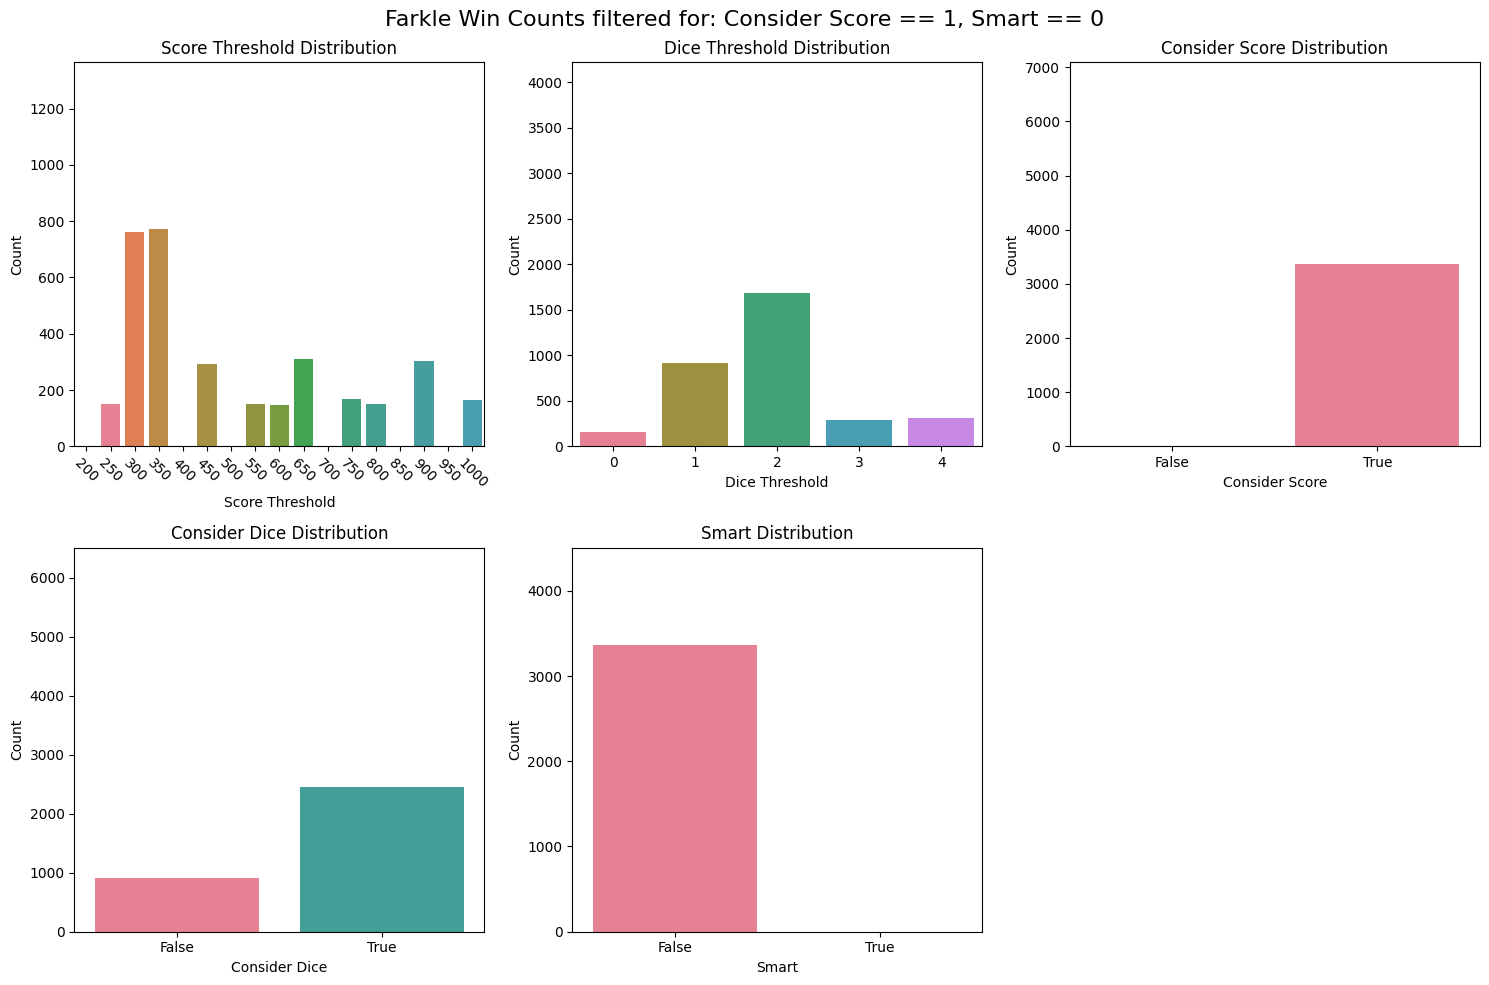

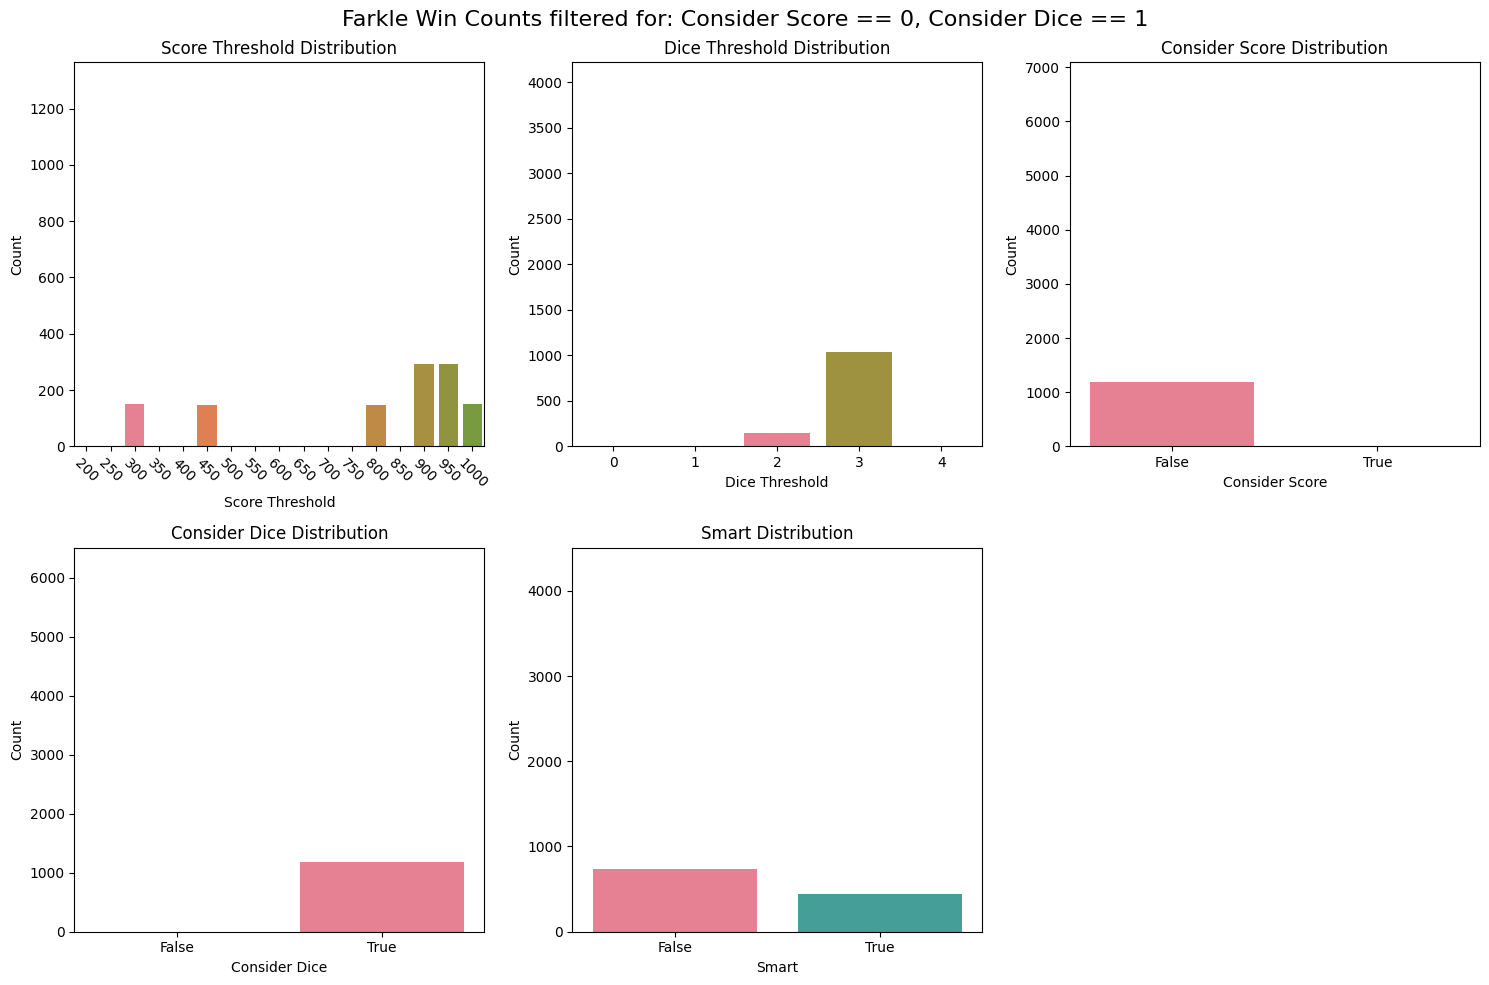

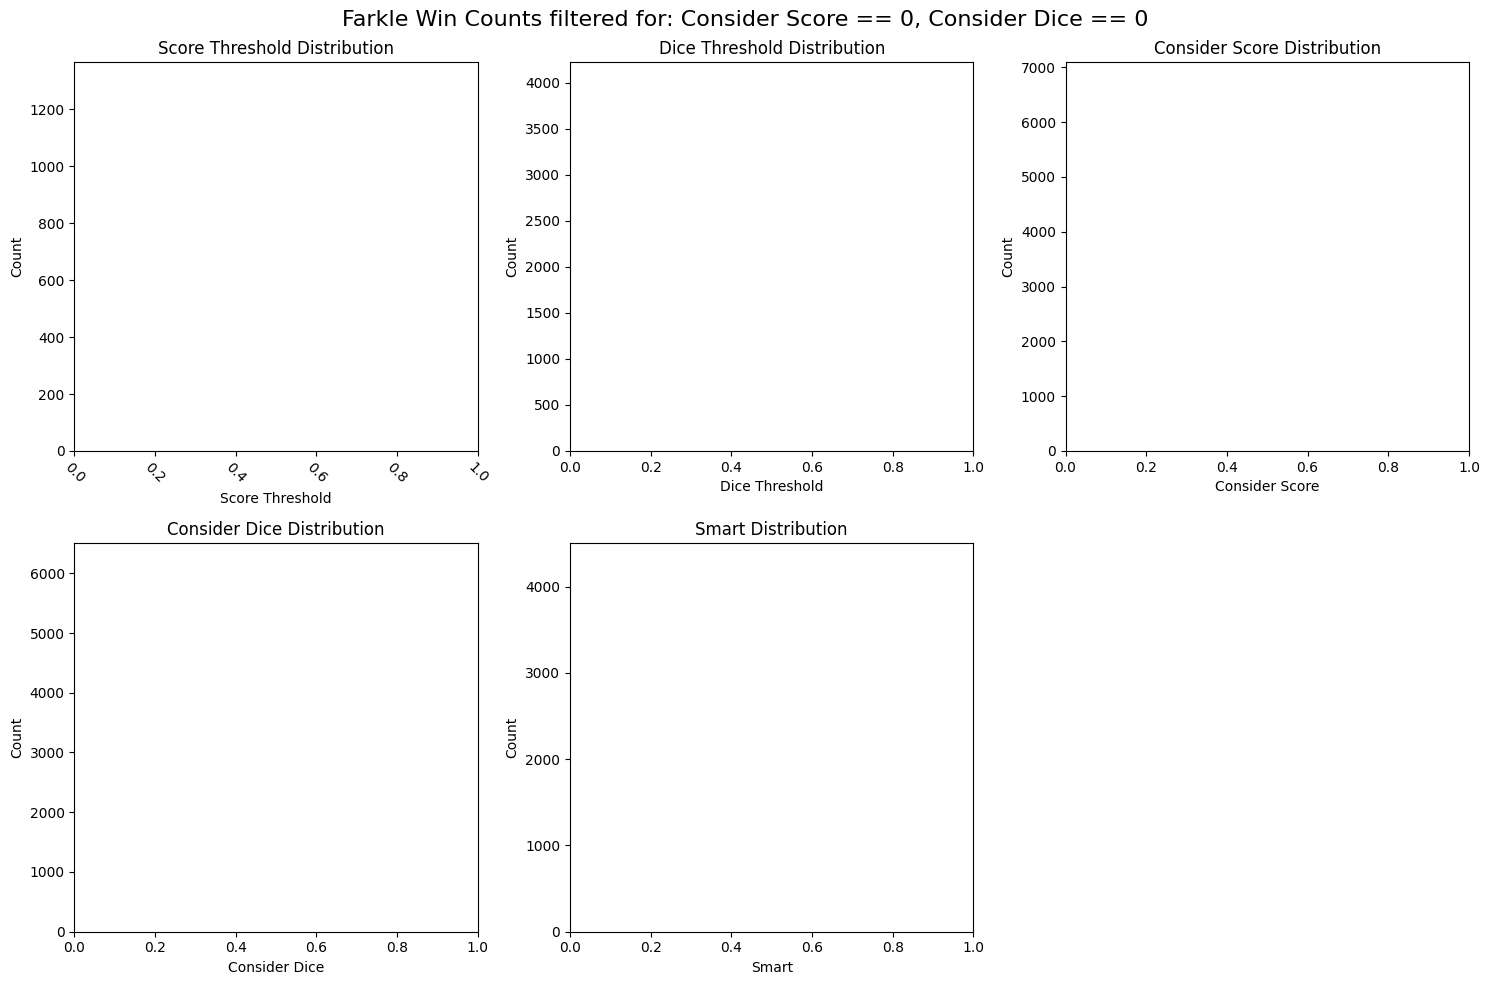

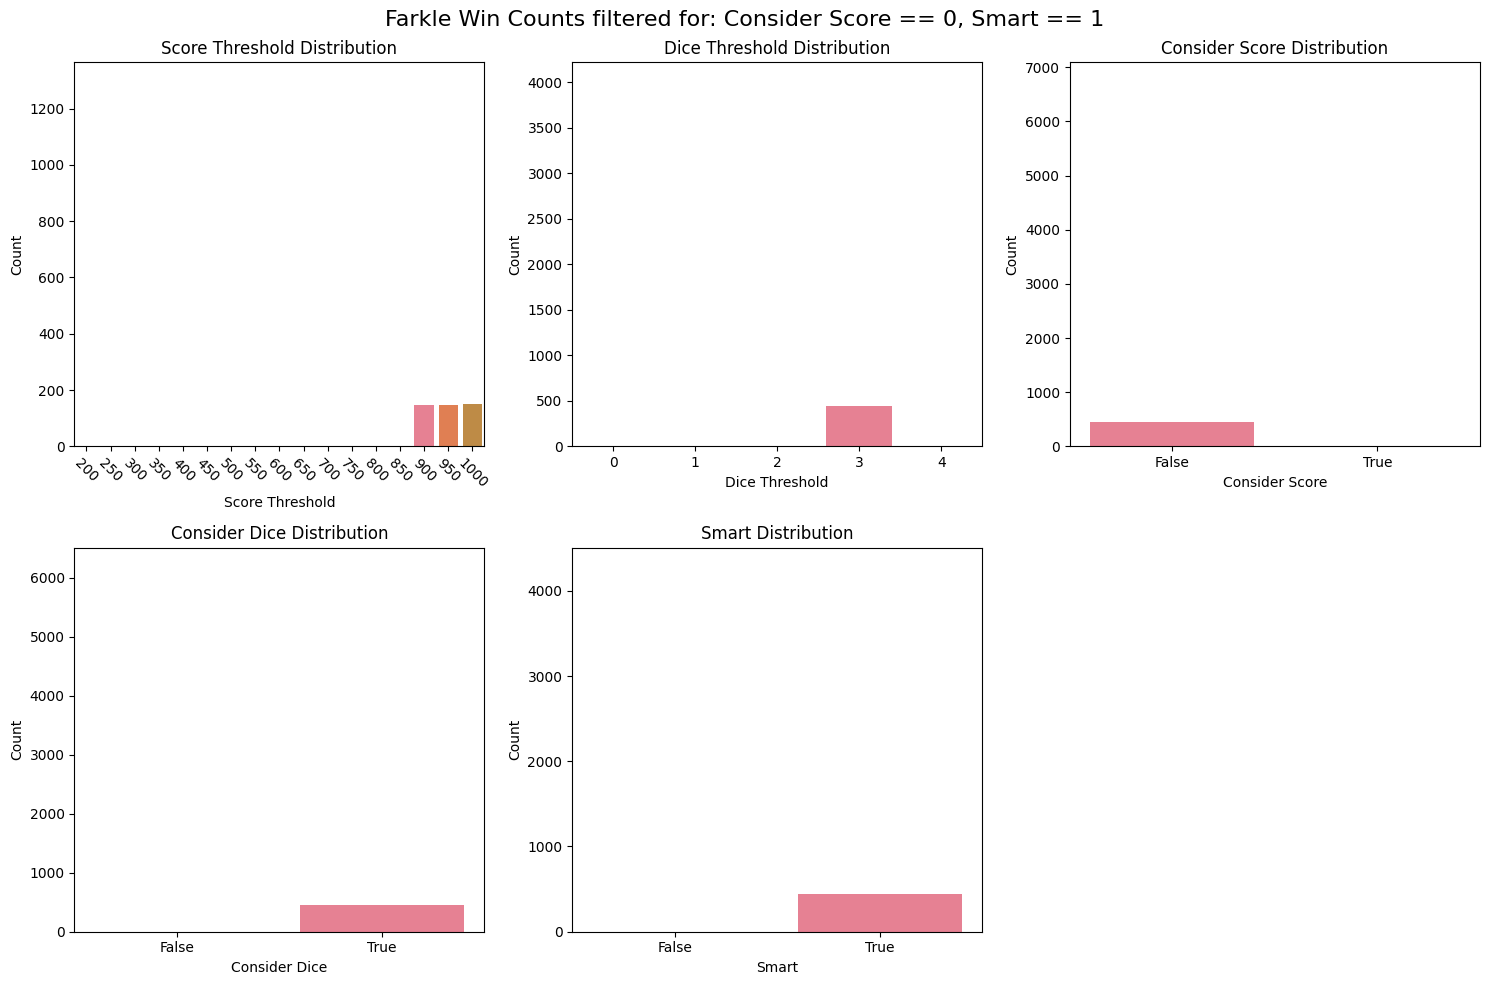

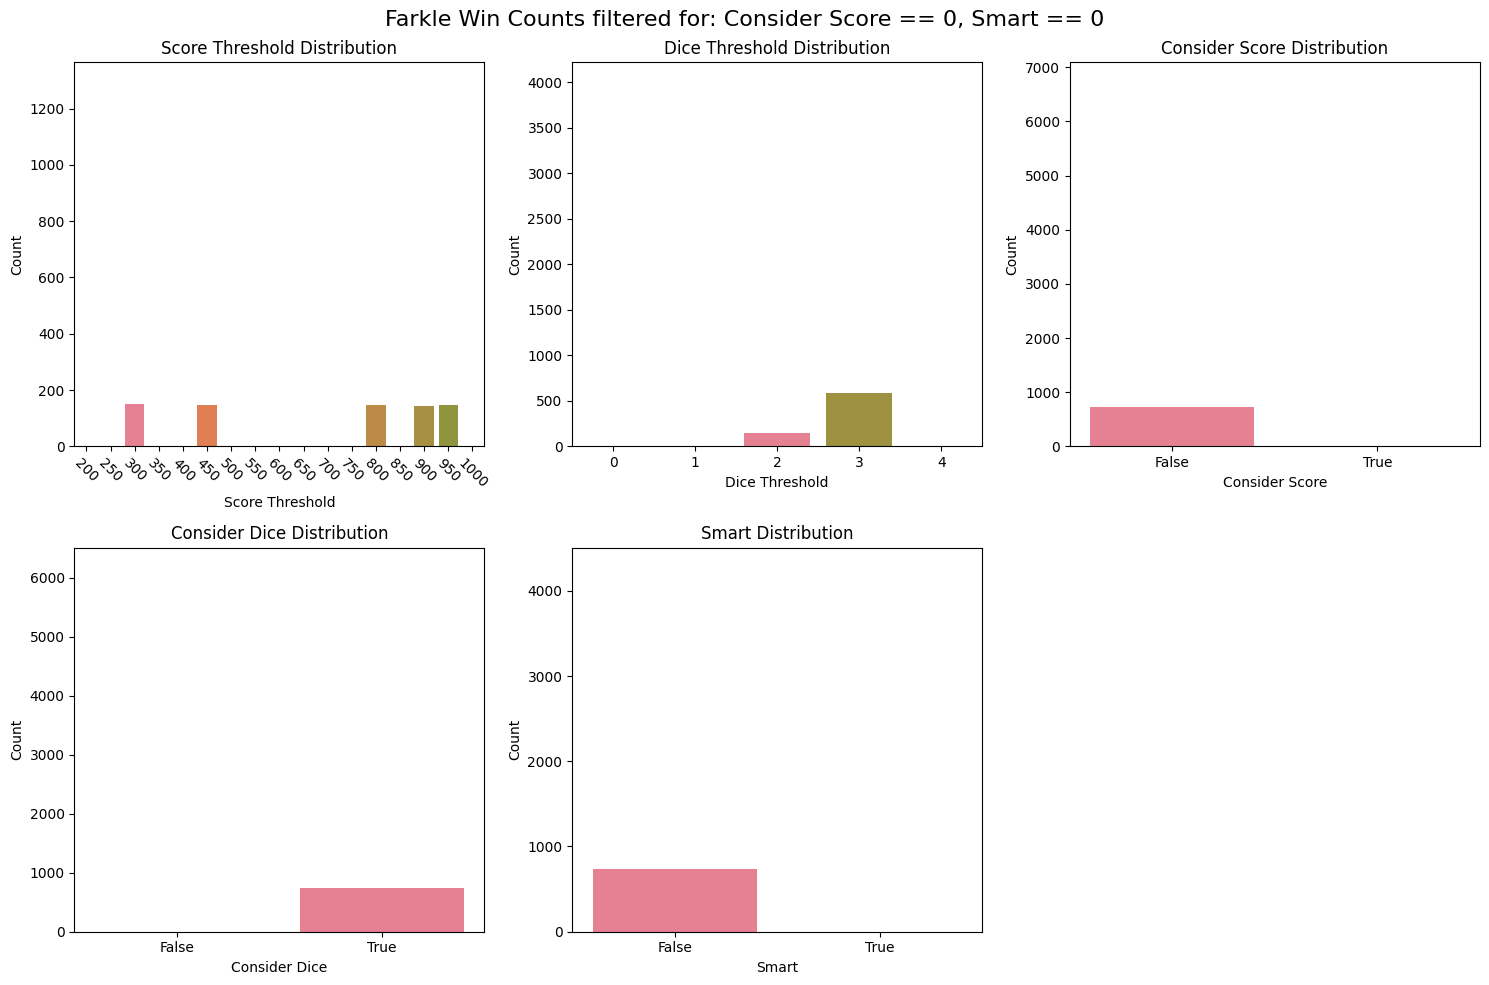

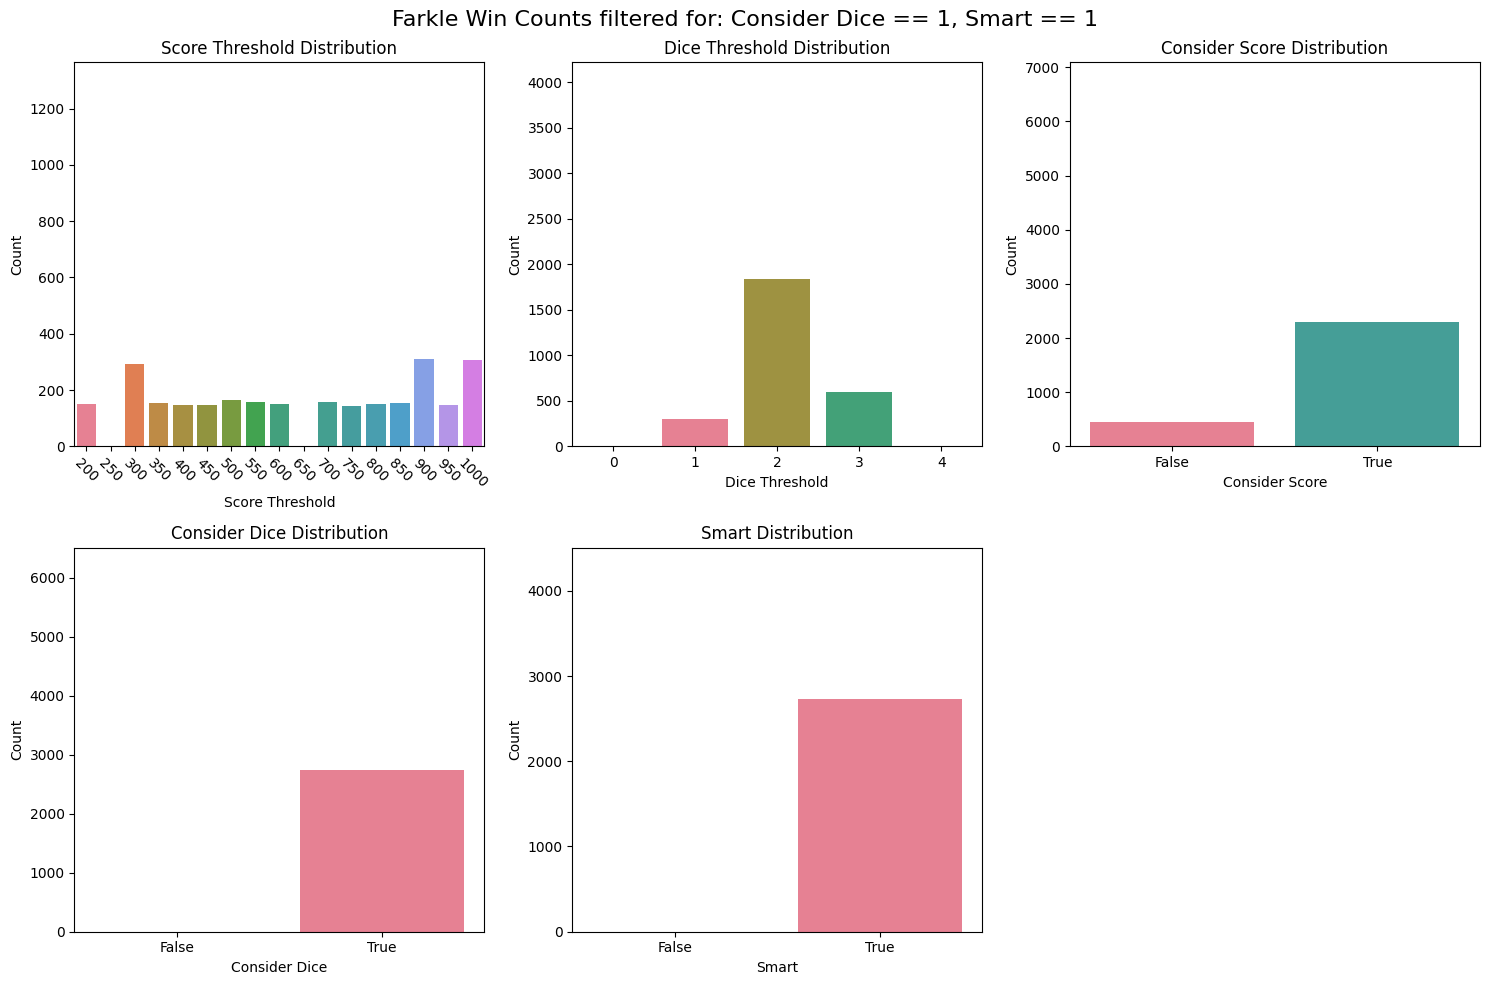

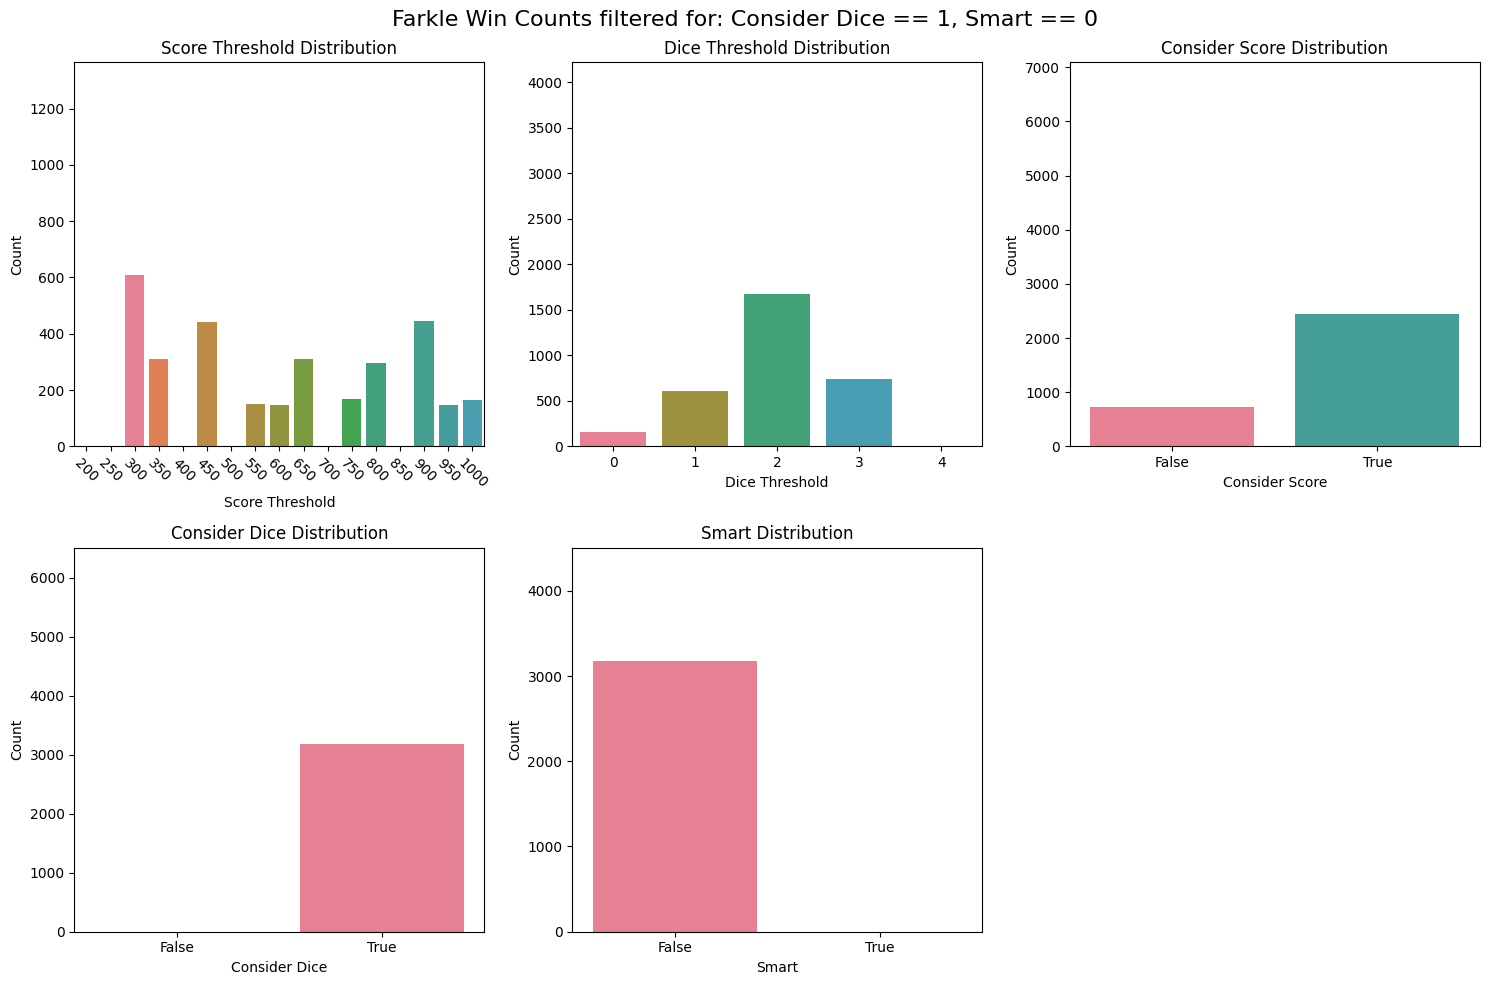

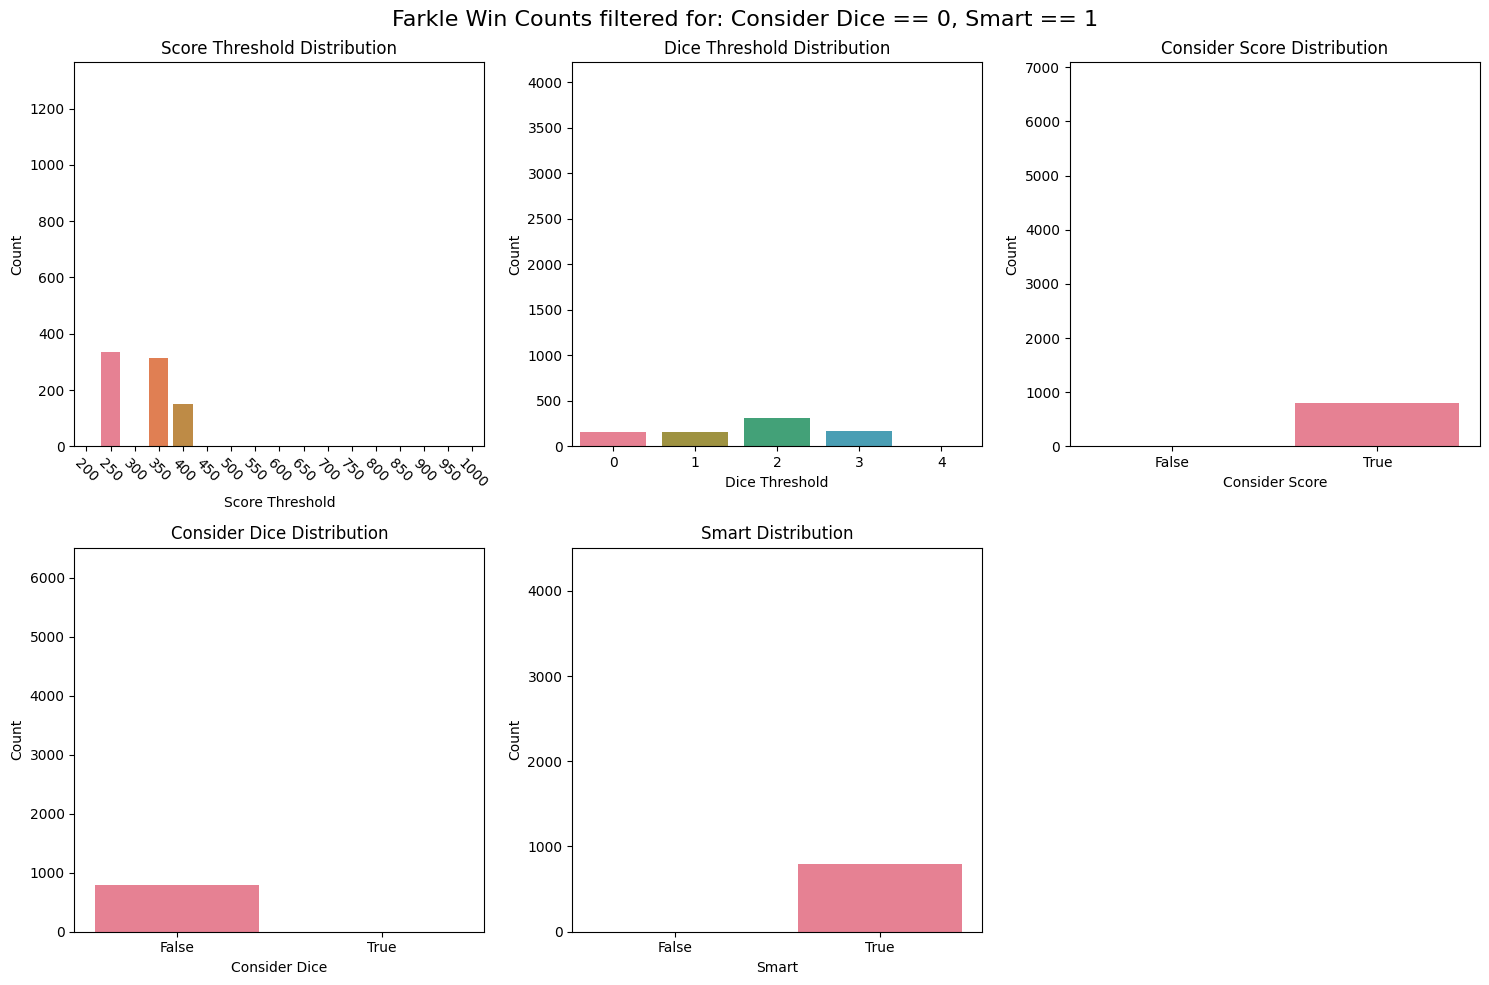

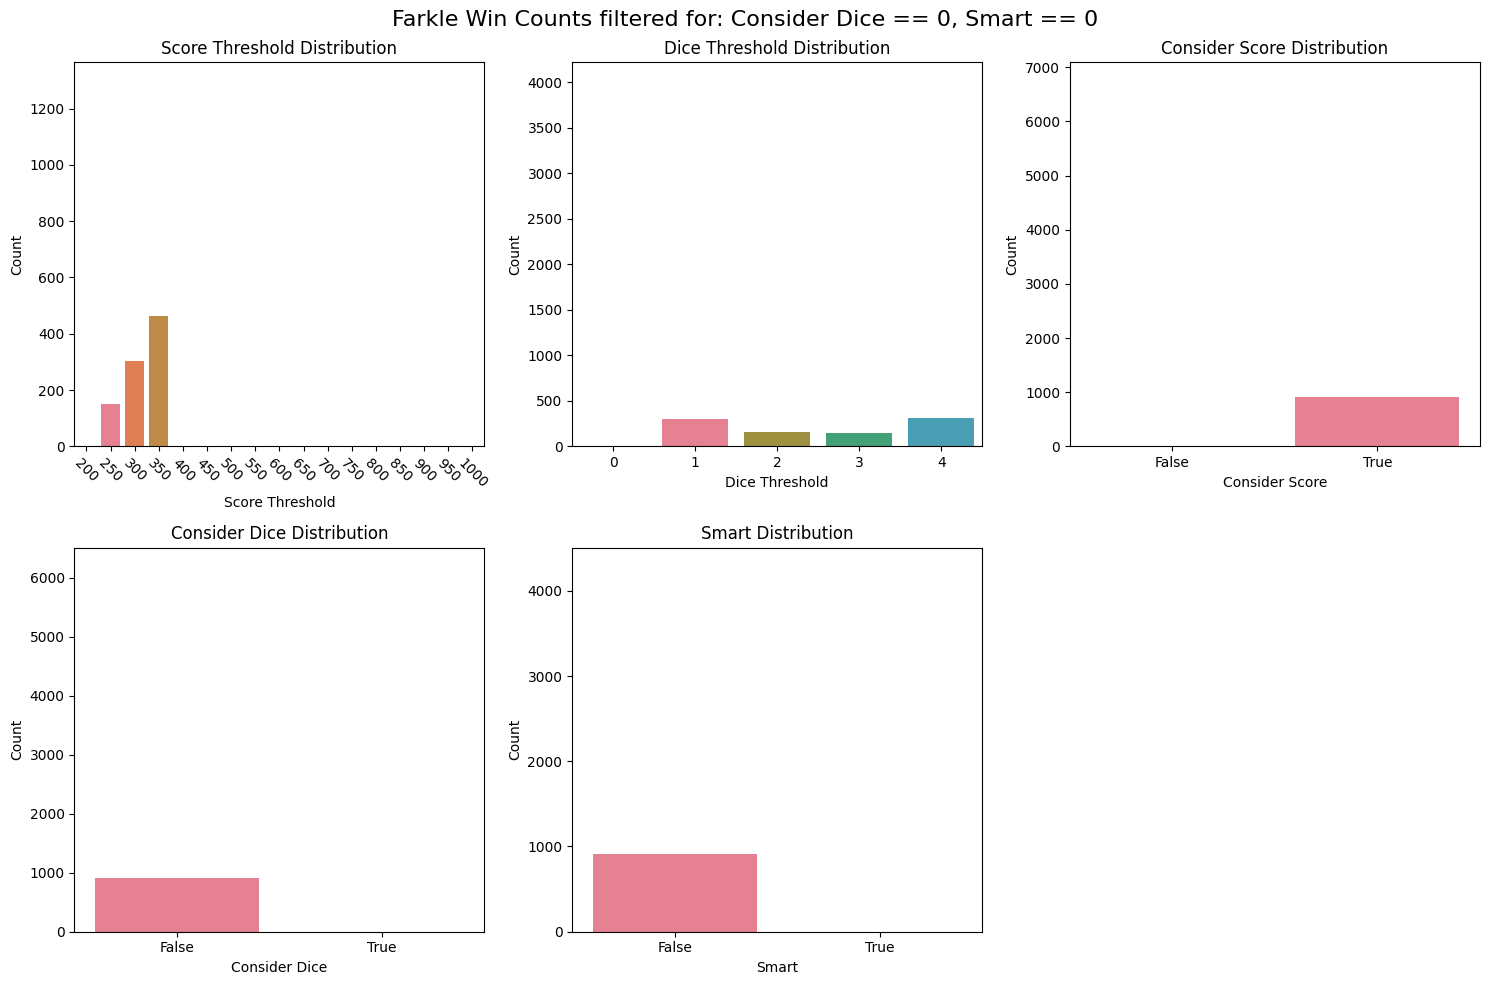

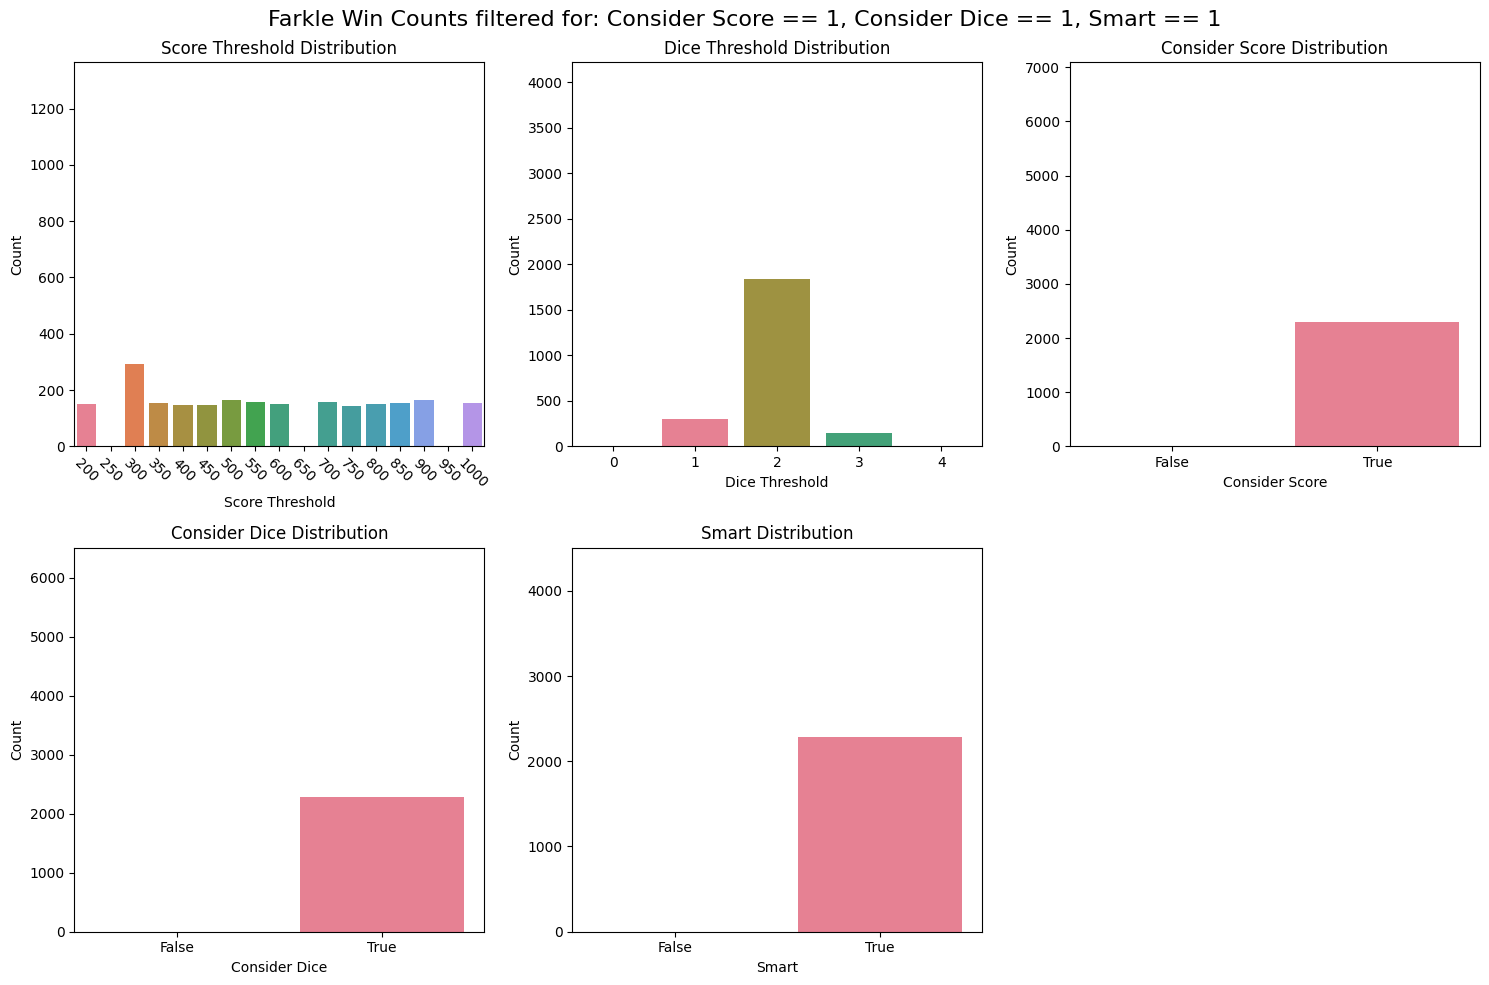

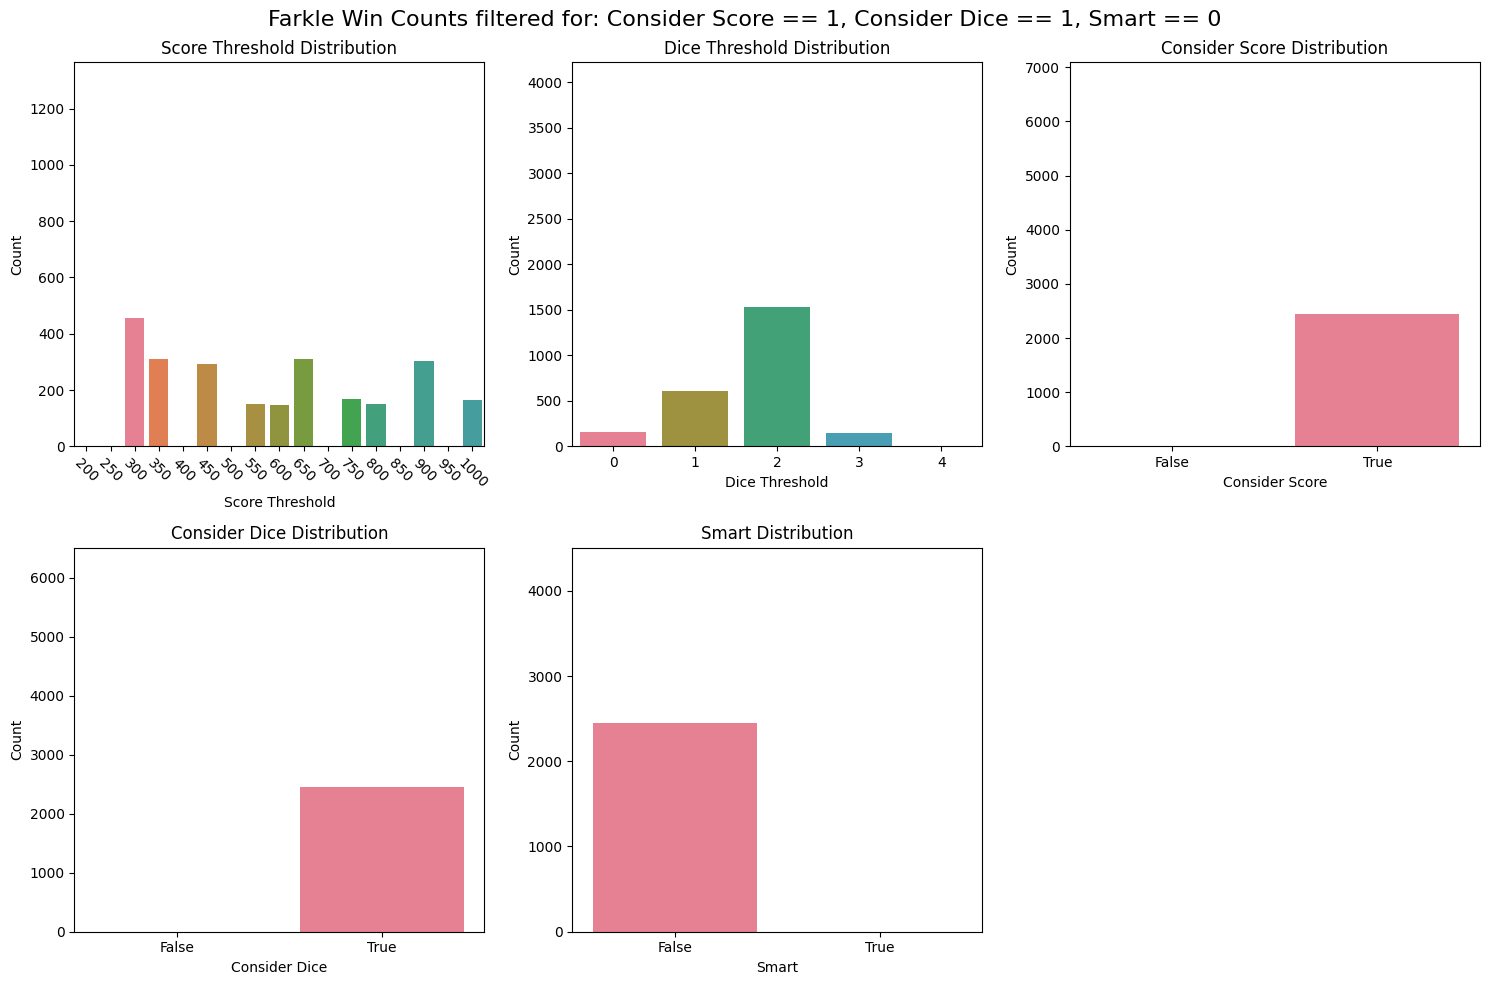

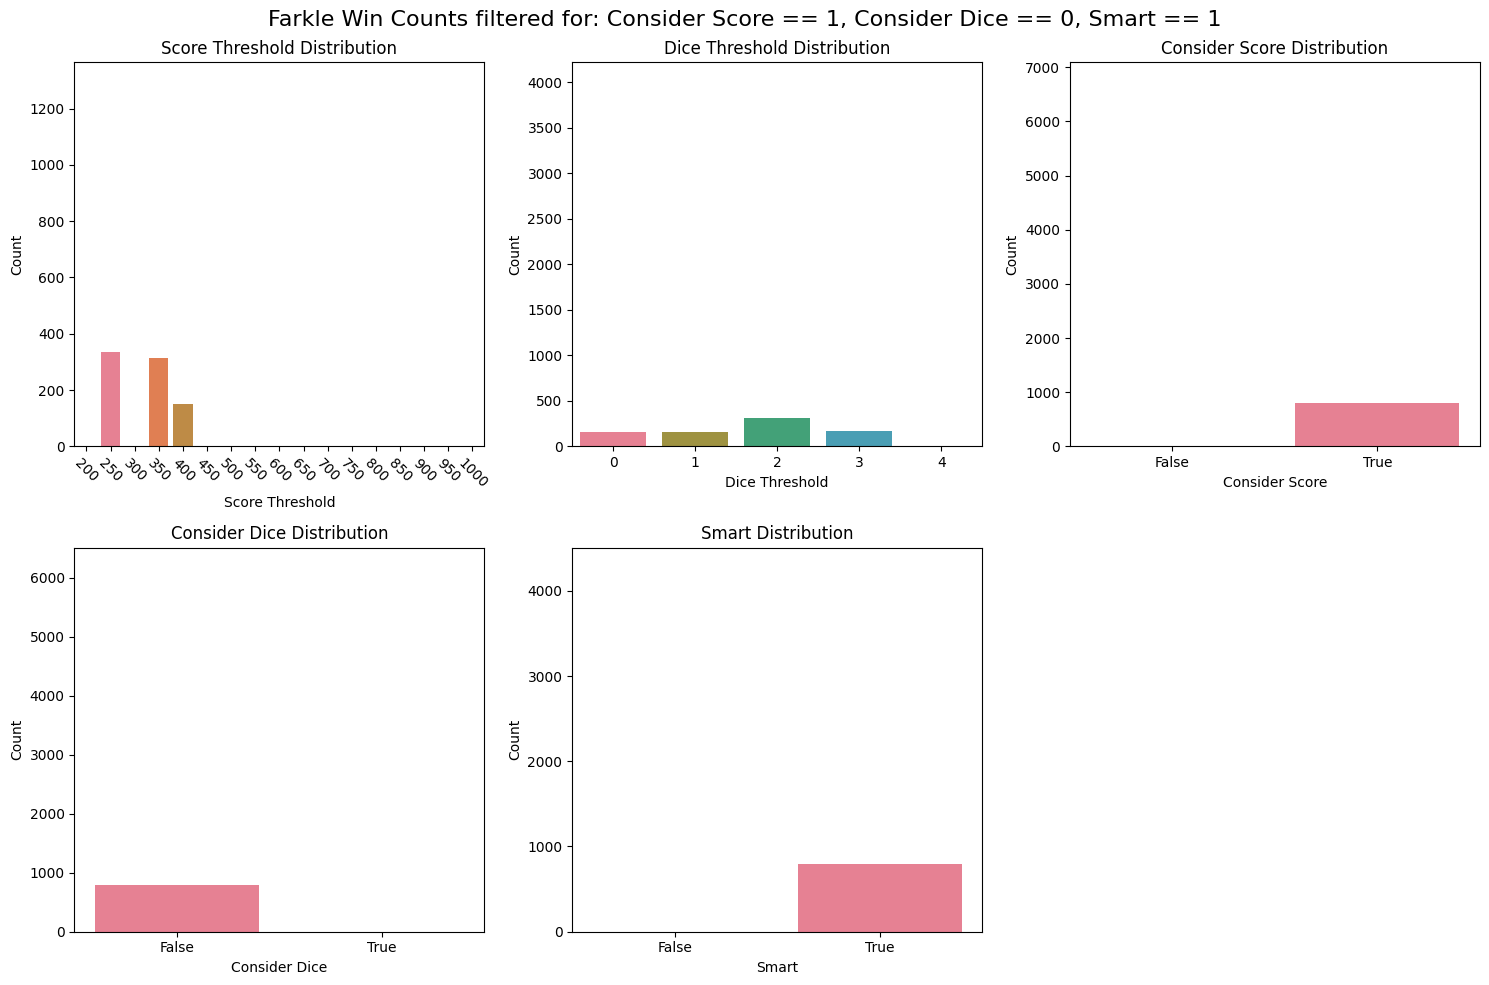

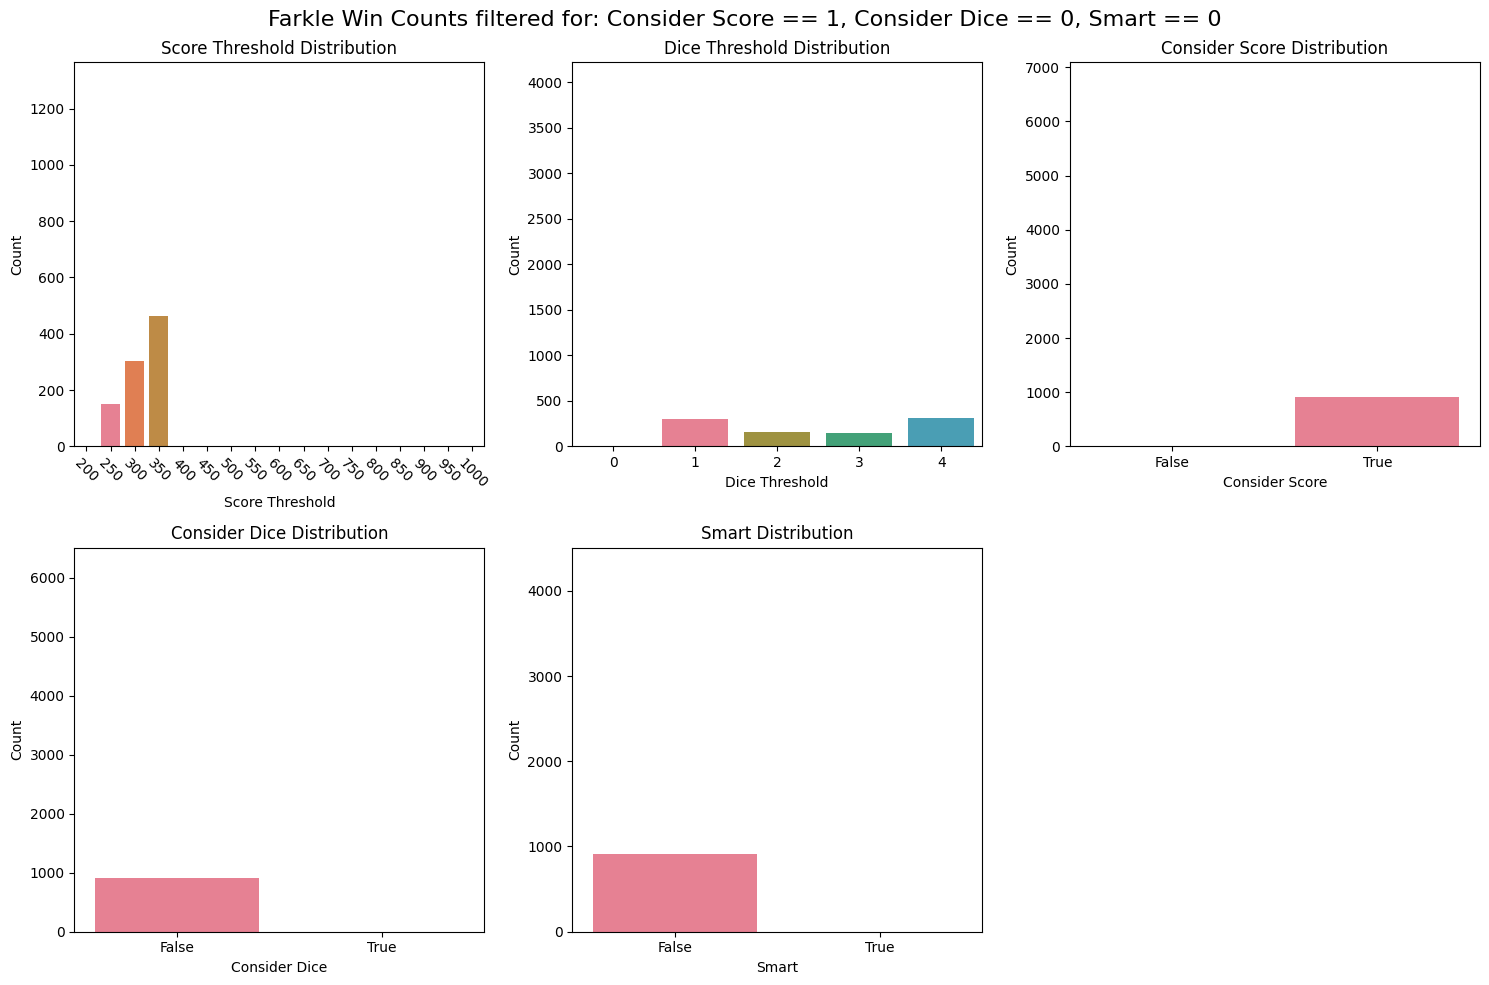

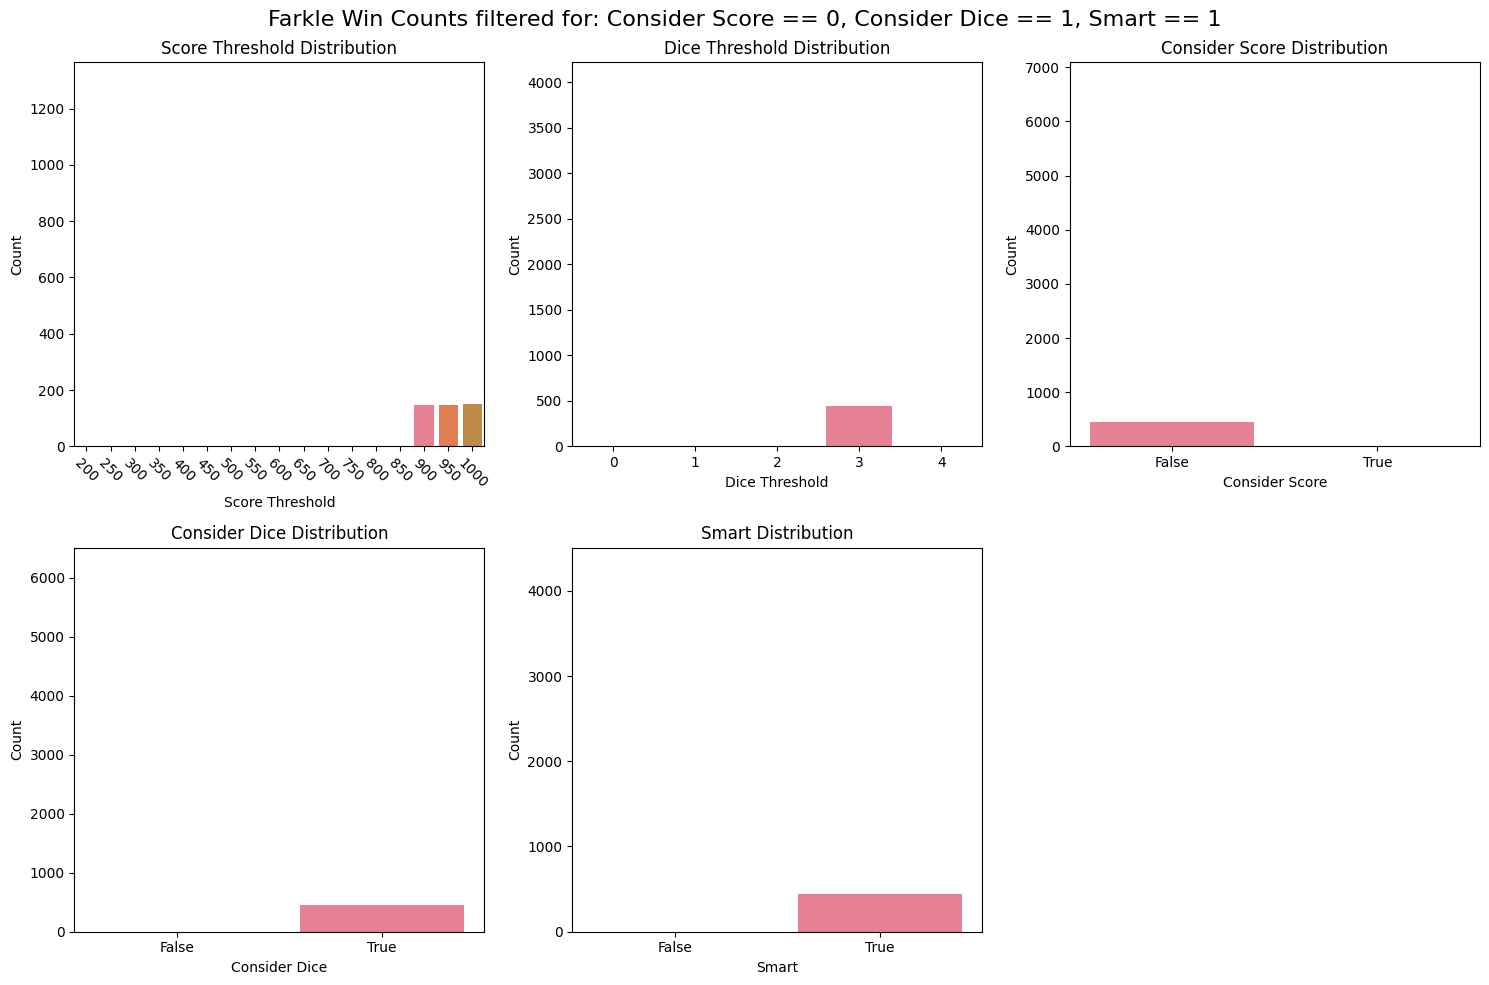

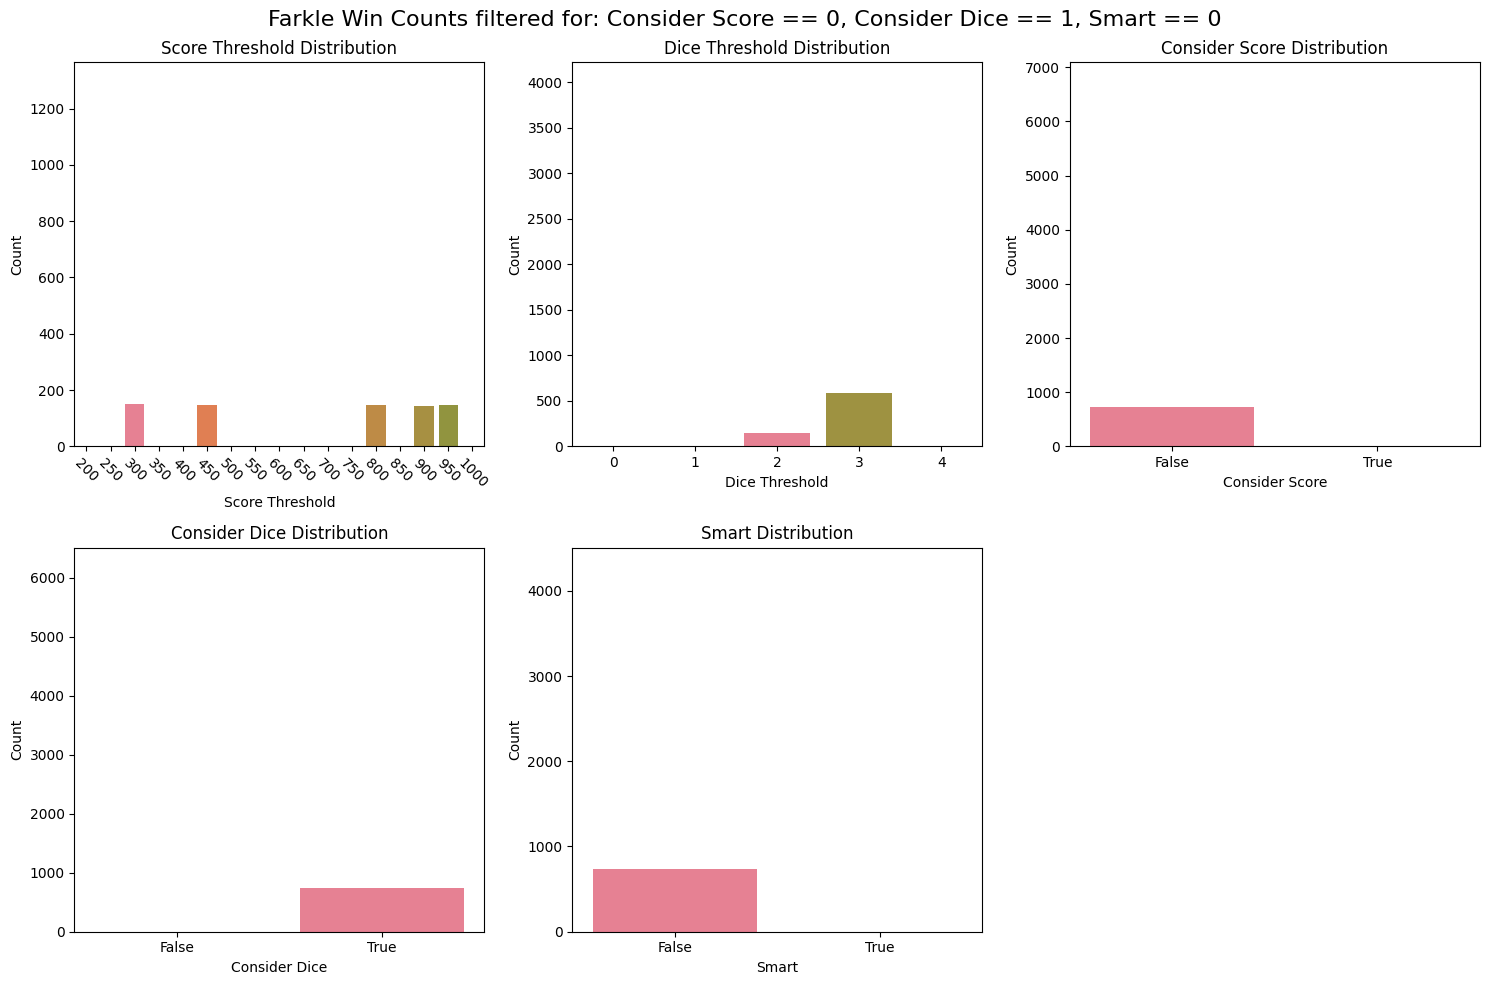

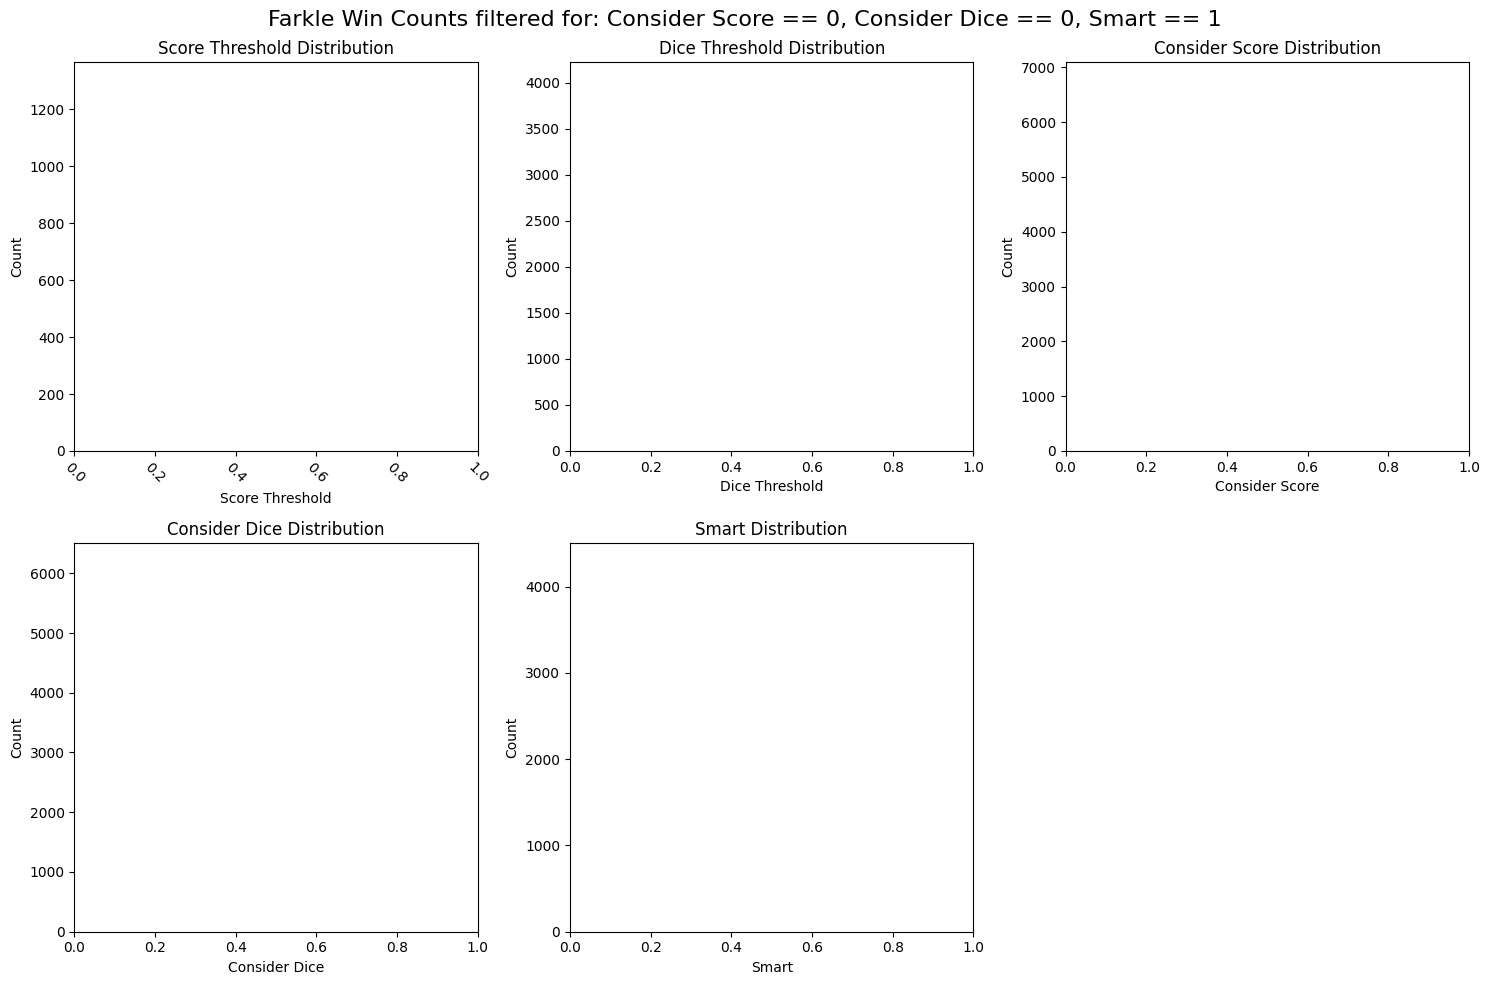

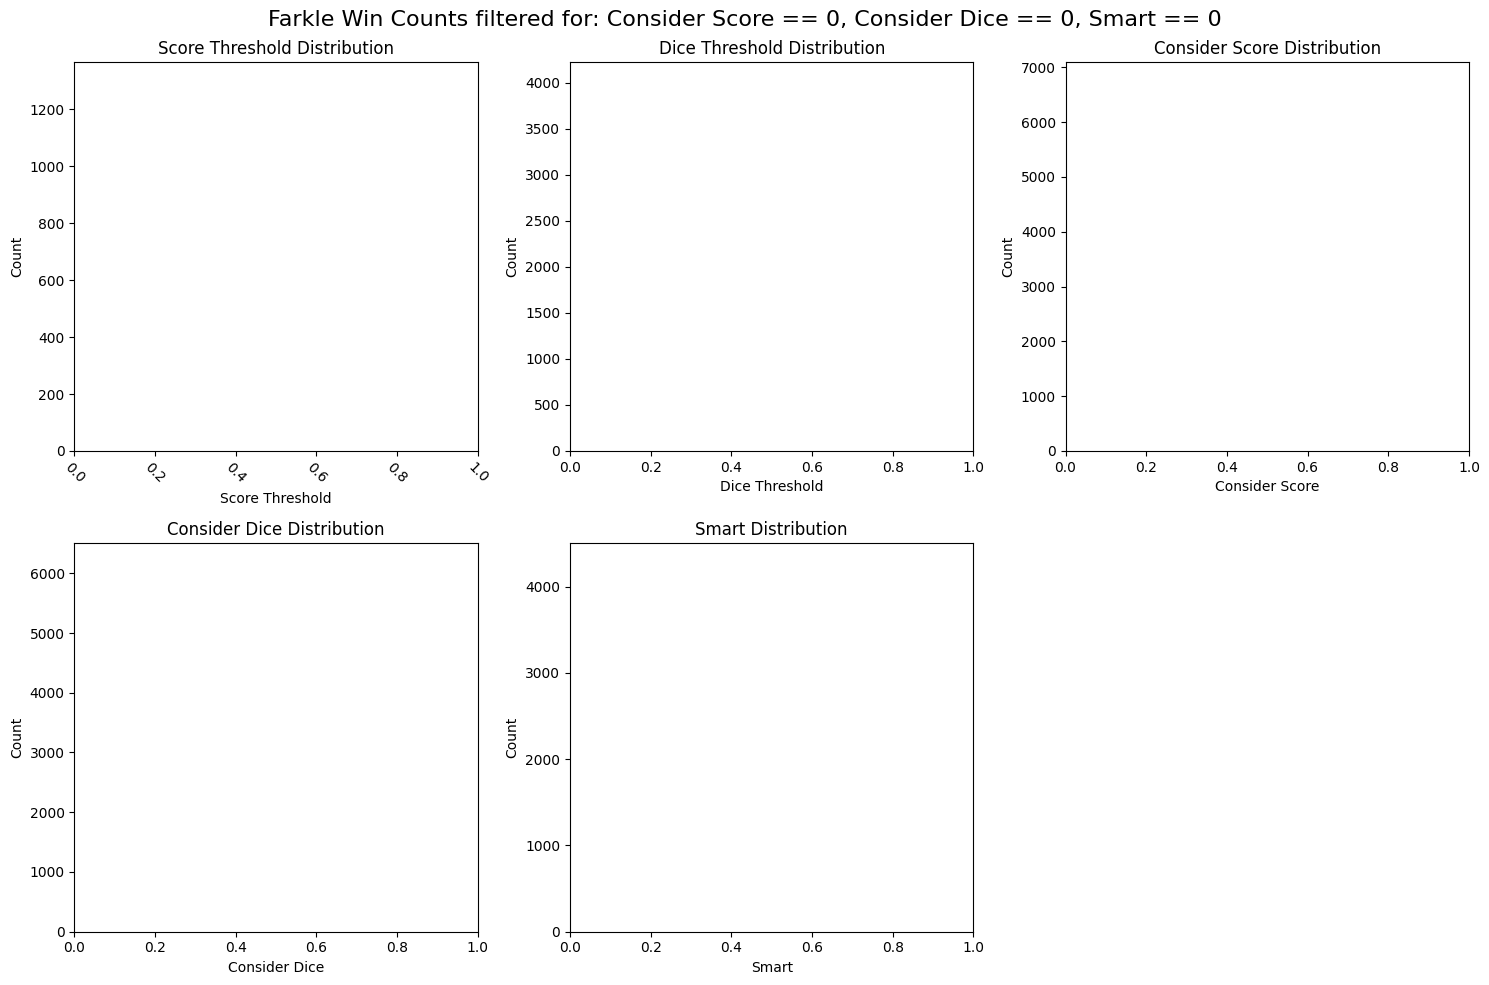

In [8]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import math

def apply_filters(df, filter_columns, filter_values):
    if not isinstance(filter_columns, list):
        lst_filter_columns = [filter_columns]
    else:
        lst_filter_columns = filter_columns

    if not isinstance(filter_values, list):
        lst_filter_values = [filter_values]
    else:
        lst_filter_values = filter_values
    
    if len(lst_filter_columns) != len(lst_filter_values):
        raise ValueError('Number of filter_columns does not match number of filter_values')
    
    df_filters = []
    for i in range(len(lst_filter_columns)):
        df_filters.append(df[lst_filter_columns[i]] == lst_filter_values[i])
    combined_filter = reduce(lambda x, y: x & y, df_filters)
    return df[combined_filter]

def filtered_farkle_counts_plotter(df, column_names, filter_columns, filter_values, title_suffix, global_max_counts):
    # Apply the filters
    filtered_df = apply_filters(df, filter_columns, filter_values)
    
    # Set up the grid for plotting
    n_cols = 3
    n_rows = math.ceil(len(column_names)/n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    # Flatten axes array for easy indexing
    axes = axes.flatten()
    
    # Create bar plots for each variable
    for i, variable in enumerate(column_names):
        x = filtered_df[variable]
        all_categories = sorted(df[variable].unique())
        num_categories = x.nunique()

        palette = sns.color_palette('husl', len(all_categories))
        sns.countplot(x=x, ax=axes[i], hue=x, palette=palette[:num_categories], legend=False, order=all_categories)
        
        axes[i].set_title(f'{variable} Distribution')
        axes[i].set_xlabel(variable)
        axes[i].set_ylabel('Count')
        
        # Set y-limit using the pre-computed global max count for this variable
        max_count_for_var = global_max_counts.get(variable, 1)
        axes[i].set_ylim(0, max_count_for_var * 1.1)  # add a little buffer
        
        if i == 0:
            axes[i].tick_params(axis='x', rotation=315)
    
    # Remove any empty subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle(f"Farkle Win Counts filtered for: {title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example Usage
df = pd.read_csv('top_50_strategies_weighted.csv')
strategy_columns = ['Score Threshold', 'Dice Threshold', 'Consider Score', 'Consider Dice', 'Smart']

# Suppose all_filters is something like:
# all_filters = [
#     (['Consider Score'], [1], 'Consider Score == 1'),
#     (['Consider Dice'], [1], 'Consider Dice == 1'),
#     (['Smart'], [1], 'Smart == 1')
# ]

# First, compute global maxima for each column across all filters
global_max_counts = {col: 0 for col in strategy_columns}

for item in all_filters:
    filtered_df = apply_filters(df, item[0], item[1])
    for col in strategy_columns:
        counts = filtered_df[col].value_counts()
        if not counts.empty:
            max_count = counts.max()
            if max_count > global_max_counts[col]:
                global_max_counts[col] = max_count

# Now that we have the global max counts for each variable,
# we can use them when plotting
for item in all_filters:
    filtered_farkle_counts_plotter(df, strategy_columns, item[0], item[1], item[2], global_max_counts)


Cool to generate that many graphs so easily, not so cool to actually try to get any meaning out of them.  Gonna do some dataframe operations.